# Experimenting with different interaction measures between logging concessions
This file experients with 2 different measures for interactions between two concessions (e.g. every pair of unique concessions have a score) as well as different deforestation metrics for the y-axis to find ones with higher correlation which would indicate capturing the effect of concessions on each other

- cells 35-38 show most promising results + statistical analysis for fit 


In [2]:
# imports
import numpy as np
import matplotlib as mpl
# from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import descartes
gdf = gpd.read_file("data/Managed_Forest_Concessions_(WRI).geojson")
# gdf = gpd.read_file("mock/mock_concessions.geojson")


<AxesSubplot:>

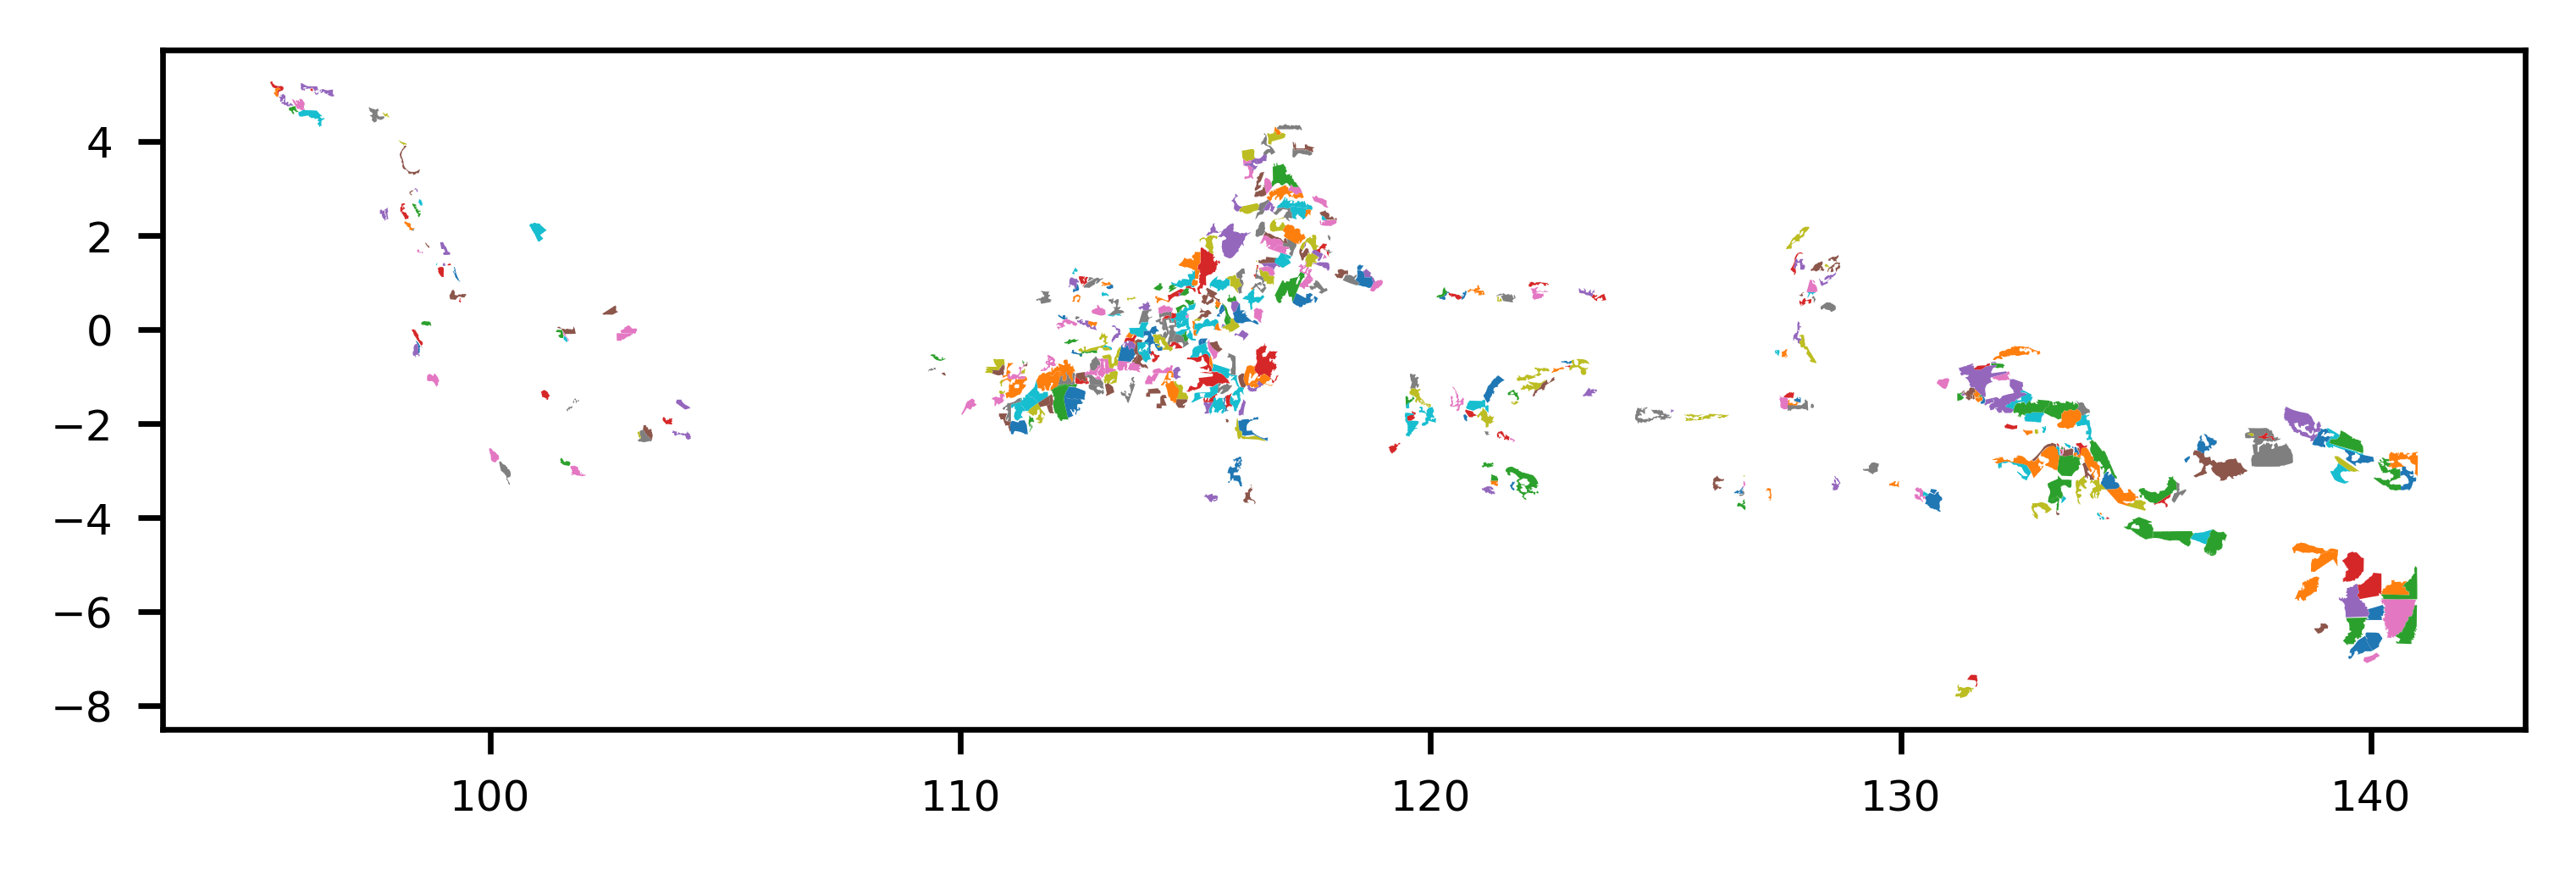

In [48]:
# plot map
mpl.rcParams['figure.dpi'] = 600 # set dpi
gdf.plot("area_ha", legend=False) 

<AxesSubplot:>

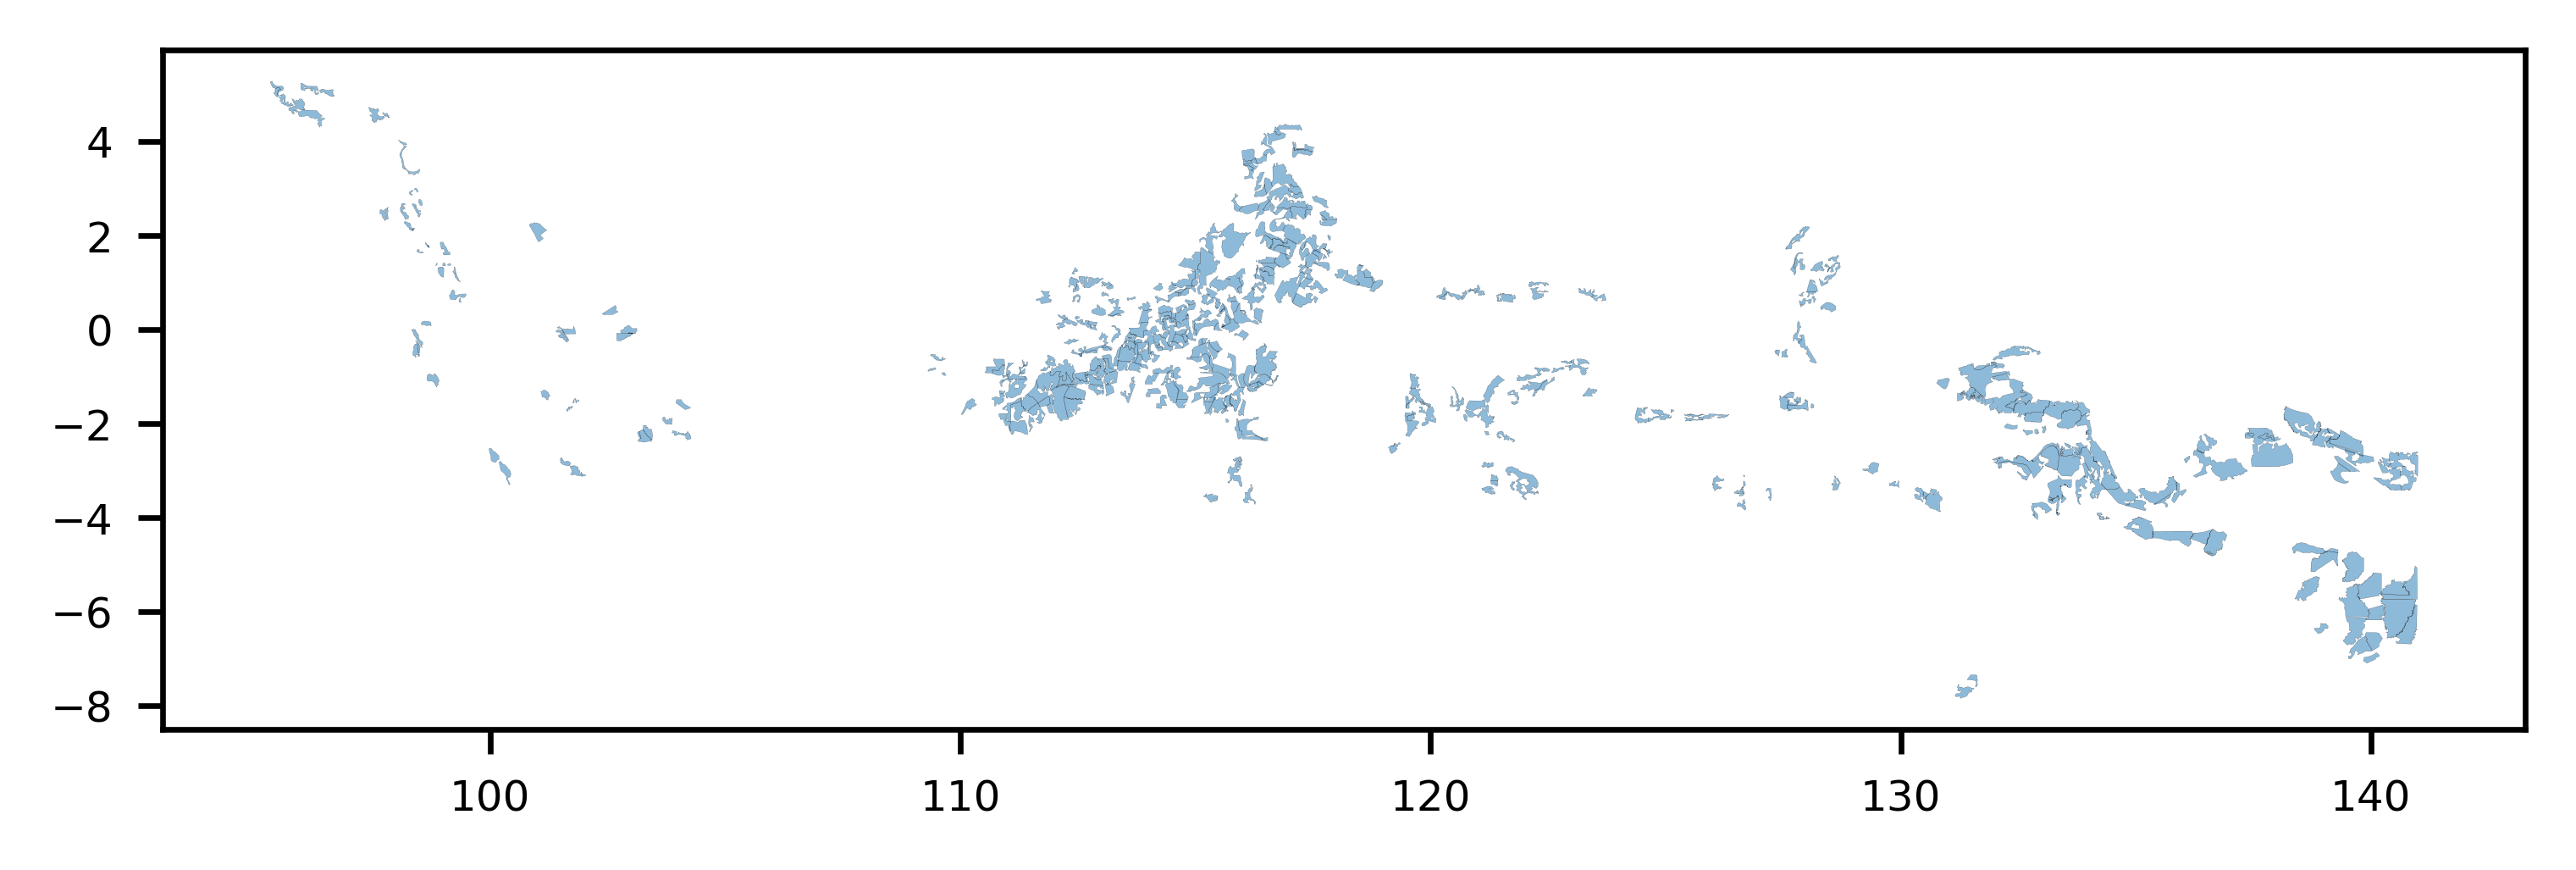

In [49]:
# One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet. 
gdf["buffered"] = gdf.buffer(.00) # set buffer
ax = gdf.set_geometry('buffered').plot(alpha=.5) # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf.plot(ax=ax, facecolor = "none", edgecolor="black", linewidth=.02) # passing the first plot

Some background data distribution analysis:

In [50]:
# implement year column
# there's a weird 26 ending - legal term 522.21-26 - unsure how to handle?
years = [i[-2:] for i in gdf['legal_term']]
gdf["year"] = ["19"+i  if int(i) > 30 else "20"+i for i in years]
unique = np.unique(gdf["year"])
print(len(unique), unique)

26 ['1978' '1983' '1985' '1987' '1988' '1989' '1990' '1991' '1992' '1993'
 '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2004'
 '2005' '2006' '2007' '2008' '2009' '2026']


[('1978', 1), ('1983', 1), ('1985', 1), ('1987', 9), ('1988', 21), ('1989', 17), ('1990', 12), ('1991', 23), ('1992', 28), ('1993', 20), ('1994', 14), ('1995', 11), ('1996', 7), ('1997', 16), ('1998', 9), ('1999', 46), ('2000', 63), ('2001', 22), ('2002', 7), ('2003', 0), ('2004', 35), ('2005', 22), ('2006', 75), ('2007', 24), ('2008', 12), ('2009', 57)]


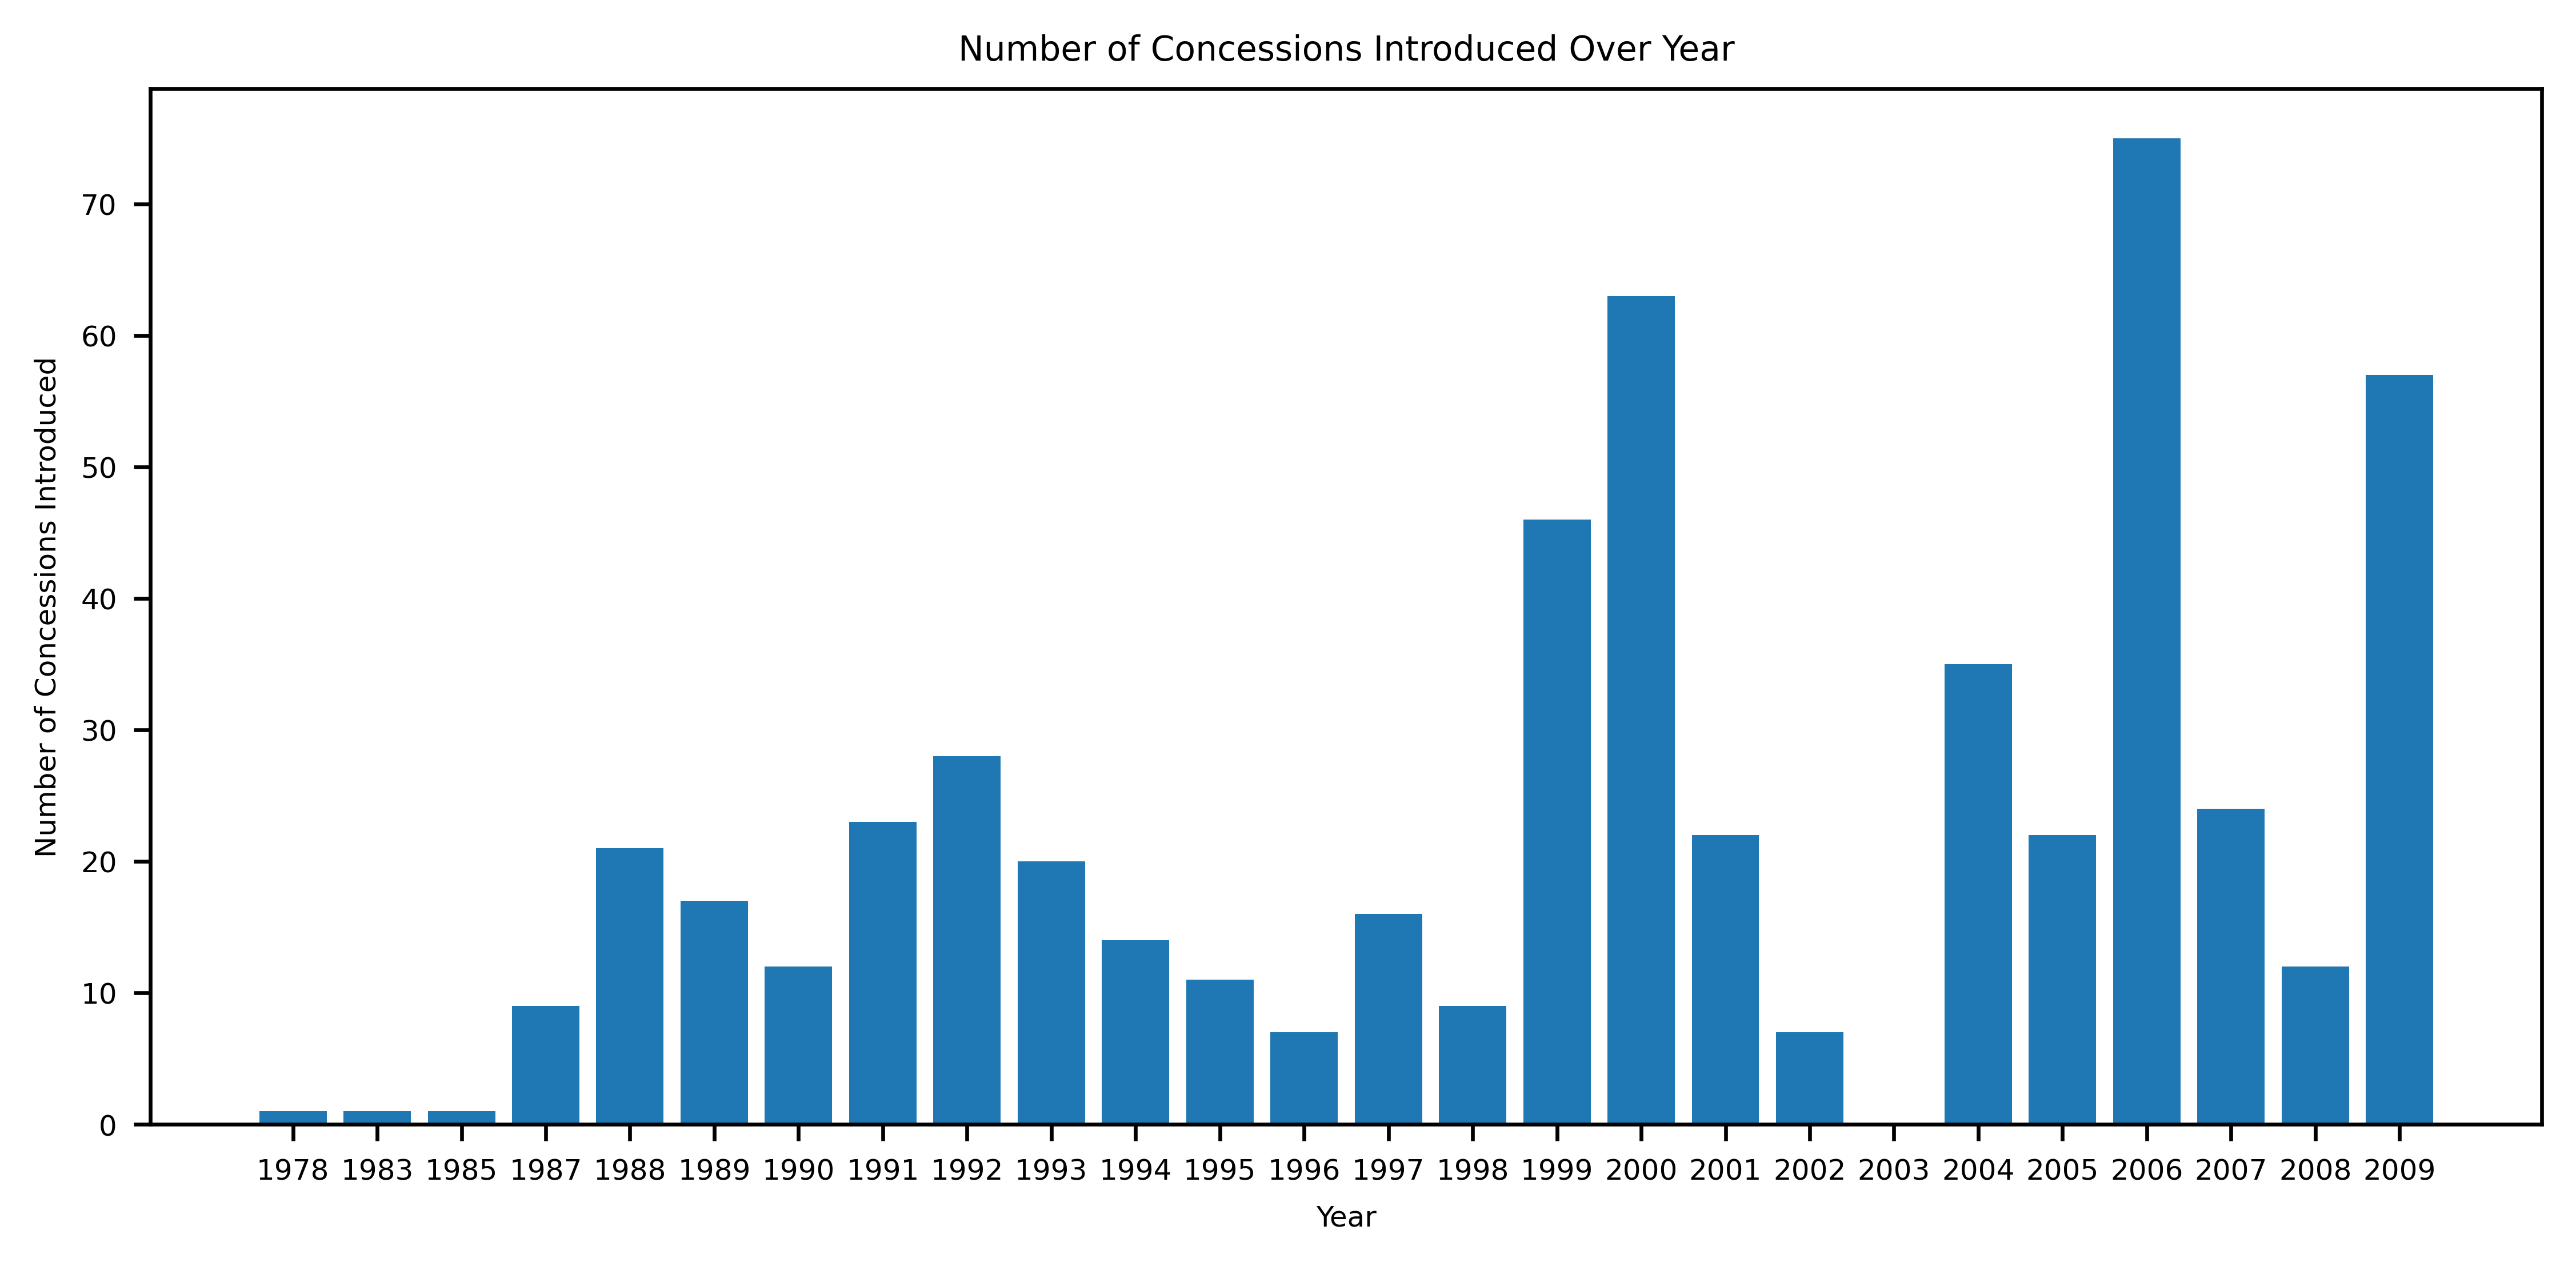

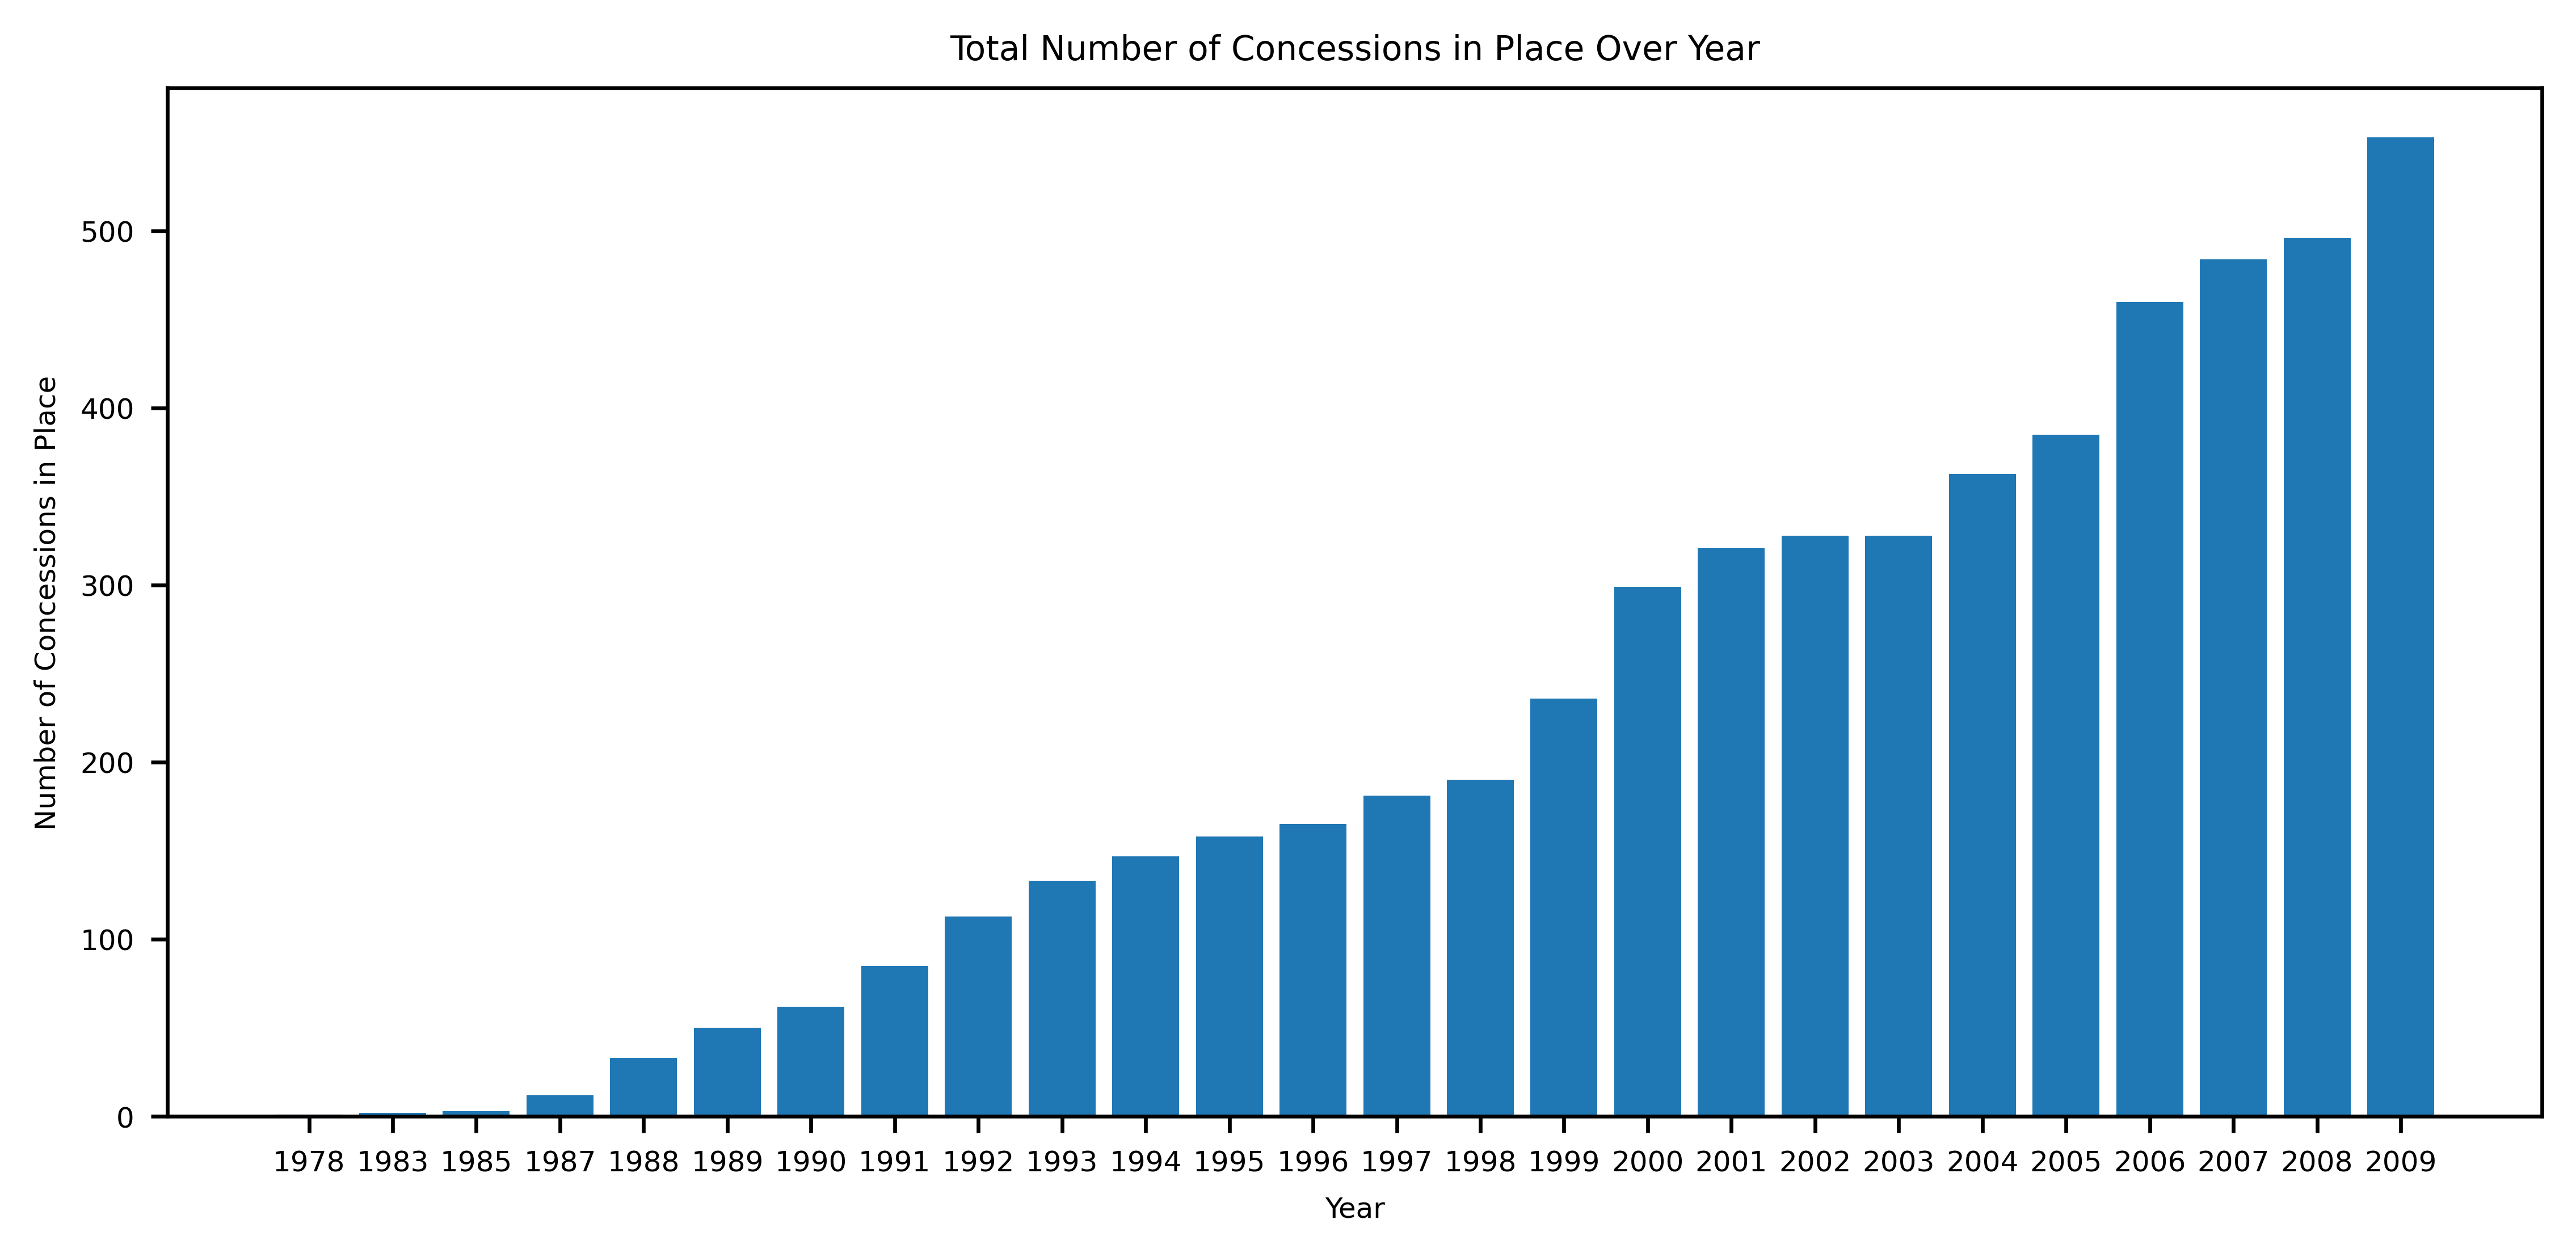

In [51]:
from collections import Counter
plt.rcParams.update({'font.size': 6})

conc_count_by_yr = Counter(gdf["year"]) # list of (year, count) tuples for concessions introduced each year
conc_count_by_yr['2003'] = 0
conc_count_by_yr = sorted(conc_count_by_yr.items())[:-1] # sort, ignore the wack 26 term 
print(conc_count_by_yr)

keys = [i[0] for i in conc_count_by_yr]
vals = [i[1] for i in conc_count_by_yr]
cumul_vals = [sum(vals[:i+1]) for i in range(len(vals))] # cumulative count

# plot change in numberper year
plt.figure(figsize=(9, 4))
plt.bar(keys, vals)
plt.title("Number of Concessions Introduced Over Year")
plt.xlabel("Year")
plt.ylabel("Number of Concessions Introduced")
plt.show()

# plot cumulative count per year
plt.figure(figsize=(9, 4))
plt.bar(keys, cumul_vals)
plt.title("Total Number of Concessions in Place Over Year")
plt.xlabel("Year")
plt.ylabel("Number of Concessions in Place")
plt.show()

['1978' '1983' '1985' '1987' '1988' '1989' '1990' '1991' '1992' '1993'
 '1994' '1995' '1996' '1997' '1998' '1999' '2000' '2001' '2002' '2003'
 '2004' '2005' '2006' '2007' '2008' '2009']


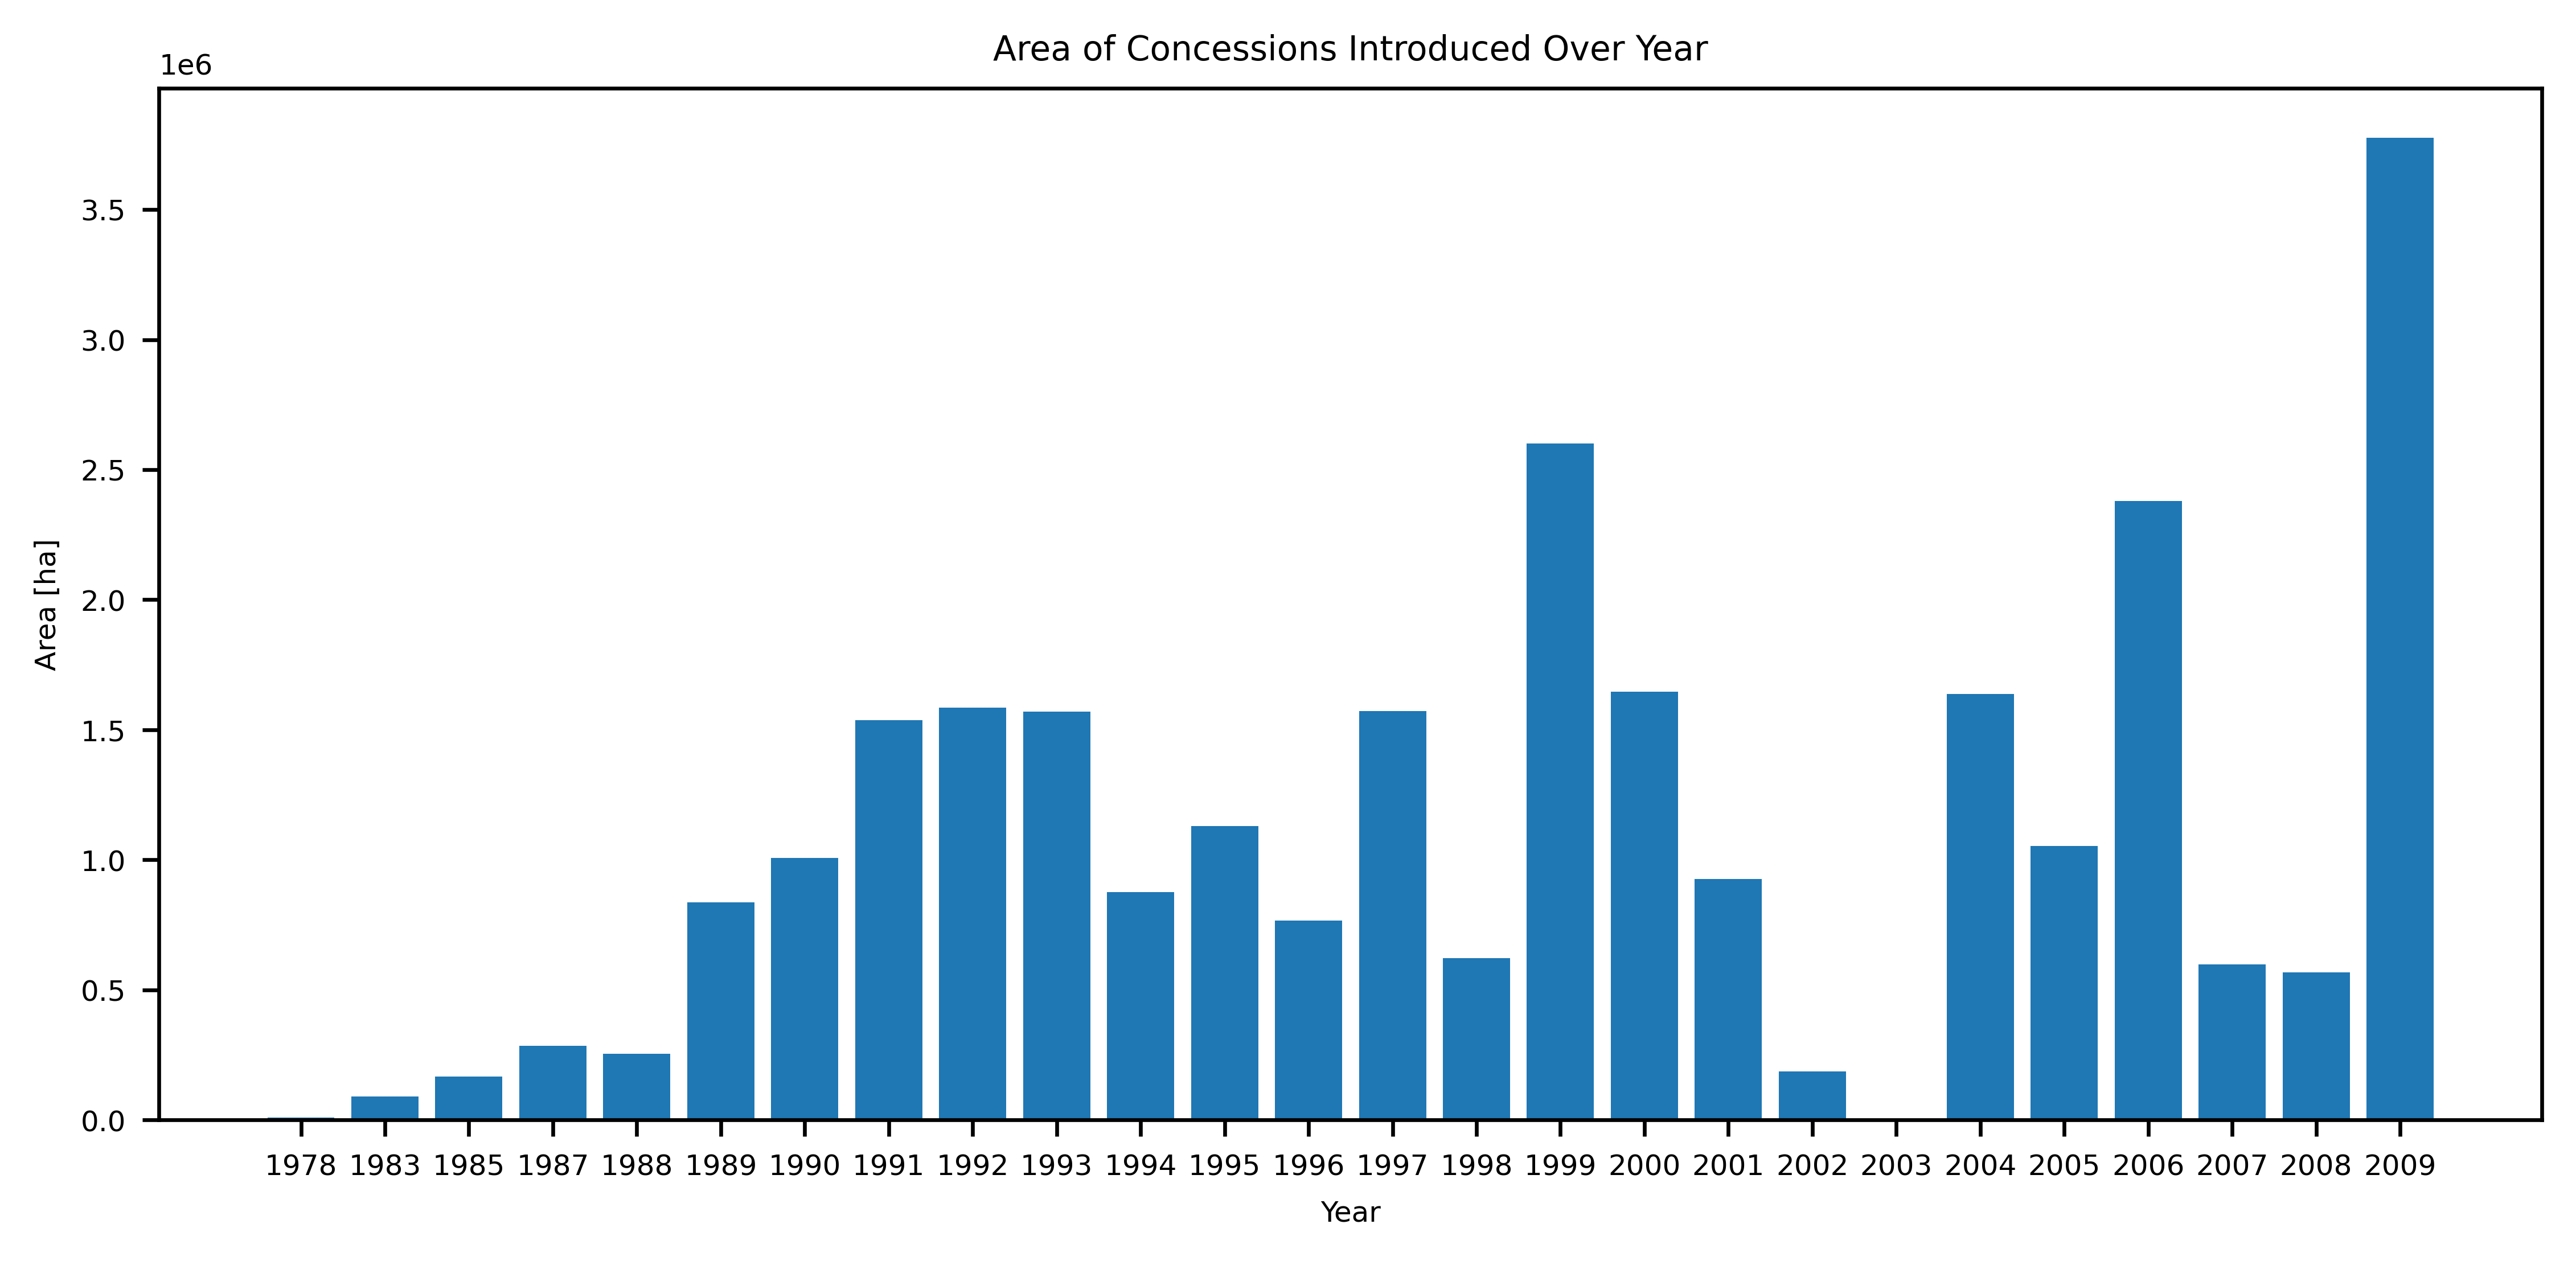

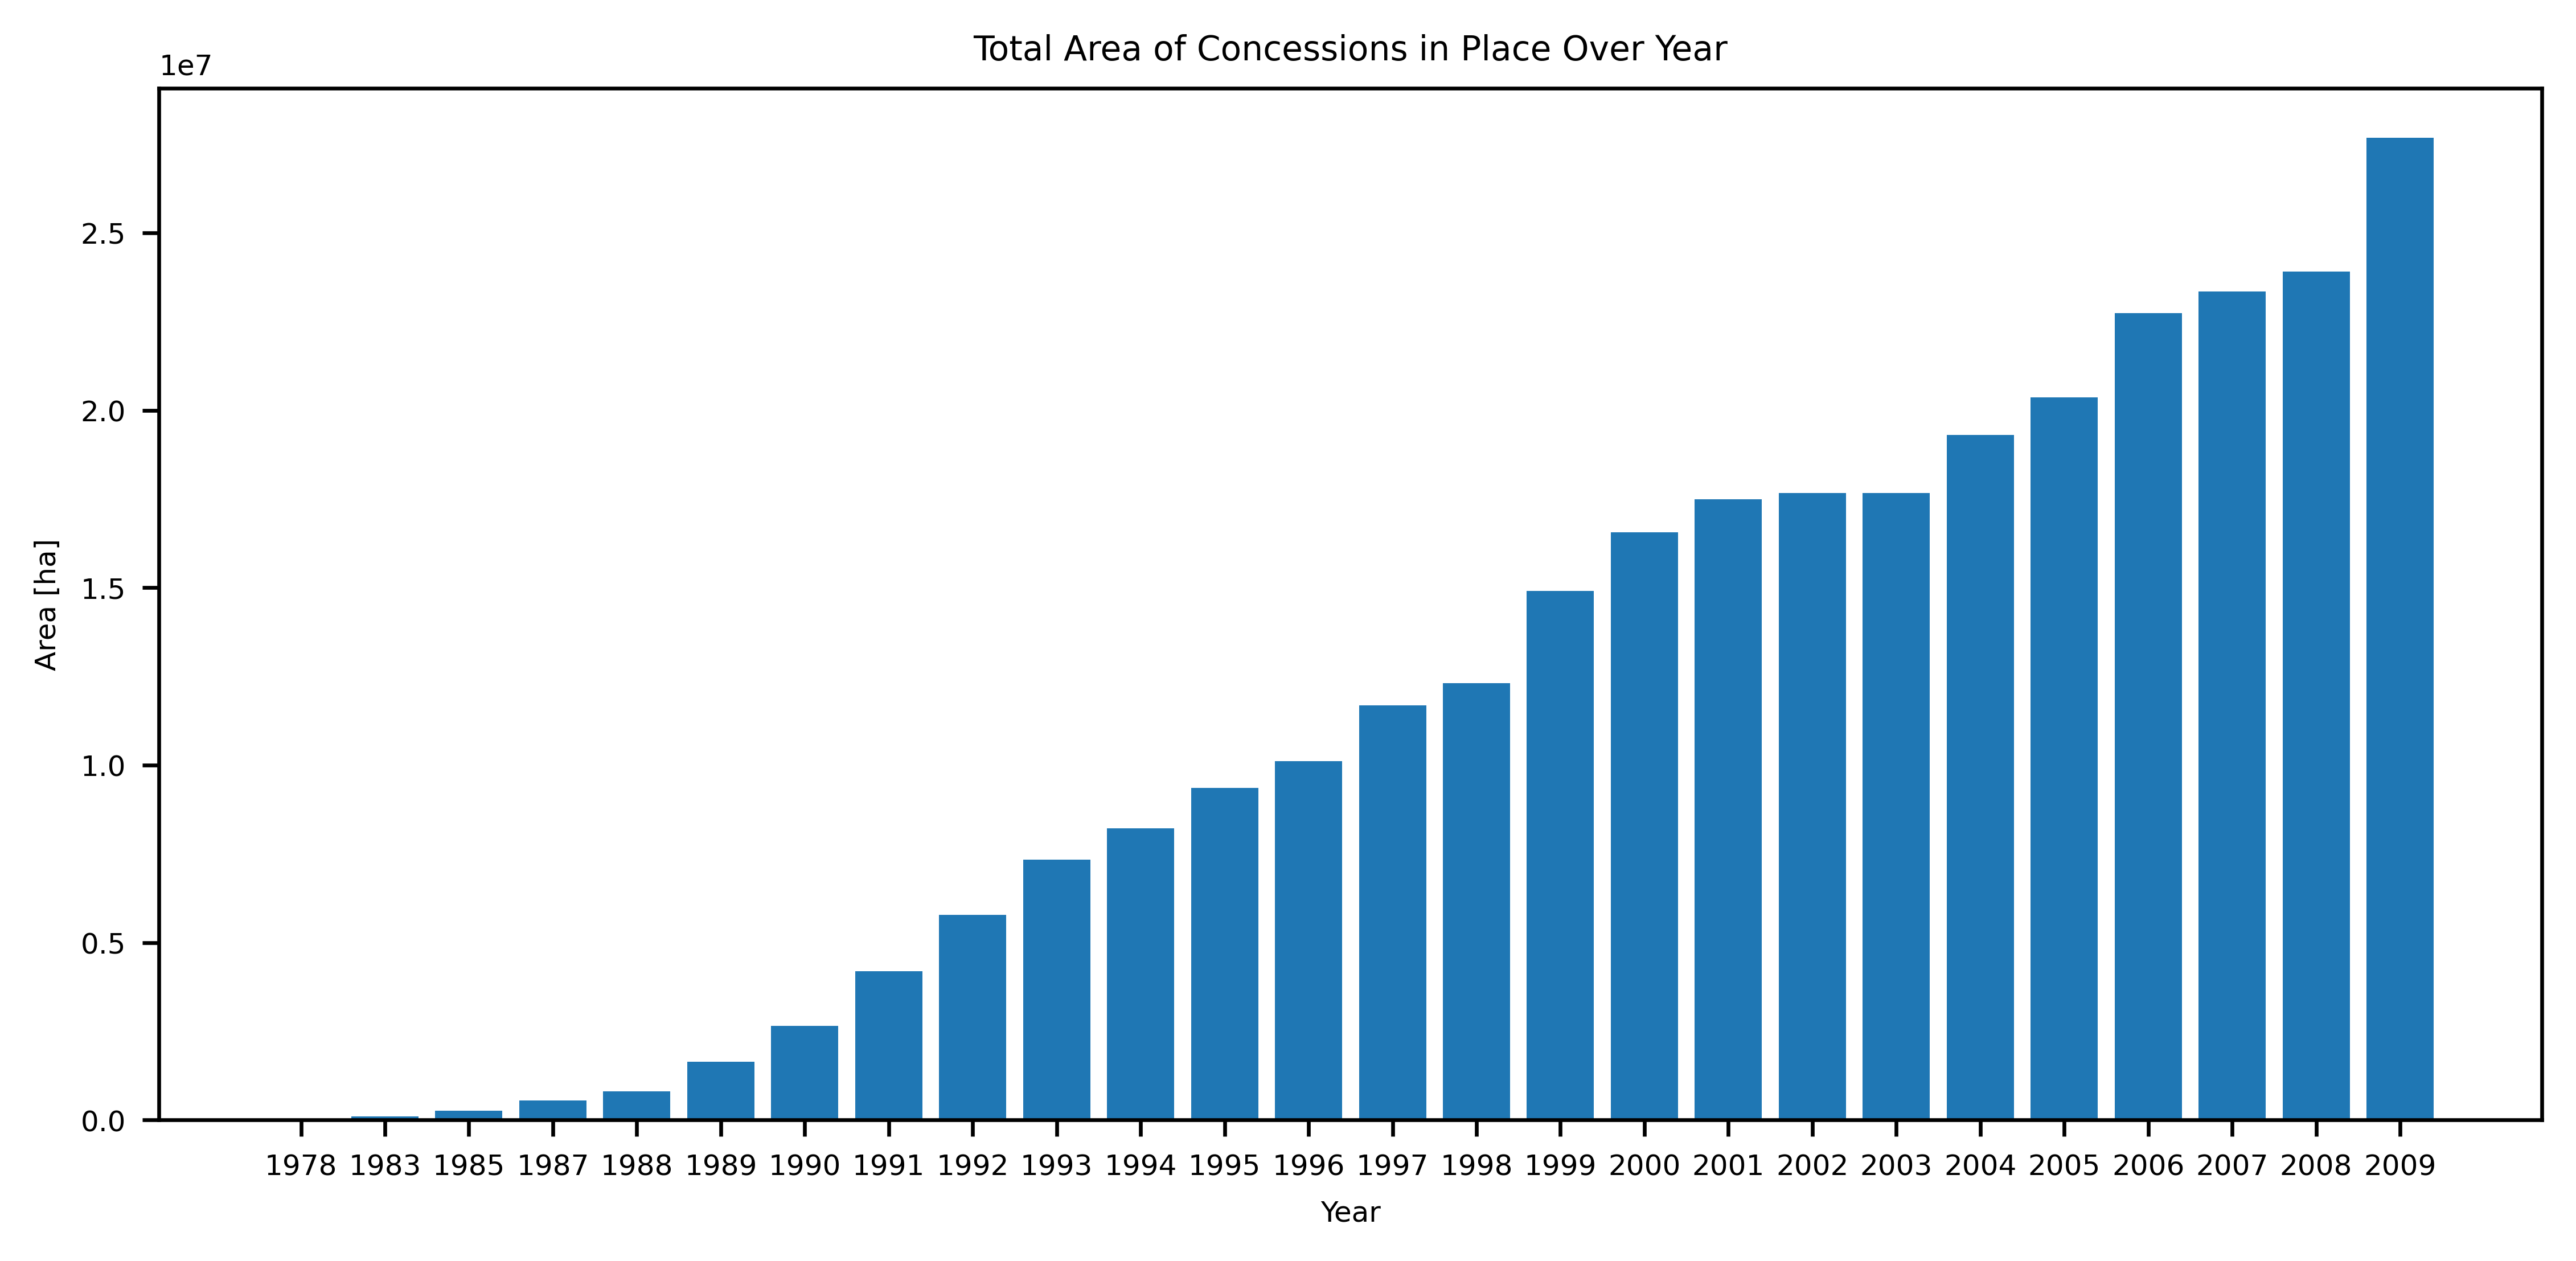

In [52]:
years = np.insert(np.unique(gdf['year'])[:-1], -6, '2003') # get all years concessions were added, ignore the weird 26 thing
print(years)
conc_by_yr = {}
conc_areas_by_year = {}

for year in years:
    conc_by_yr[year] = [i for i in range(len(gdf)) if gdf["year"][i] == year]
    conc_areas_by_year[year] = sum([float(gdf['area_ha'][i]) for i in conc_by_yr[year]])

keys = list(conc_areas_by_year.keys())
vals = list(conc_areas_by_year.values())
cumul_vals = [sum(vals[:i+1]) for i in range(len(vals))] # cumulative count

# plot change in area per year
plt.figure(figsize=(9, 4))
plt.bar(keys, vals)
plt.title("Area of Concessions Introduced Over Year")
plt.xlabel("Year")
plt.ylabel("Area [ha]")
plt.show()

# plot cumulative area per year
plt.figure(figsize=(9, 4))
plt.bar(keys, cumul_vals)
plt.title("Total Area of Concessions in Place Over Year")
plt.xlabel("Year")
plt.ylabel("Area [ha]")
plt.show()

# Interaction measure 1: Shared boundary 
interaction between concessions C1, C2 = (length of common boundary C1-C2)/(Perimeter C1 + Perimeter C2)

In [53]:
# interaction measure 1: create common boundary length matrix
adj_mat_shared_boundary_len = []
for indx, polygon in enumerate(gdf.loc[:, "geometry"]):
    row = gdf.set_geometry("buffered").intersection(polygon).length # compute common length (1 is adjacent, 0 elsewise)
    #row[indx] = 0 #ignore comparisons to self
    adj_mat_shared_boundary_len.append(np.array(row))
adj_mat_shared_boundary_len = np.array(adj_mat_shared_boundary_len)

In [54]:
# calculate pairwise sum of geom perims intro matrix
perims_arr = np.array([gdf.loc[:, "geometry"].length]) # shape (1, 557)
perim_sum_arr = perims_arr +  perims_arr.T # shape (557, 557)

In [55]:
# boundary-perim interaction measure as defined above
boundary_perim_measure = adj_mat_shared_boundary_len / perim_sum_arr

In [56]:
# pairwise average cumul. deforestation
defor_cumul_prop_arr = np.array([pd.read_csv("outputs/features_by_logging_concession.csv")['defor_cumul_prop']])
pair_avg_deforcumulprop = (defor_cumul_prop_arr + defor_cumul_prop_arr.T)/2

In [57]:
def convert_2darr_to_1darr_uppertri(mat):
    triu_inds = np.triu_indices(n=len(mat), k=1)
    res = mat[triu_inds] # take upper triangulars (i.e. all unique pairs)
    print(len(res))
    return res

In [58]:
# boundary_perim_measure = convert_2darr_to_1darr_uppertri(boundary_perim_measure)
pair_avg_deforcumulprop = convert_2darr_to_1darr_uppertri(pair_avg_deforcumulprop)

boundary_perim_measure = convert_2darr_to_1darr_uppertri(boundary_perim_measure)

154846
154846


In [59]:
pair_avg_deforcumulprop = np.nan_to_num(pair_avg_deforcumulprop)

In [60]:
# sanity check, should be equal / have quantity 154846
print(len(boundary_perim_measure), len(pair_avg_deforcumulprop))

154846 154846


Text(0.35714285714285715, 0, 'pearson coeff: -0.005')

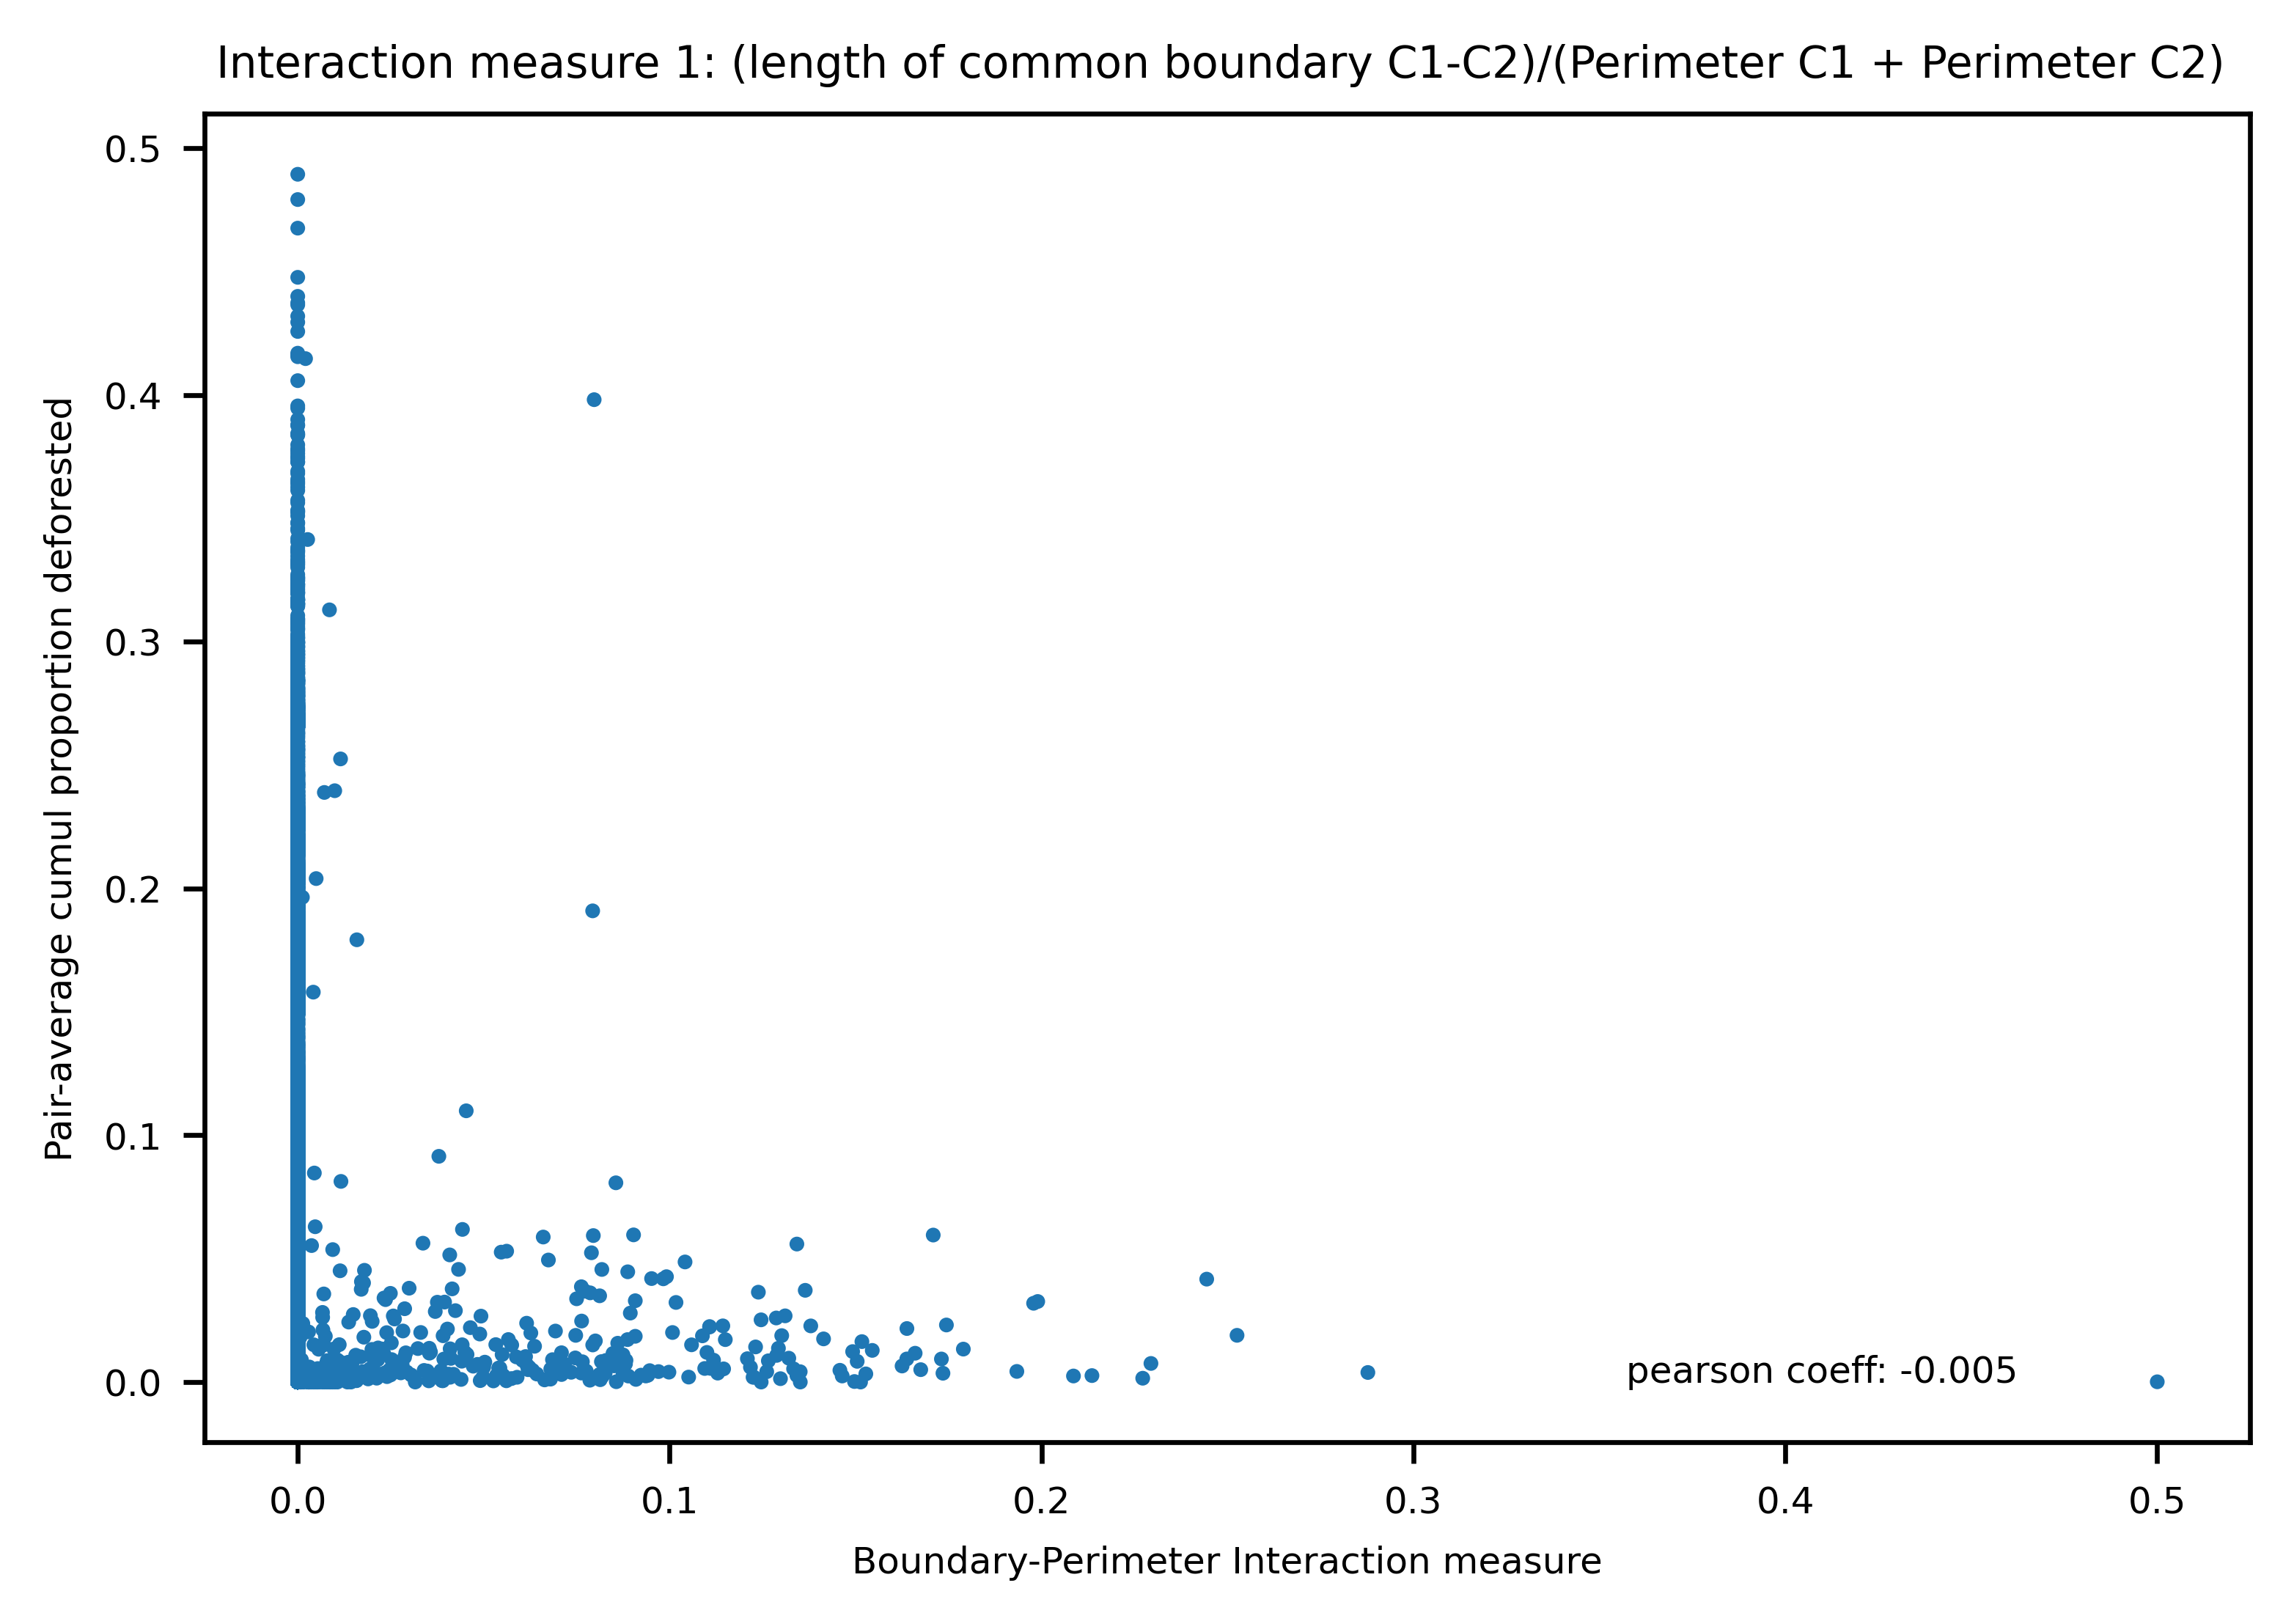

In [61]:
# date: 10/13

# plot results
from scipy import stats
x = boundary_perim_measure
y = pair_avg_deforcumulprop
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 1: (length of common boundary C1-C2)/(Perimeter C1 + Perimeter C2) ")
plt.xlabel("Boundary-Perimeter Interaction measure")
plt.ylabel("Pair-average cumul proportion deforested")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)

Text(0.35714285714285715, 0, 'pearson coeff: -0.059')

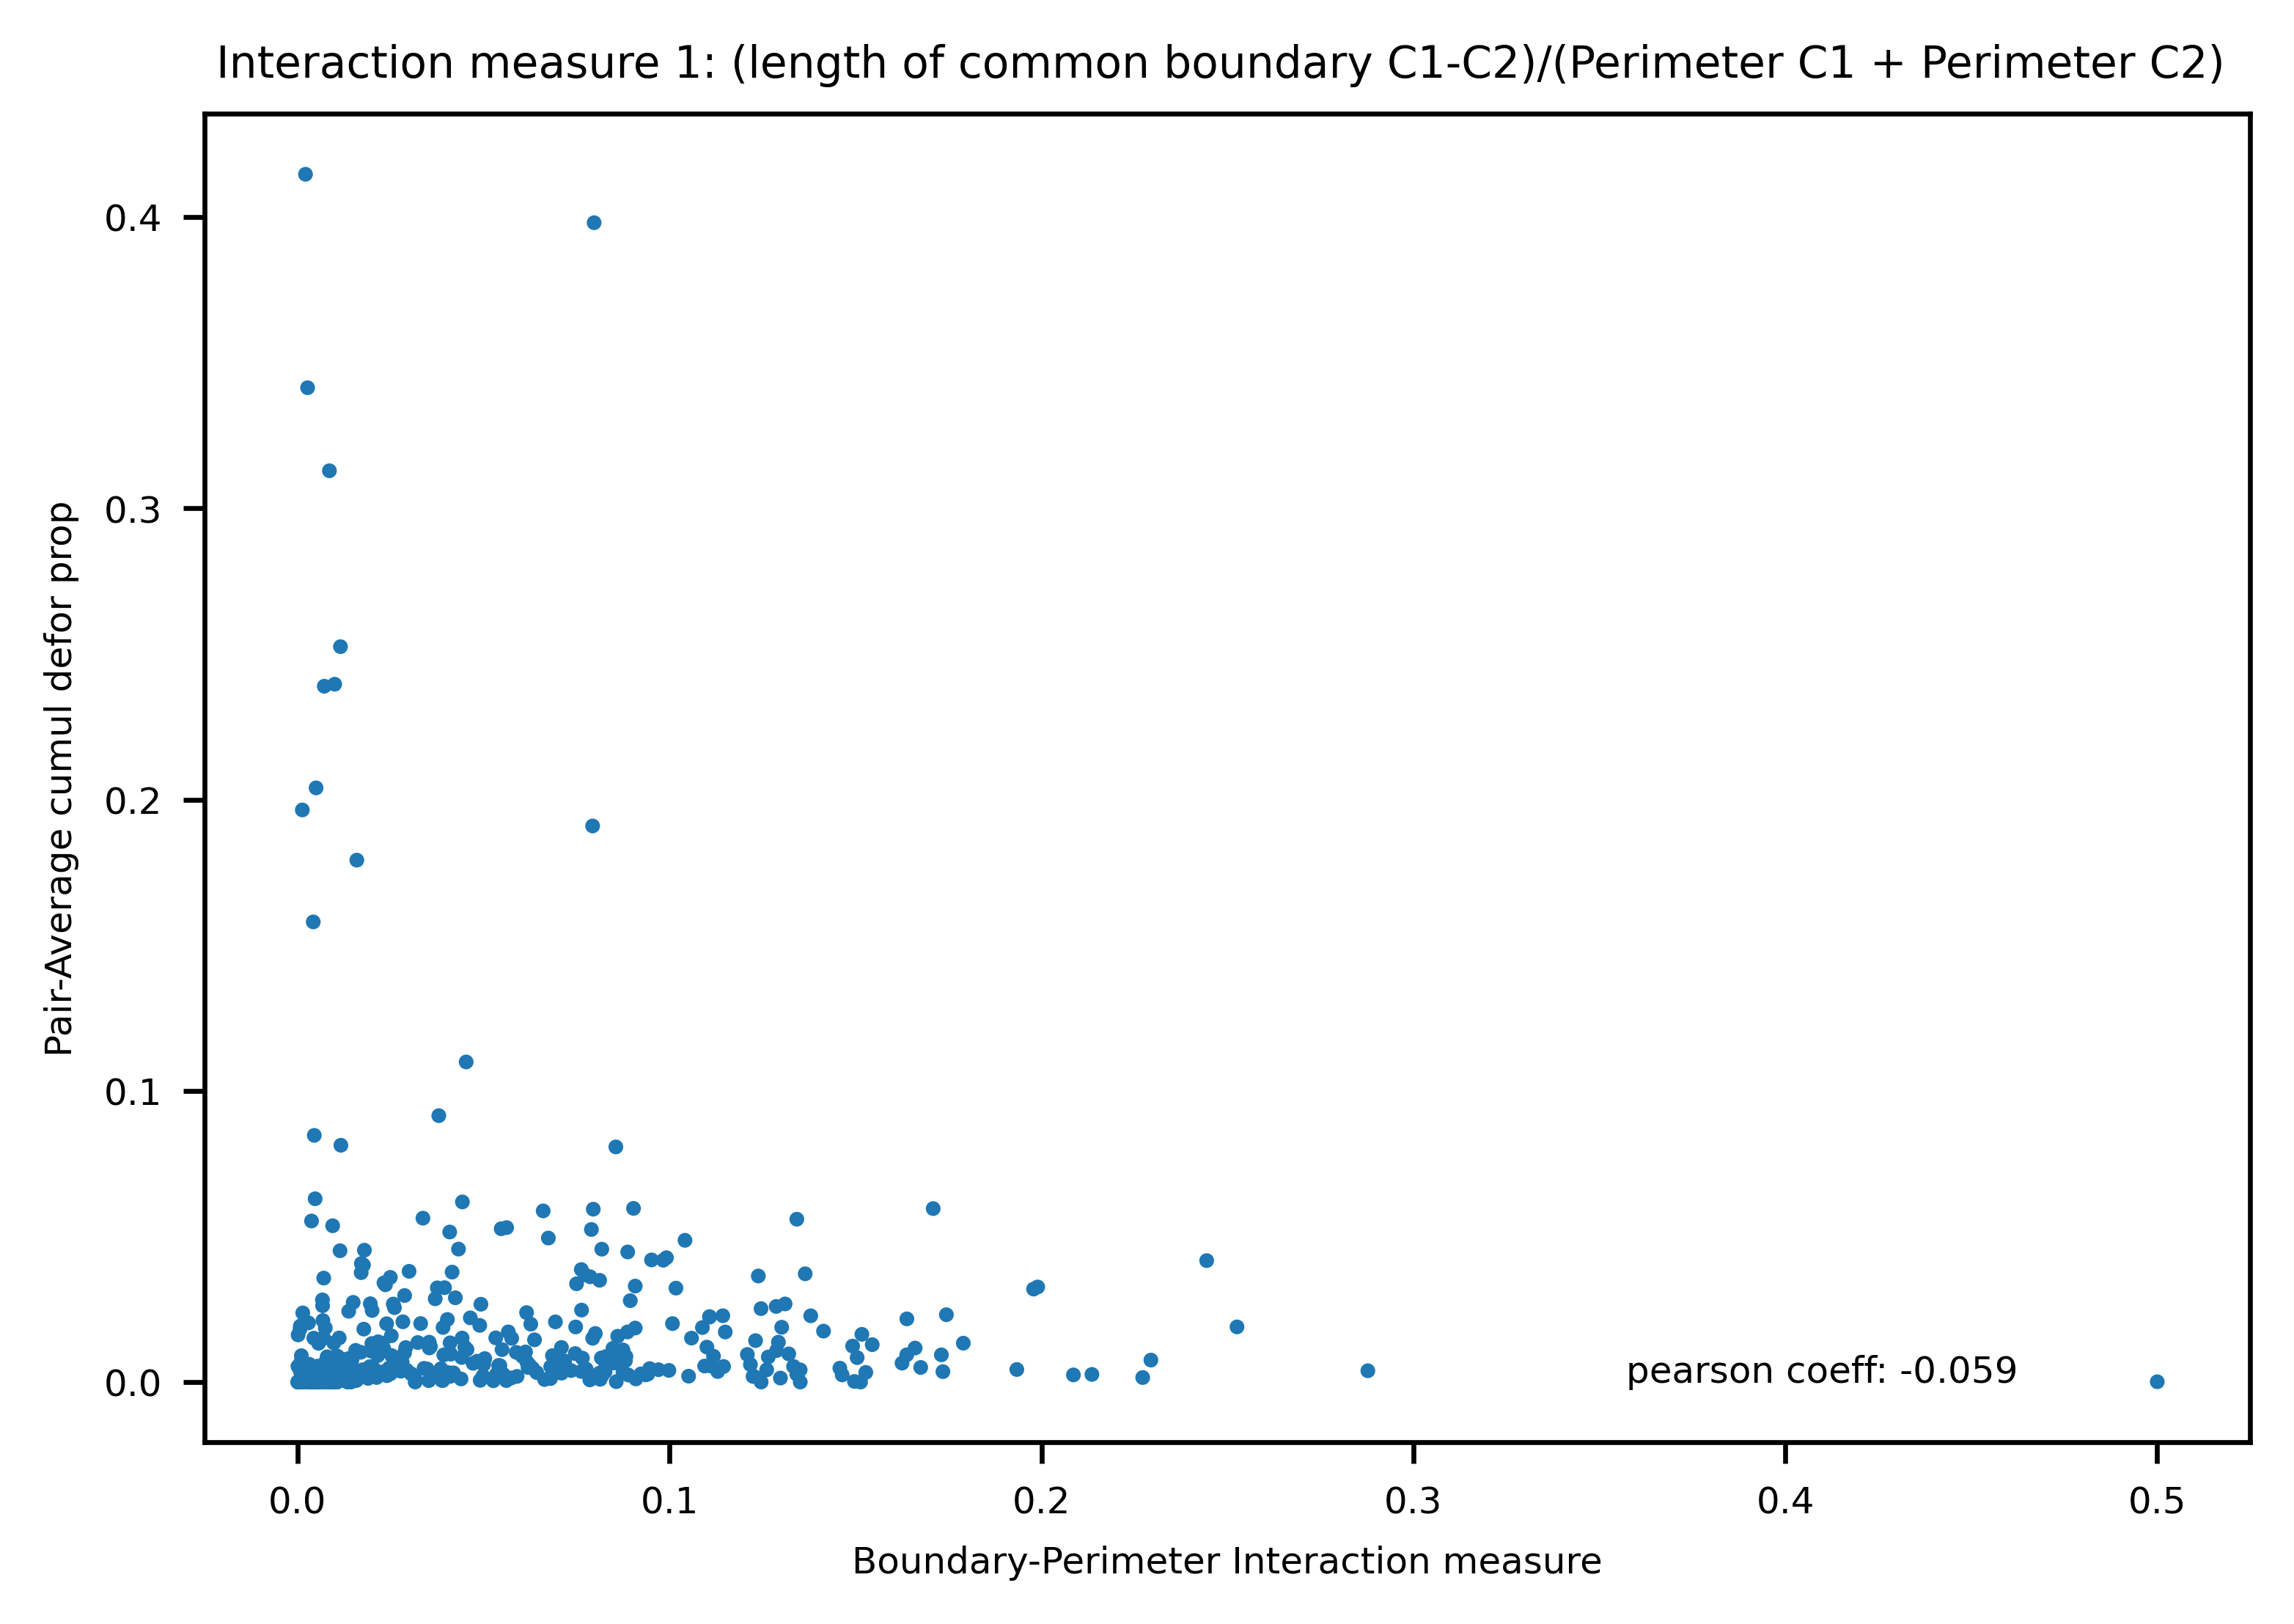

In [62]:
# date: 10/13

# plot results using mask to only look at adjacent concessions 
adj_only_mask = np.where(boundary_perim_measure > 0)
from scipy import stats
x = boundary_perim_measure[adj_only_mask]
y = pair_avg_deforcumulprop[adj_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 1: (length of common boundary C1-C2)/(Perimeter C1 + Perimeter C2) ")
plt.xlabel("Boundary-Perimeter Interaction measure")
plt.ylabel("Pair-Average cumul defor prop")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)

154846


Text(0.35714285714285715, 0, 'pearson coeff: -0.029')

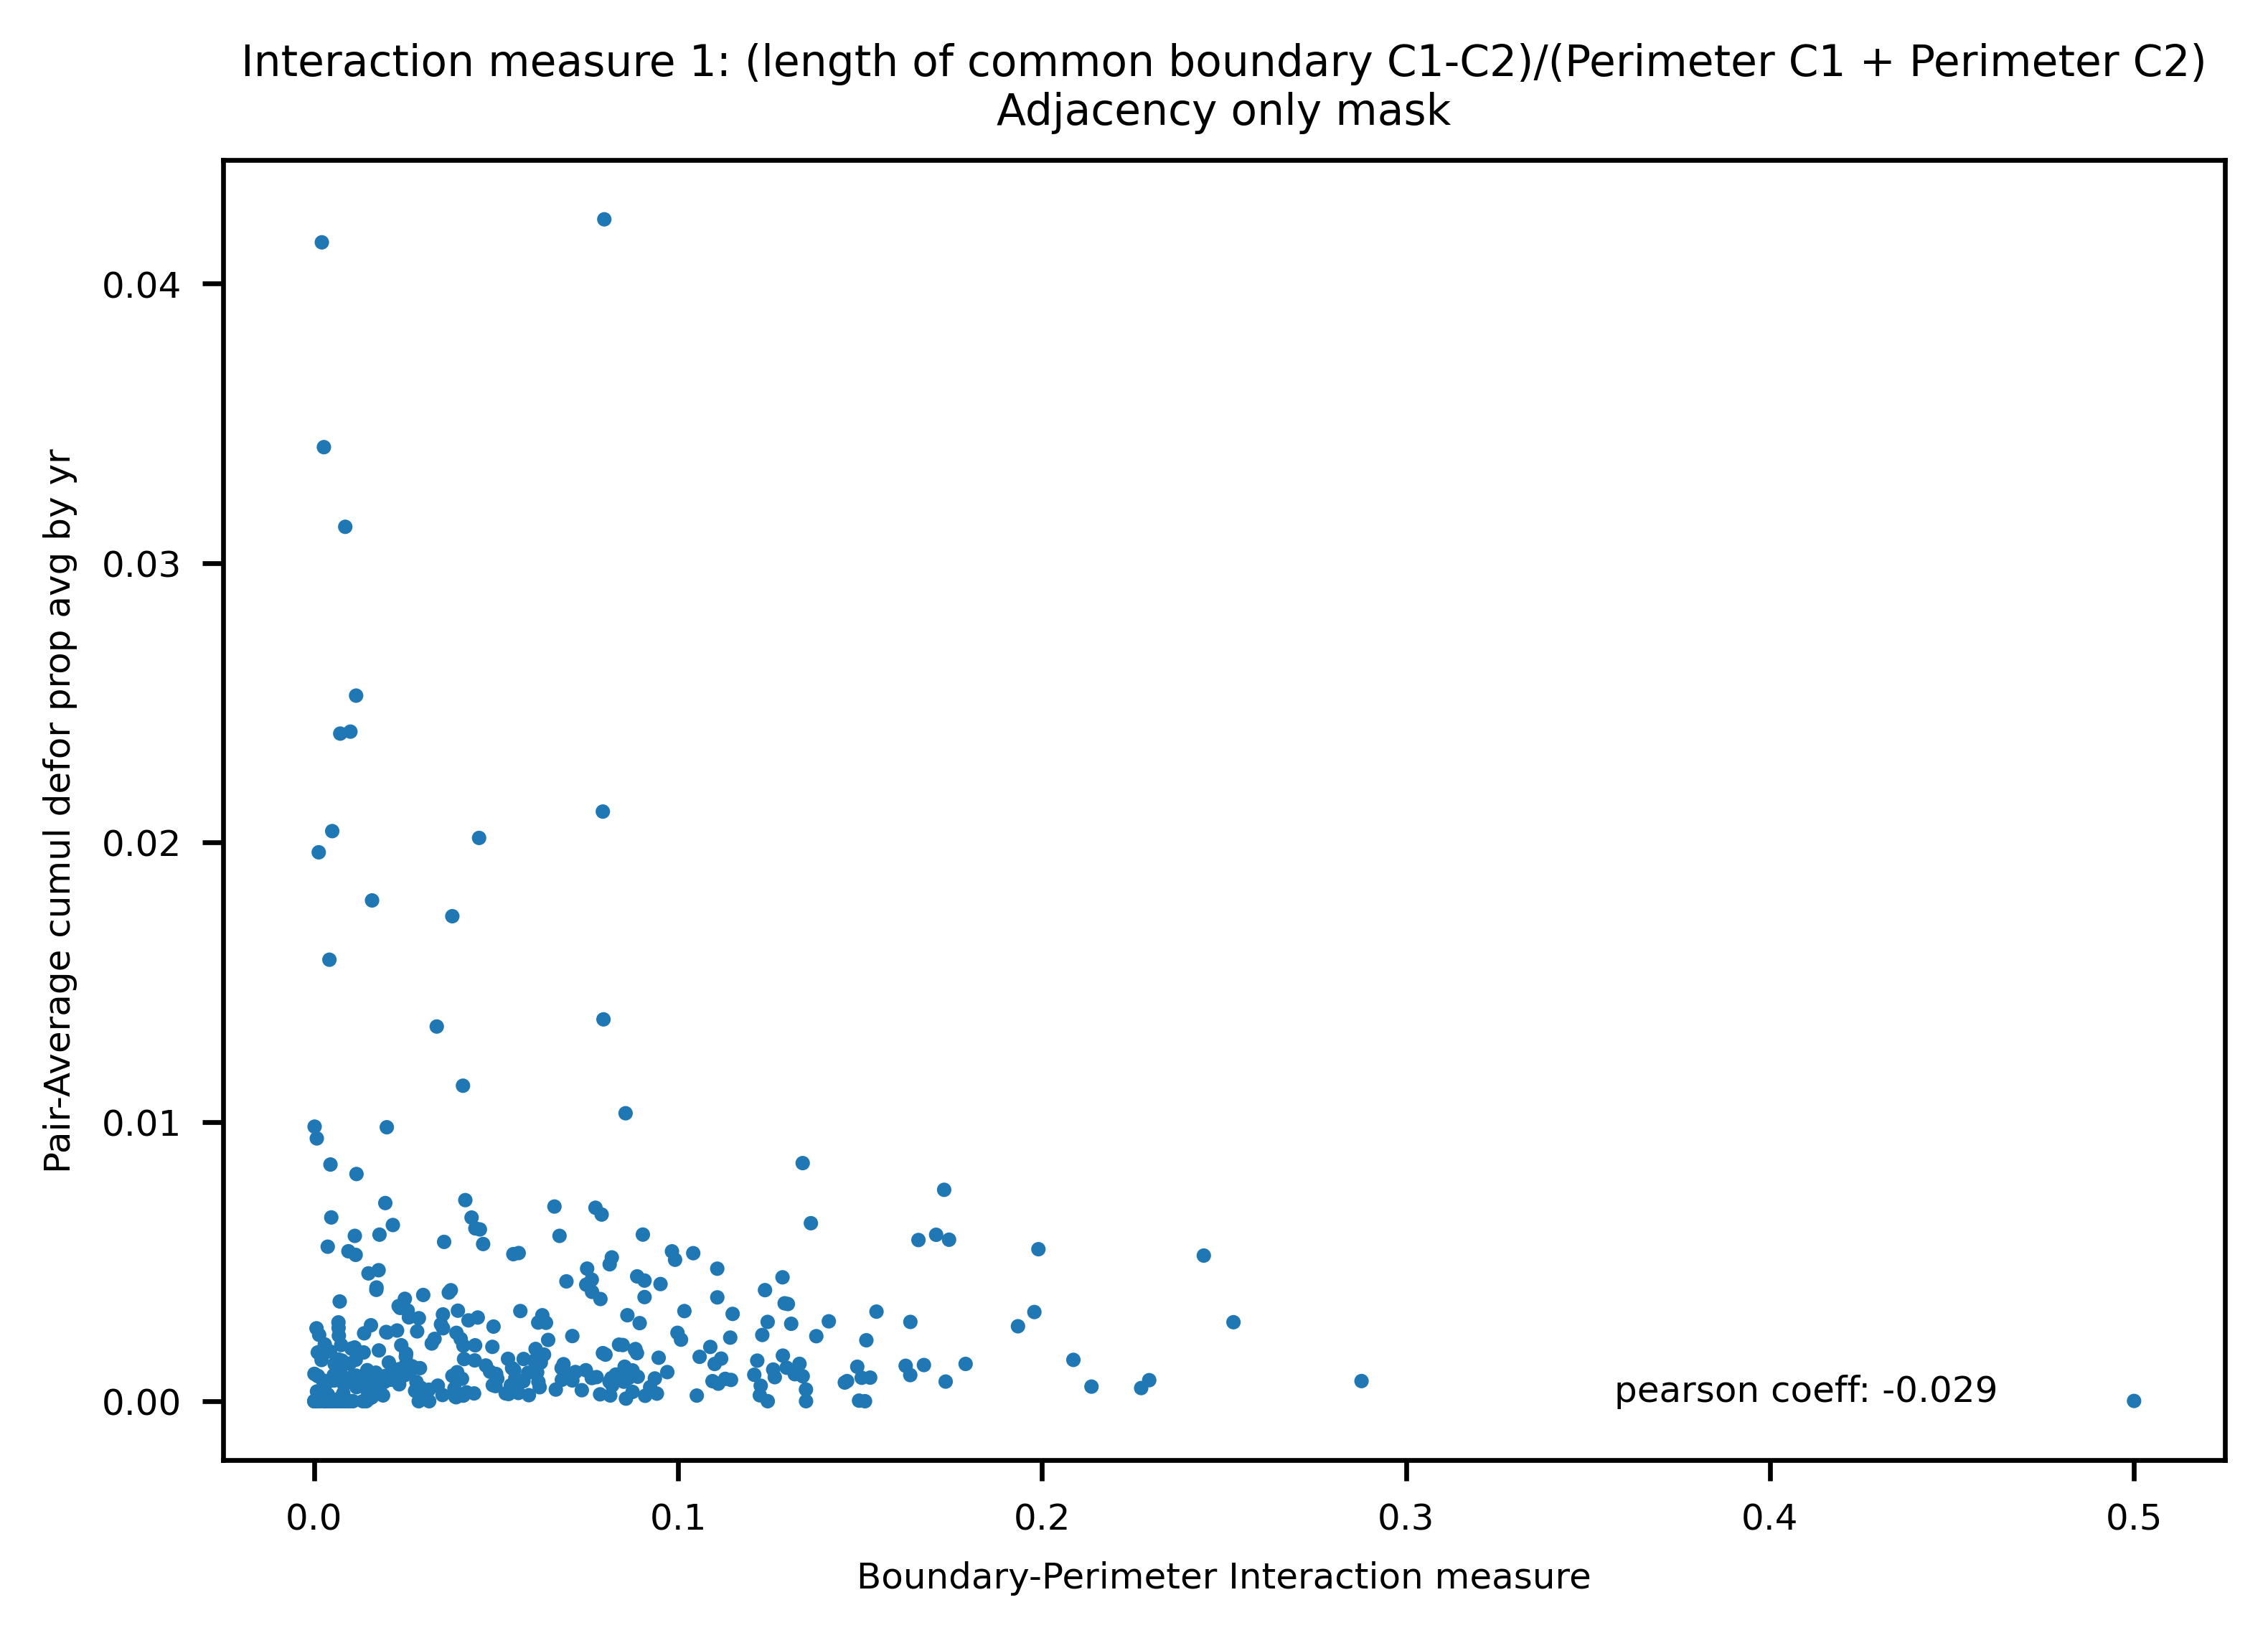

In [63]:
# date: 10/27

# same as above but using different deforestation measure on y-axis
# pair_avg_deforcumulpropavg = take average of the cumulative deofrestation proportion of C1 and C2
defor_cumul_prop_avg_arr = np.array([pd.read_csv("outputs/features_by_logging_concession.csv")['defor_cumul_prop_avg']])
pair_avg_deforcumulpropavg = (defor_cumul_prop_avg_arr + defor_cumul_prop_avg_arr.T)/2
pair_avg_deforcumulpropavg = convert_2darr_to_1darr_uppertri(pair_avg_deforcumulpropavg)
pair_avg_deforcumulpropavg = np.nan_to_num(pair_avg_deforcumulpropavg)

adj_only_mask = np.where(boundary_perim_measure > 0)
from scipy import stats
x = boundary_perim_measure[adj_only_mask]
y = pair_avg_deforcumulpropavg[adj_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 1: (length of common boundary C1-C2)/(Perimeter C1 + Perimeter C2)\nAdjacency only mask")
plt.xlabel("Boundary-Perimeter Interaction measure")
plt.ylabel("Pair-Average cumul defor prop avg by yr")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)

154846


Text(0.35714285714285715, 0, 'pearson coeff: 0.086')

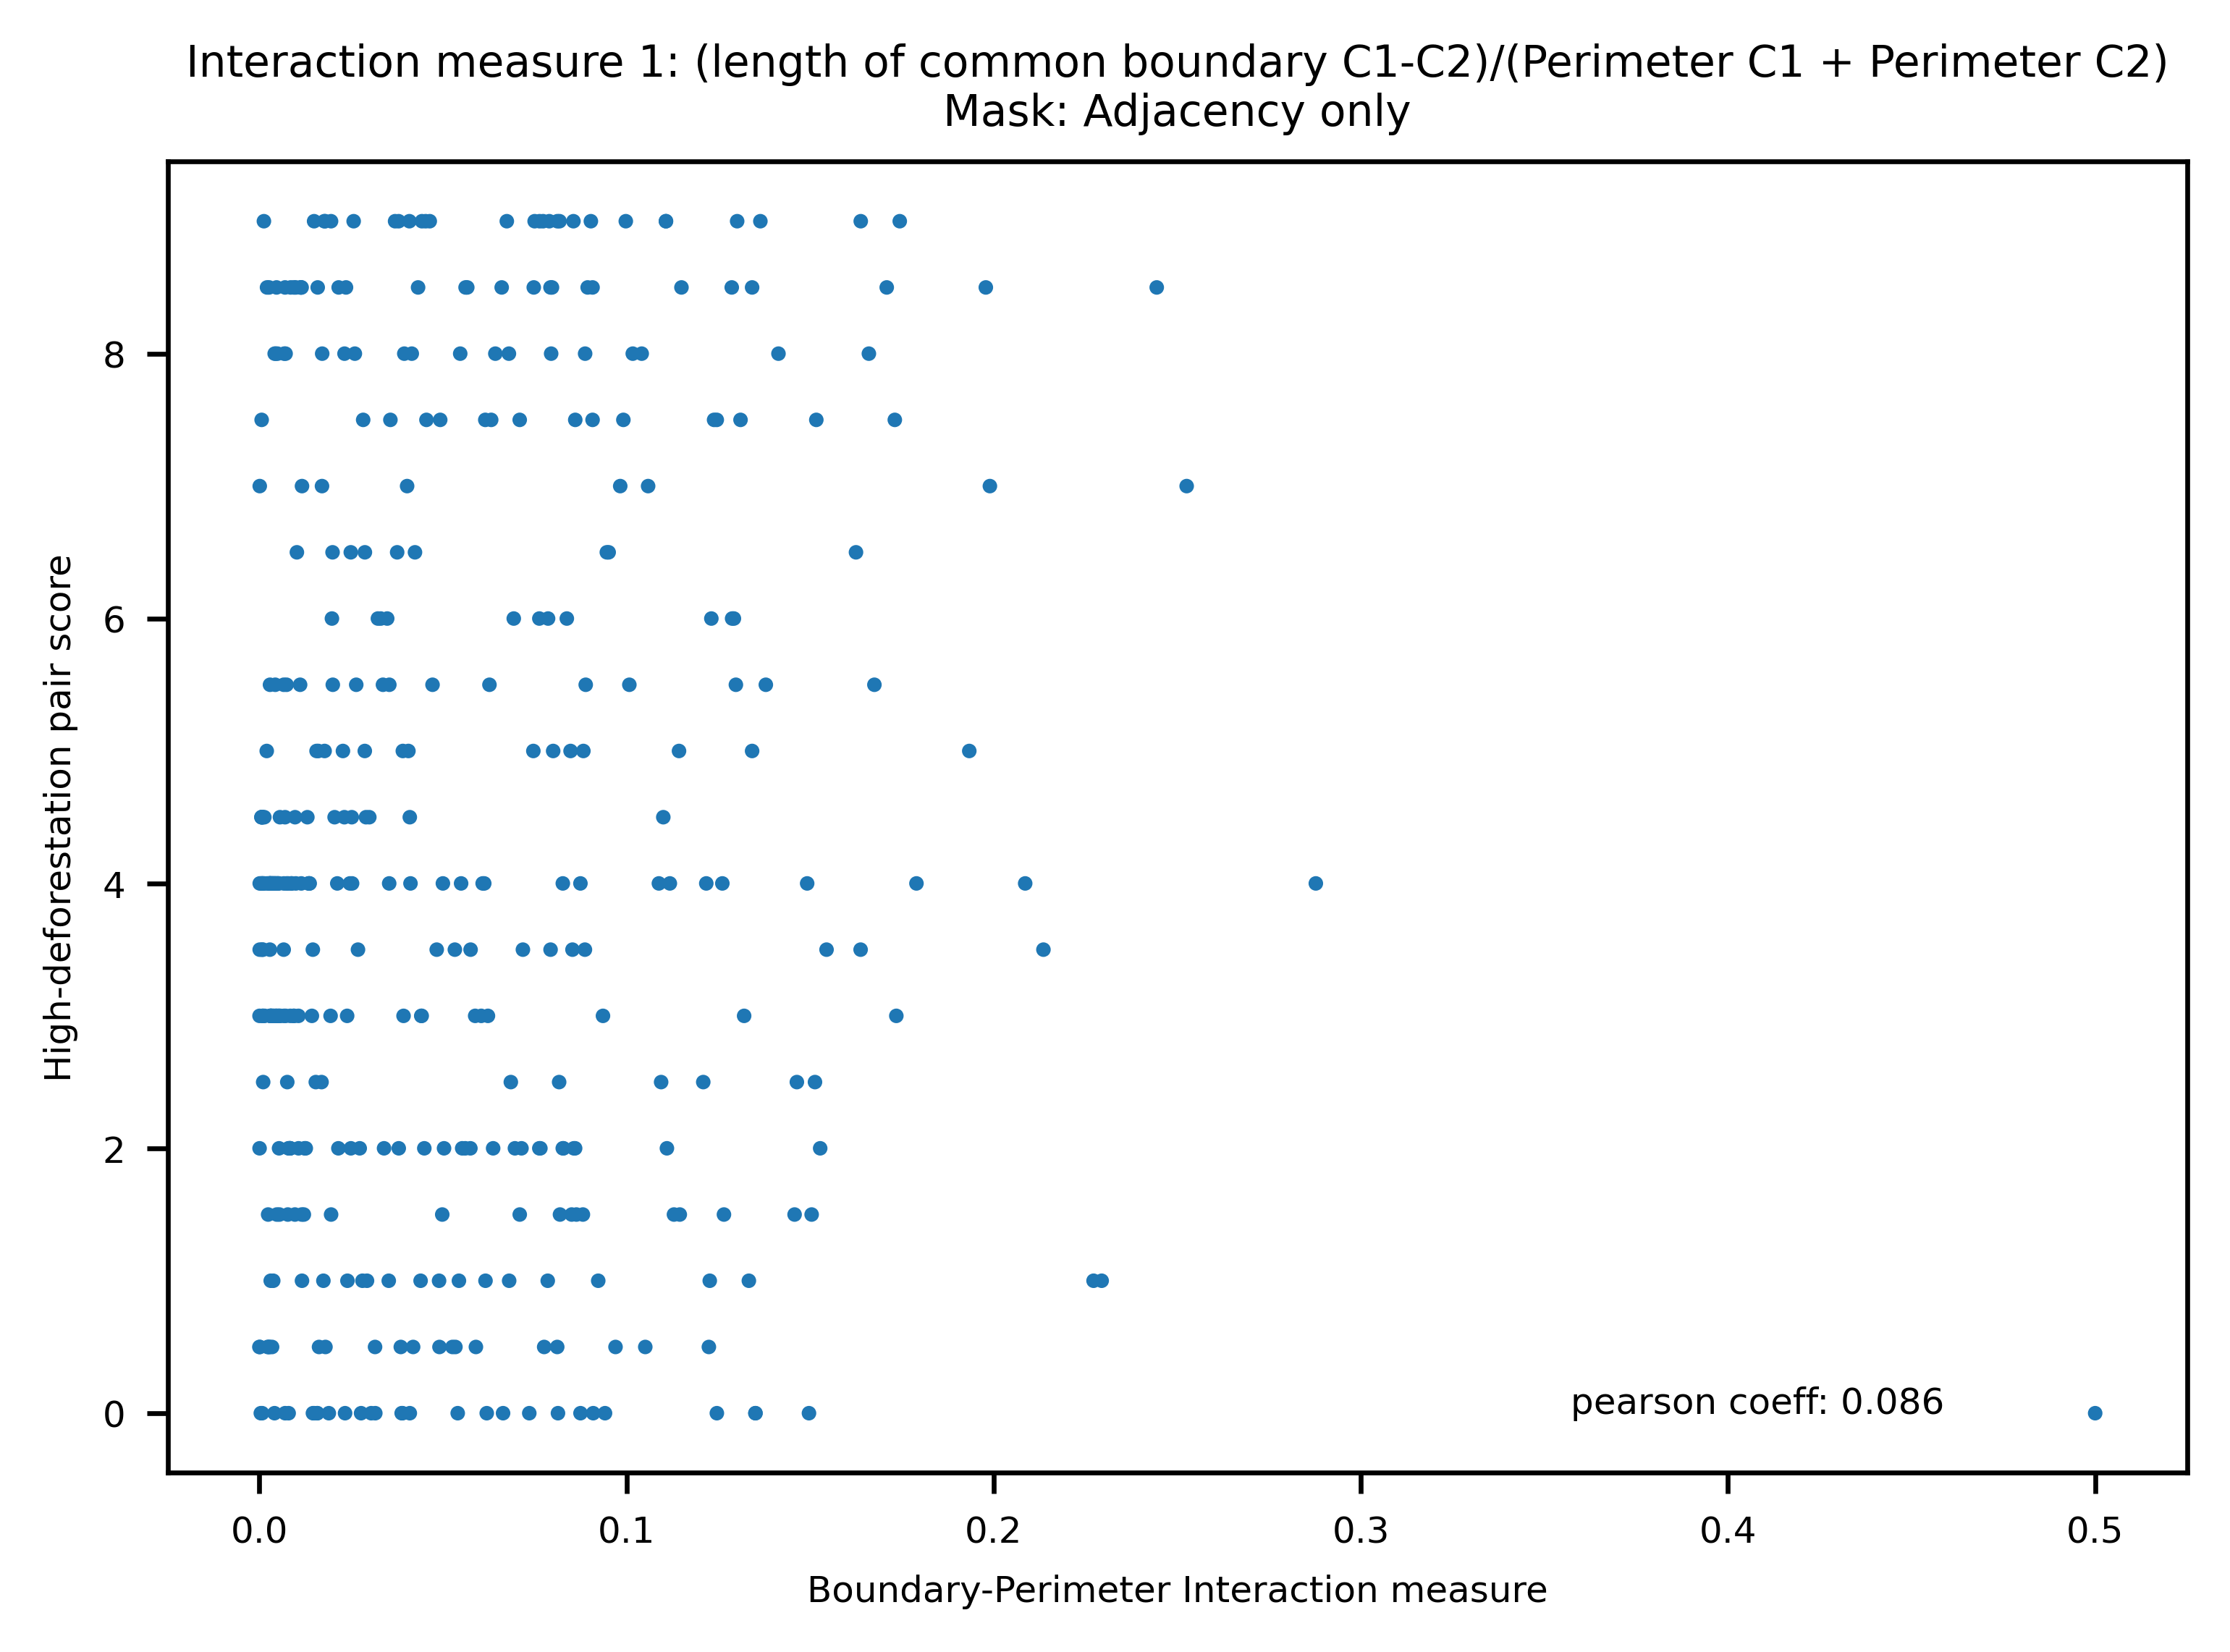

In [64]:
# date: 10/27

# pair_avg_deforcountover50p = take average of the number of years C1, C2 were considered above-median deforesters

count_over_50p_arr = np.array([pd.read_csv("outputs/features_by_logging_concession.csv")['count_over_50p']])
pair_avg_deforcountover50p = (count_over_50p_arr + count_over_50p_arr.T)/2
pair_avg_deforcountover50p = convert_2darr_to_1darr_uppertri(pair_avg_deforcountover50p)
pair_avg_deforcountover50p = np.nan_to_num(pair_avg_deforcountover50p)

adj_only_mask = np.where(boundary_perim_measure > 0)

from scipy import stats
x = boundary_perim_measure[adj_only_mask]
y = pair_avg_deforcountover50p[adj_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 1: (length of common boundary C1-C2)/(Perimeter C1 + Perimeter C2)\nMask: Adjacency only")
plt.xlabel("Boundary-Perimeter Interaction measure")
plt.ylabel("High-deforestation pair score")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)

154846


Text(0.35714285714285715, 0, 'pearson coeff: 0.036')

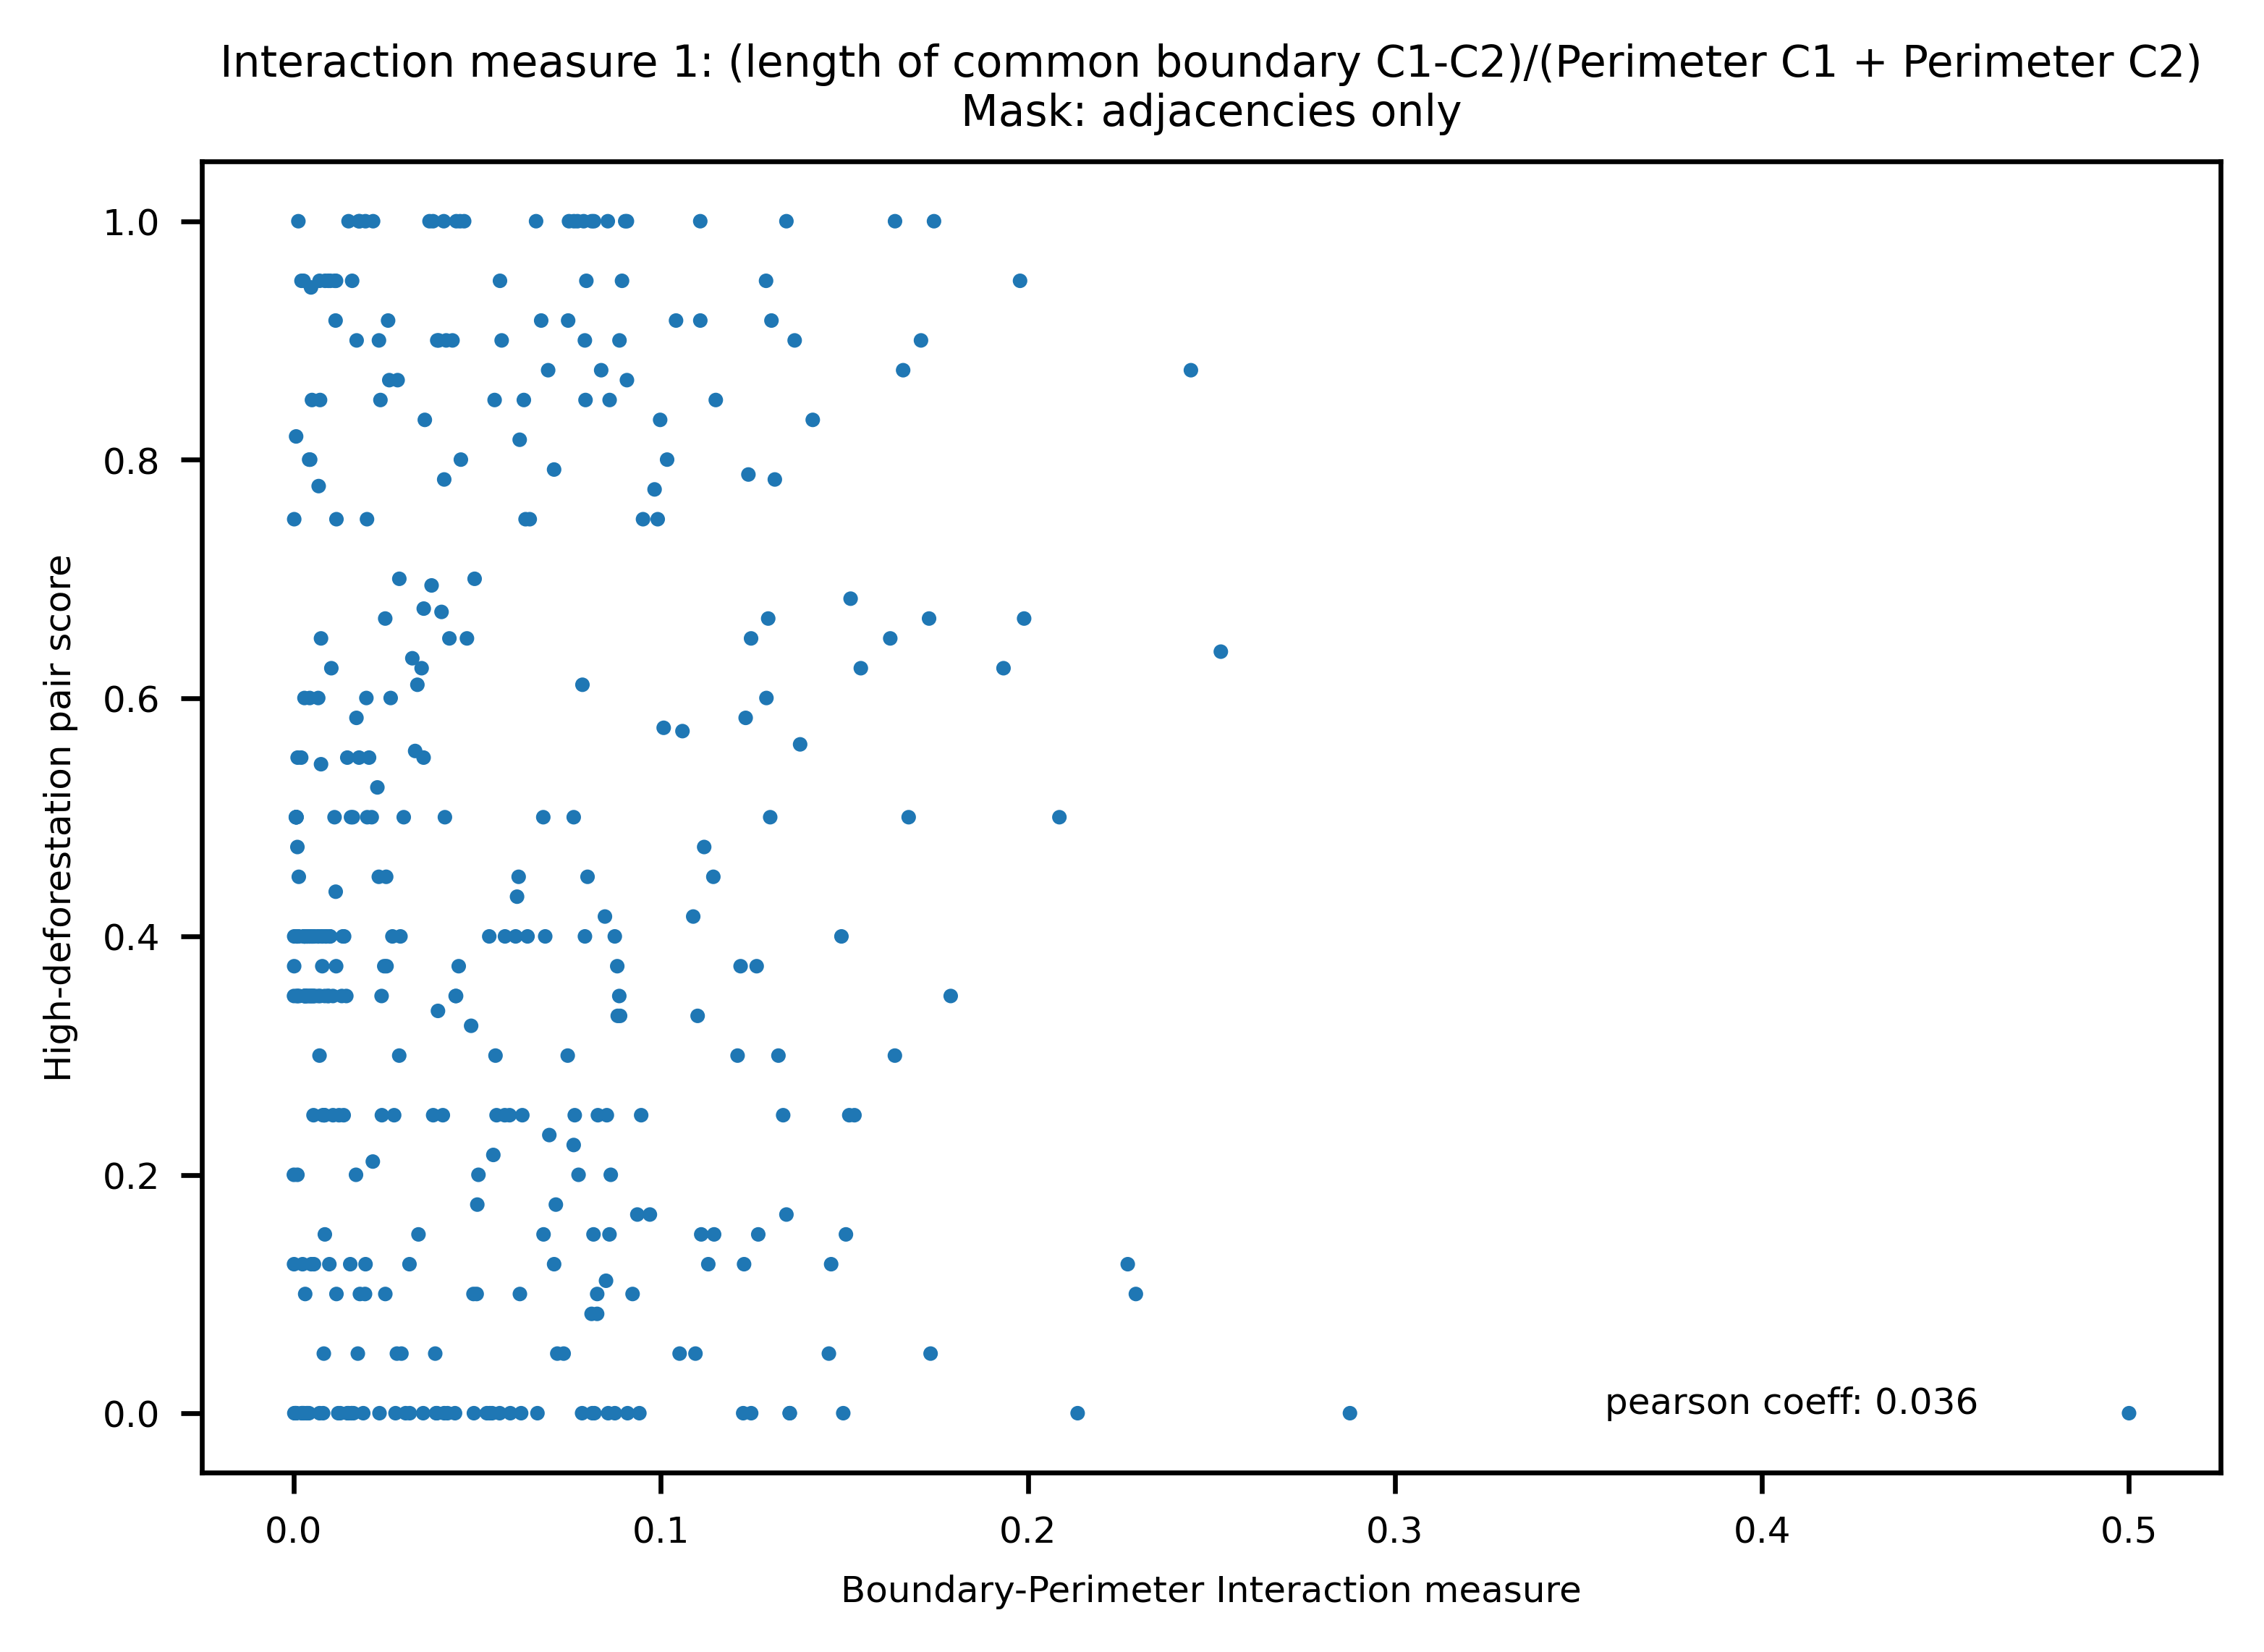

In [84]:
# date: 11/8
# same as above but y-axis rescaled to 0-1

# standardized 50p
over_50p_normed_arr = np.array([pd.read_csv("outputs/features_by_logging_concession.csv")['normed_high_defor_indic']])

# take average of pair
pair_avg_defor_normed_over50p = (over_50p_normed_arr + over_50p_normed_arr.T)/2

# OR take max of pair
# pair_avg_defor_normed_over50p = np.maximum(over_50p_normed_arr, over_50p_normed_arr.T)

pair_avg_defor_normed_over50p = convert_2darr_to_1darr_uppertri(pair_avg_defor_normed_over50p)
pair_avg_defor_normed_over50p = np.nan_to_num(pair_avg_defor_normed_over50p)

x = boundary_perim_measure[adj_only_mask]
y = pair_avg_defor_normed_over50p[adj_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 1: (length of common boundary C1-C2)/(Perimeter C1 + Perimeter C2)\nMask: adjacencies only")
plt.xlabel("Boundary-Perimeter Interaction measure")
plt.ylabel("High-deforestation pair score")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)

154846


Text(0.35714285714285715, 0, 'pearson coeff: -0.176')

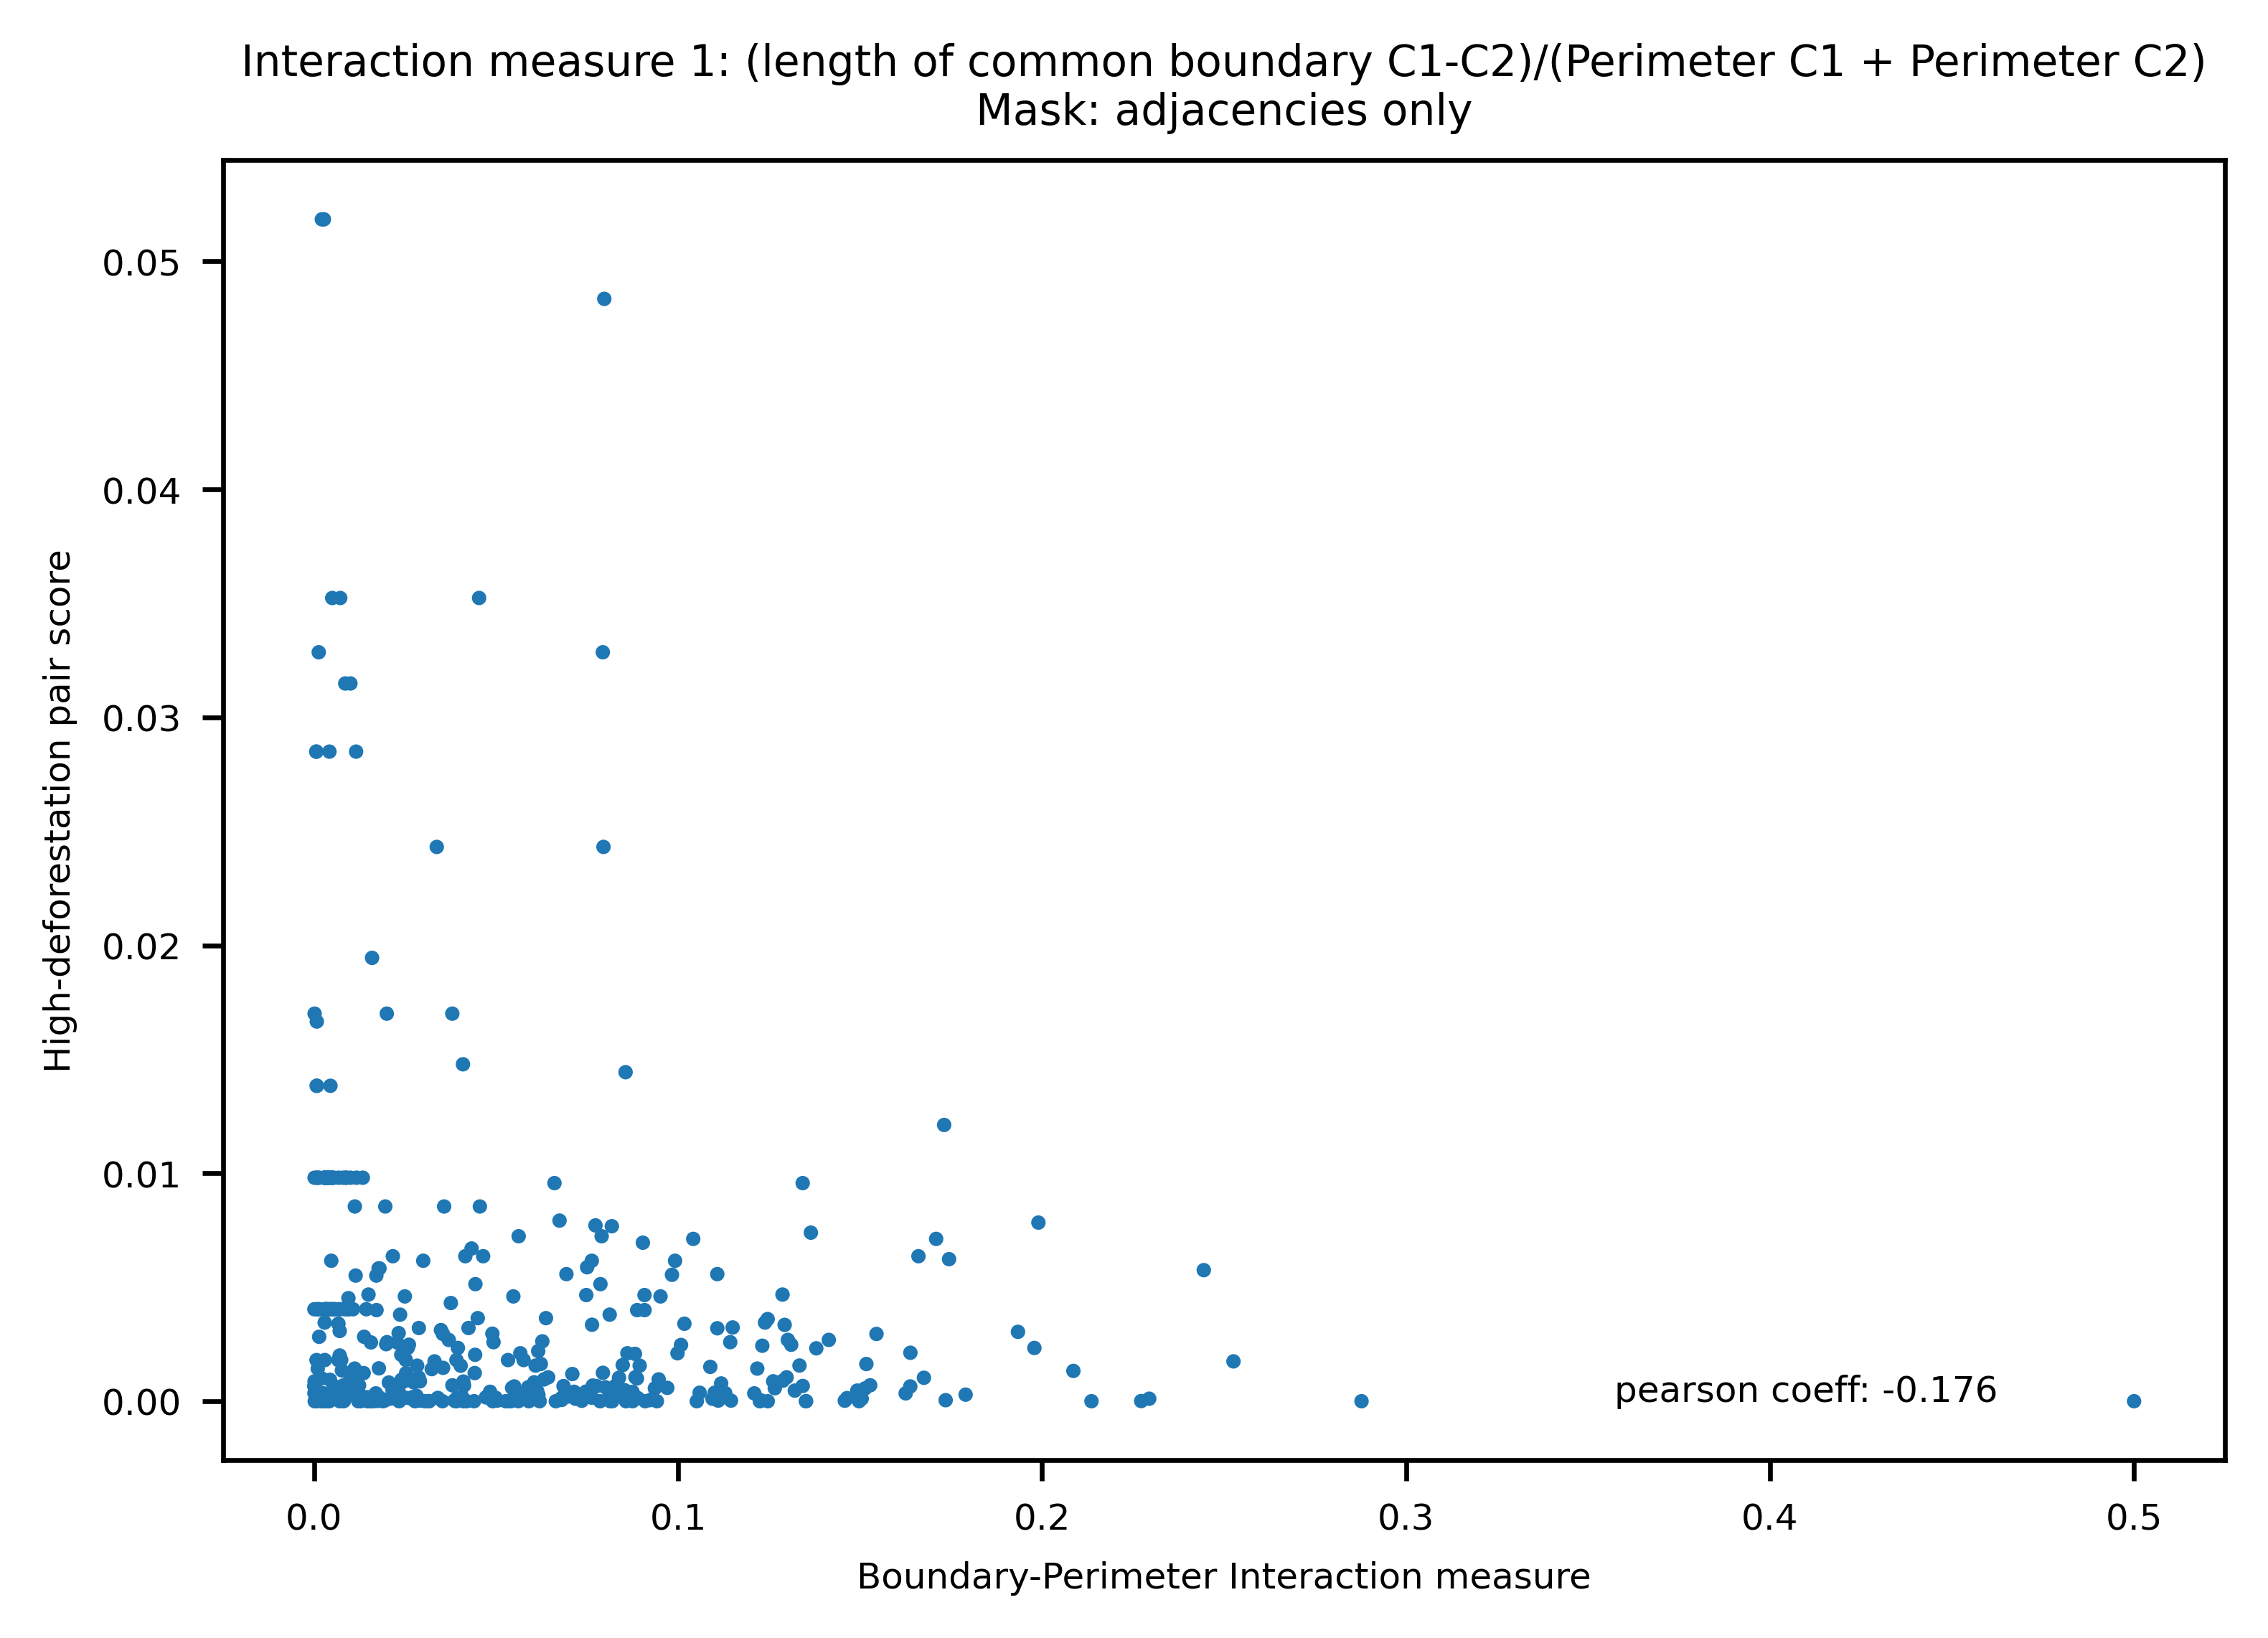

In [66]:
# same as cell 21 but USES ALTERNATE: normed_high_defor_indic_quantitative on the y-axis
# standardized 50p
# over_50p_normed_arr = np.array([pd.read_csv("outputs/features_by_logging_concession.csv")['normed_high_defor_indic']])
over_50p_normed_arr = np.array([pd.read_csv("outputs/features_by_logging_concession.csv")['normed_high_defor_indic_quantitative']])

pair_avg_defor_normed_over50p = np.maximum(over_50p_normed_arr, over_50p_normed_arr.T)#(over_50p_normed_arr + over_50p_normed_arr.T)/2
pair_avg_defor_normed_over50p = convert_2darr_to_1darr_uppertri(pair_avg_defor_normed_over50p)
pair_avg_defor_normed_over50p = np.nan_to_num(pair_avg_defor_normed_over50p)

x = boundary_perim_measure[adj_only_mask]
y = pair_avg_defor_normed_over50p[adj_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 1: (length of common boundary C1-C2)/(Perimeter C1 + Perimeter C2)\nMask: adjacencies only")
plt.xlabel("Boundary-Perimeter Interaction measure")
plt.ylabel("High-deforestation pair score")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)

# Interaction measure 3
score for concessions C1, C2 = (Area C1 + Area C2)/(distance between centroids of C1 and C2)

In [67]:
# pairwise sum of geom areas
areas_arr = np.array([gdf.loc[:, "geometry"].length]) # shape (1, 557)
areas_sum_arr = areas_arr +  areas_arr.T # shape (557, 557)

In [68]:
# interaction measure 3: distance between all pairs of centroids
pair_centroid_dist_mat = []
centroids = np.array([polygon.centroid for polygon in gdf.loc[:, "geometry"]])
for c1 in centroids:
    row  = [c1.distance(c2) for c2 in centroids] # distance btwn c1 and every other centroid
    pair_centroid_dist_mat.append(row)
pair_centroid_dist_mat = np.array(pair_centroid_dist_mat)

C:\Users\szhan\AppData\Local\Temp\ipykernel_16164\3819952064.py:3: FutureWarning: The input object of type 'Point' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Point', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  centroids = np.array([polygon.centroid for polygon in gdf.loc[:, "geometry"]])
C:\Users\szhan\AppData\Local\Temp\ipykernel_16164\3819952064.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centroids = np.array([polygon.centroid for polygon in gdf.loc[:, 

In [69]:
# boundary-perim interaction measure as defined above
area_dist_measure = areas_sum_arr / pair_centroid_dist_mat
area_dist_squared_measure = areas_sum_arr / (pair_centroid_dist_mat ** 2) # dimensionless

C:\Users\szhan\AppData\Local\Temp\ipykernel_16164\483095338.py:2: RuntimeWarning: divide by zero encountered in true_divide
  area_dist_measure = areas_sum_arr / pair_centroid_dist_mat
C:\Users\szhan\AppData\Local\Temp\ipykernel_16164\483095338.py:3: RuntimeWarning: divide by zero encountered in true_divide
  area_dist_squared_measure = areas_sum_arr / (pair_centroid_dist_mat ** 2) # dimensionless


In [70]:
area_dist_measure = np.nan_to_num(convert_2darr_to_1darr_uppertri(area_dist_measure), copy=True, posinf = 75) # 
area_only_measure = np.nan_to_num(convert_2darr_to_1darr_uppertri(areas_sum_arr), copy=True)
centroid_dist_only_measure = np.nan_to_num(convert_2darr_to_1darr_uppertri(1/pair_centroid_dist_mat), copy=True)
area_dist_squared_measure = np.nan_to_num(convert_2darr_to_1darr_uppertri(area_dist_squared_measure), copy=True, posinf = 75) # 

154846
154846
154846
154846


C:\Users\szhan\AppData\Local\Temp\ipykernel_16164\1868812809.py:3: RuntimeWarning: divide by zero encountered in true_divide
  centroid_dist_only_measure = np.nan_to_num(convert_2darr_to_1darr_uppertri(1/pair_centroid_dist_mat), copy=True)


In [71]:
print(area_dist_measure[:5])
print(pair_avg_deforcumulprop[:5])

[3.92311925 2.6919452  5.38415877 3.43632202 1.23726394]
[0.0028667  0.00261385 0.00707284 0.00340115 0.0094674 ]


Text(53.57142857142857, 0, 'pearson coeff: 0.006')

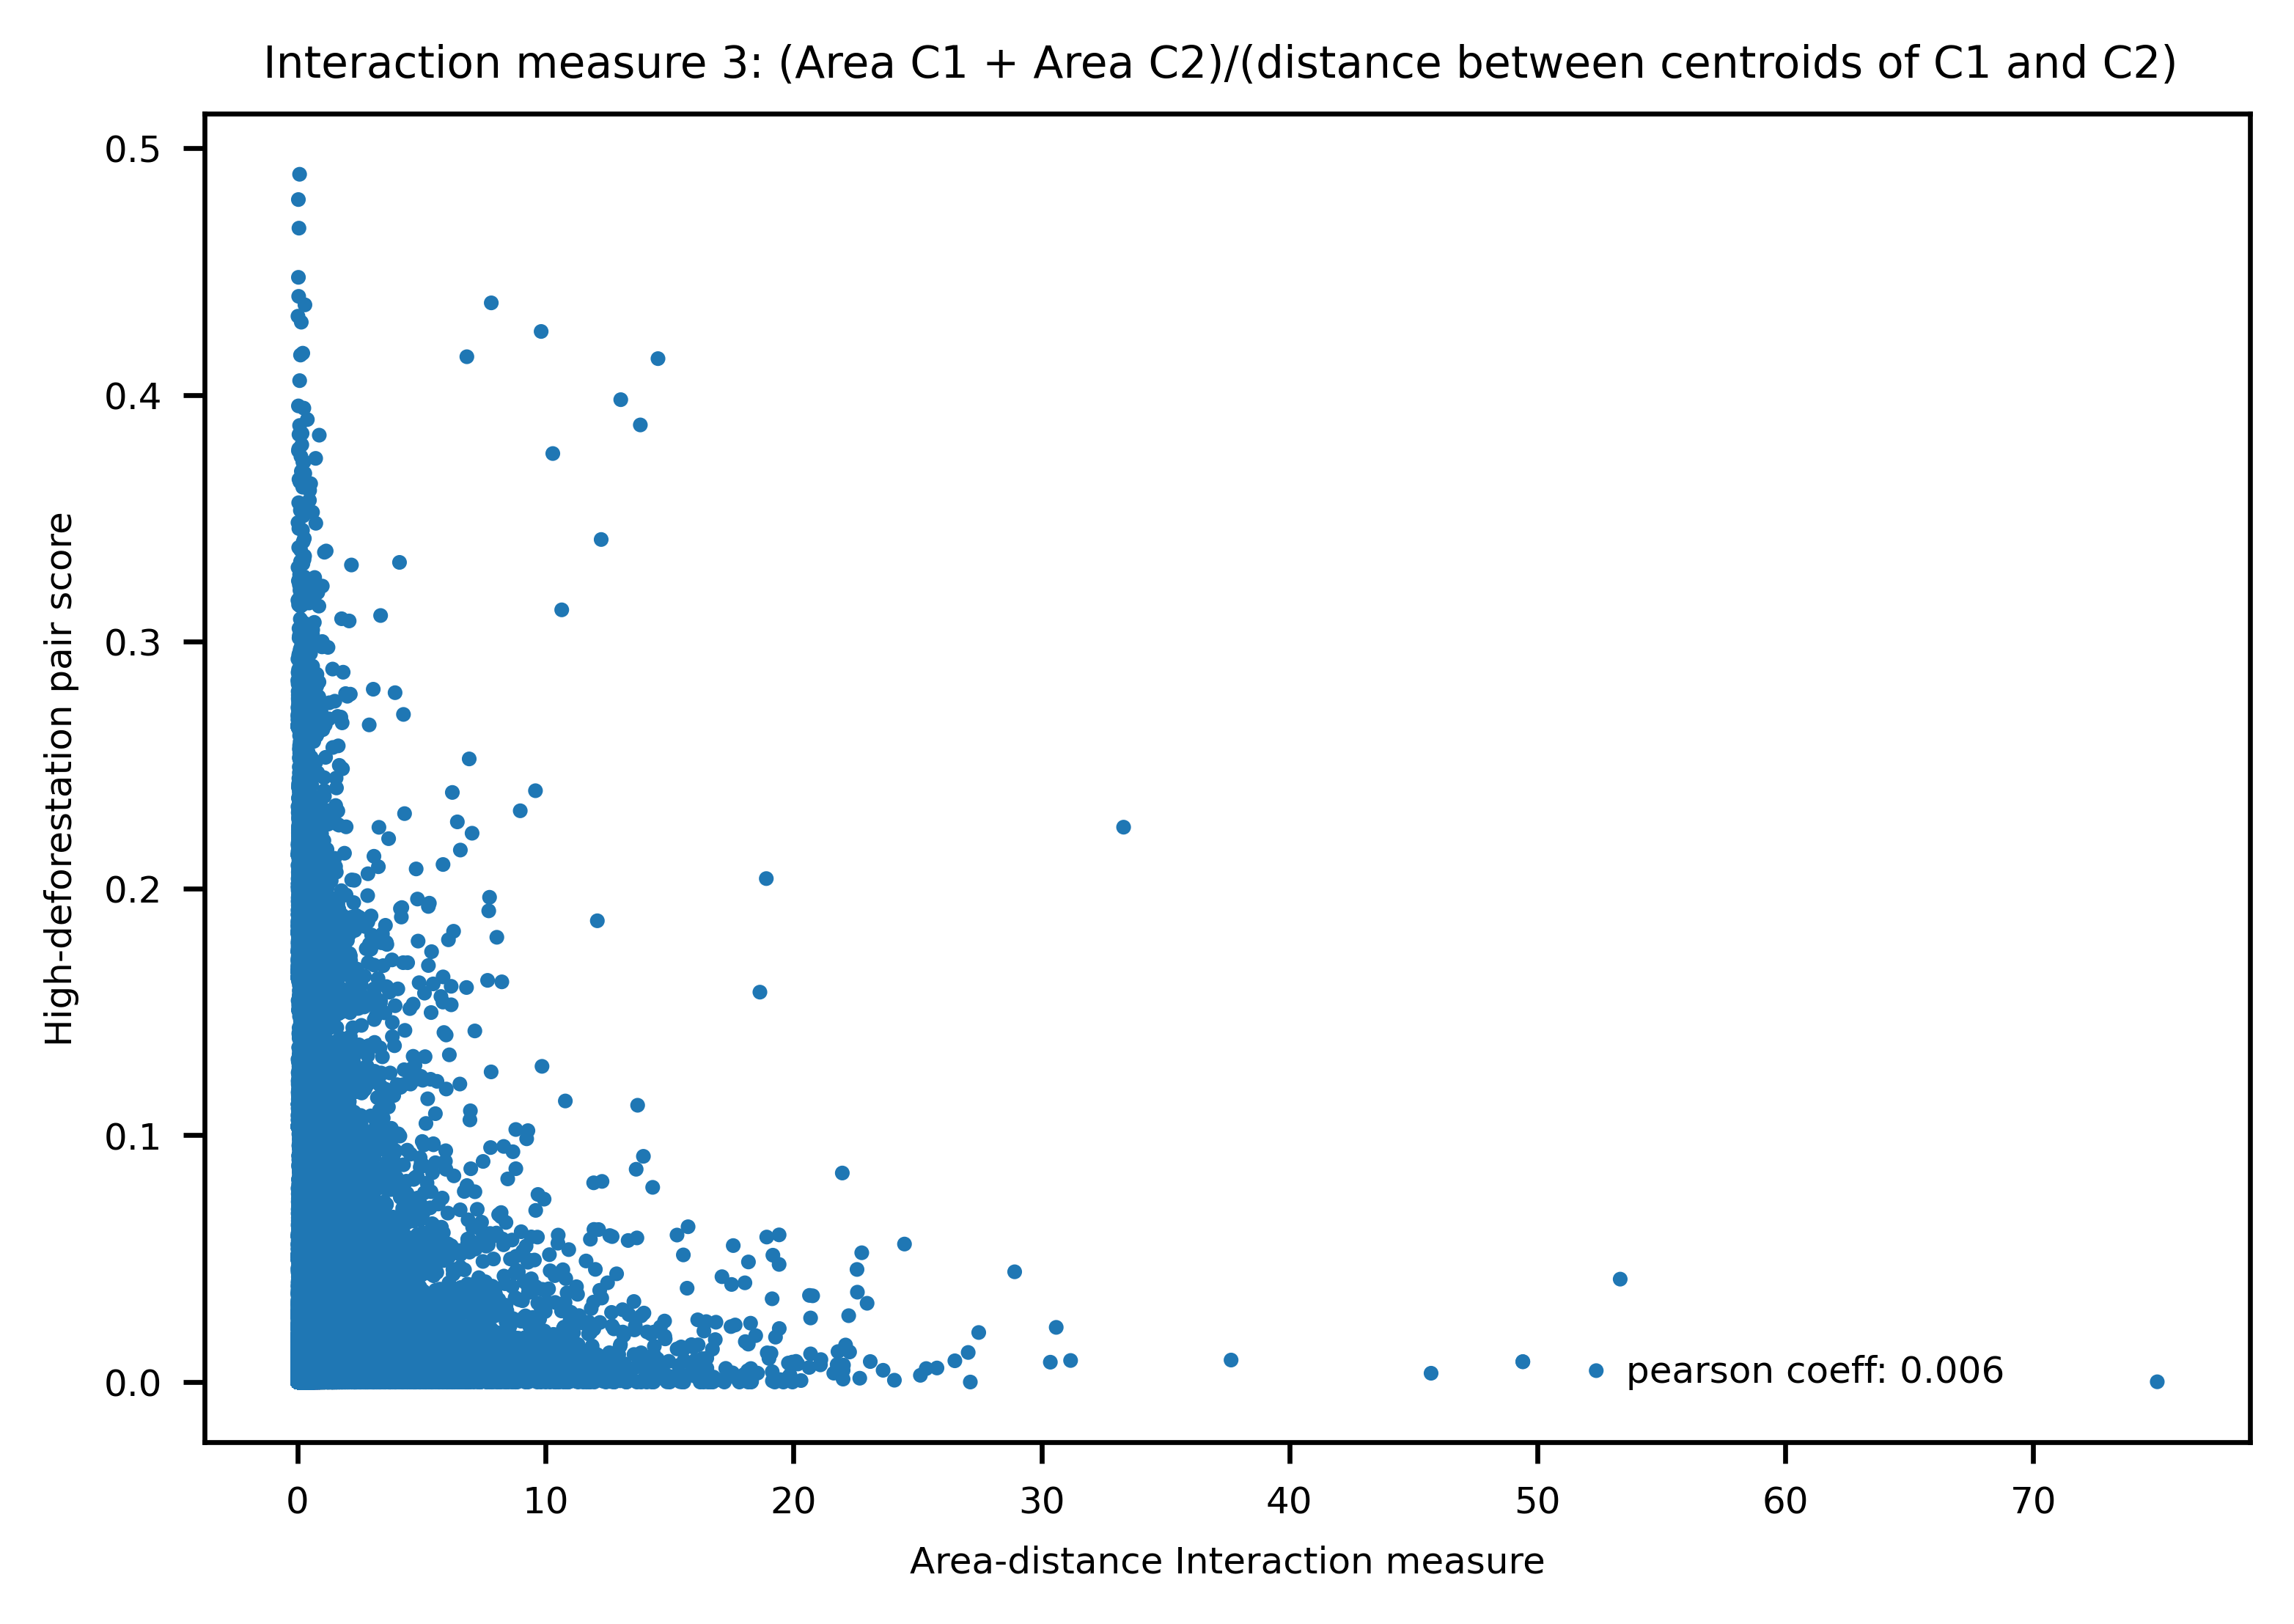

In [72]:
# date: 10/13
# plot 
from scipy import stats
high_defor_only_mask = np.where(pair_avg_deforcumulprop > 0.1)
x = area_dist_measure#[high_defor_only_mask]
y = pair_avg_deforcumulprop#[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2) ")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("average cumulative proportional deforestation pair score")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)
# plt.show()

Text(53.57142857142857, 0, 'pearson coeff: 0.014')

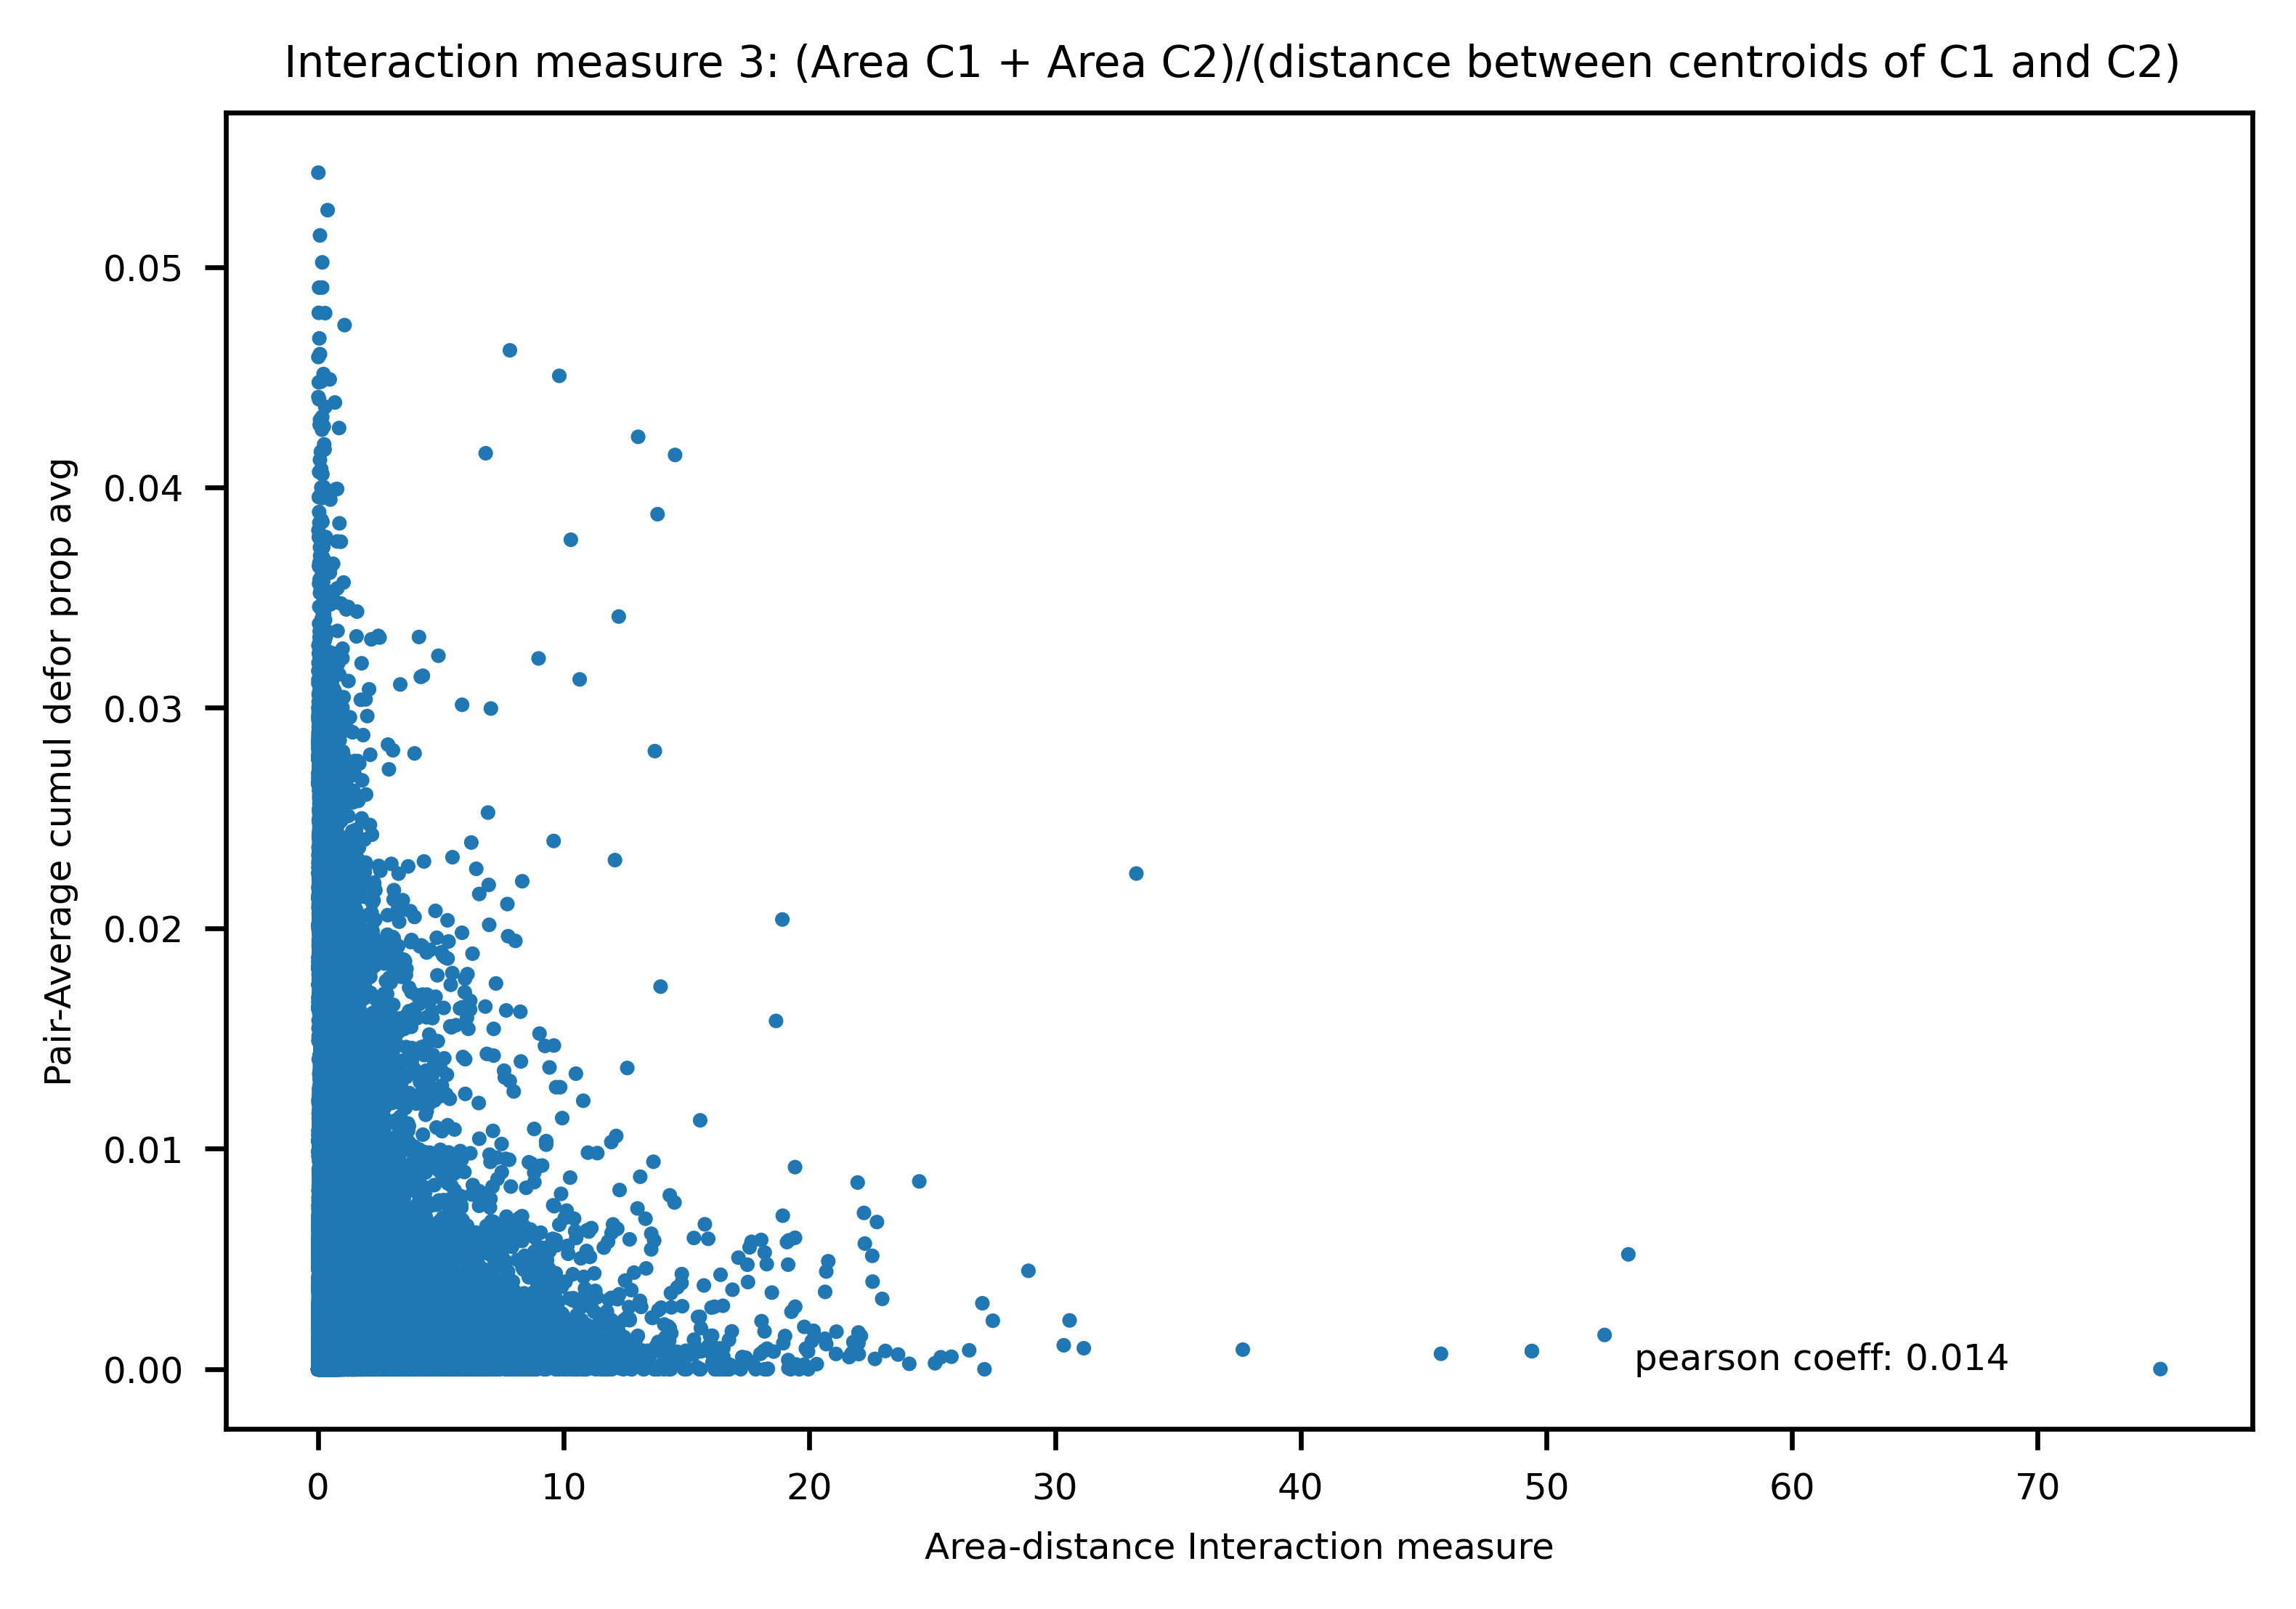

In [73]:
# date: 10/27

# plot using diff y-axis
from scipy import stats
high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.1)
x = area_dist_measure#[high_defor_only_mask]
y = pair_avg_deforcumulpropavg#[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2) ")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("Pair-Average cumul defor prop avg")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)
# plt.show()

Text(53.57142857142857, 0, 'pearson coeff: -0.016')

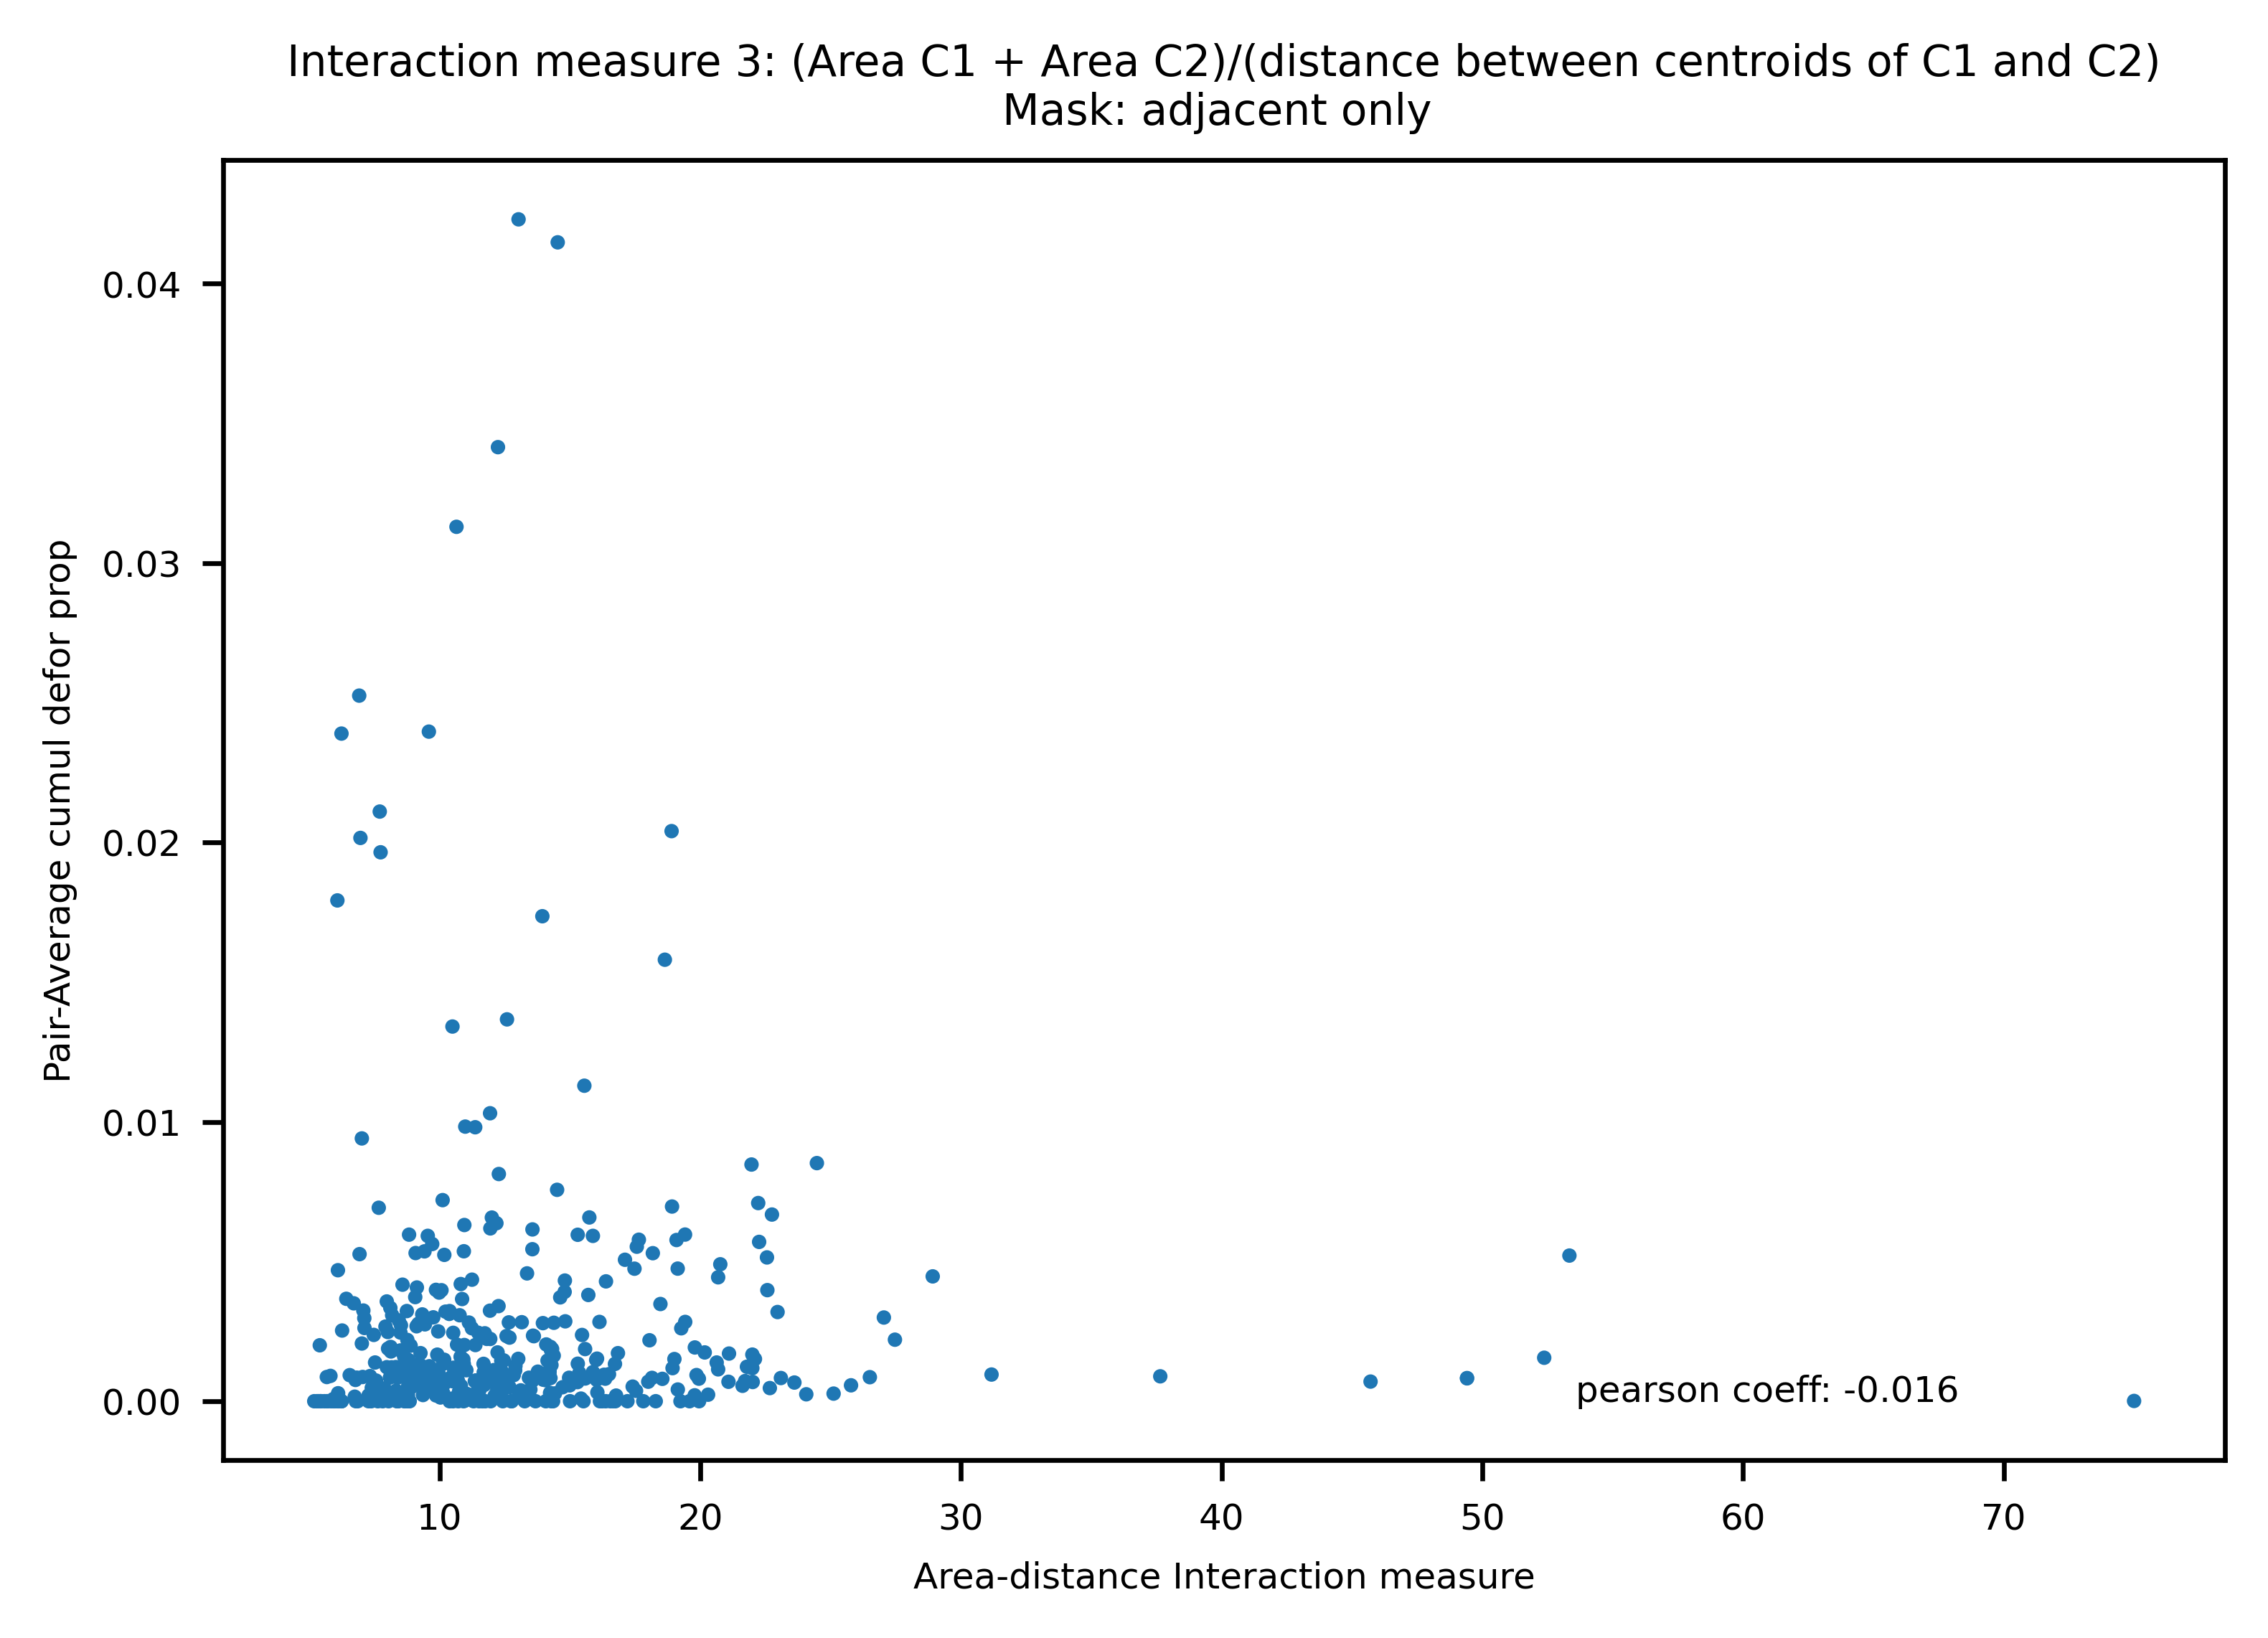

In [74]:
# 10/27
# plot mask for only adjacent concessions
from scipy import stats
adj_only_mask = np.where(boundary_perim_measure > 0)
x = area_dist_measure[adj_only_mask]
y = pair_avg_deforcumulpropavg[adj_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2)\nMask: adjacent only ")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("Pair-Average cumul defor prop")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)
# plt.show()

Text(53.57142857142857, 0, 'pearson coeff: 0.074')

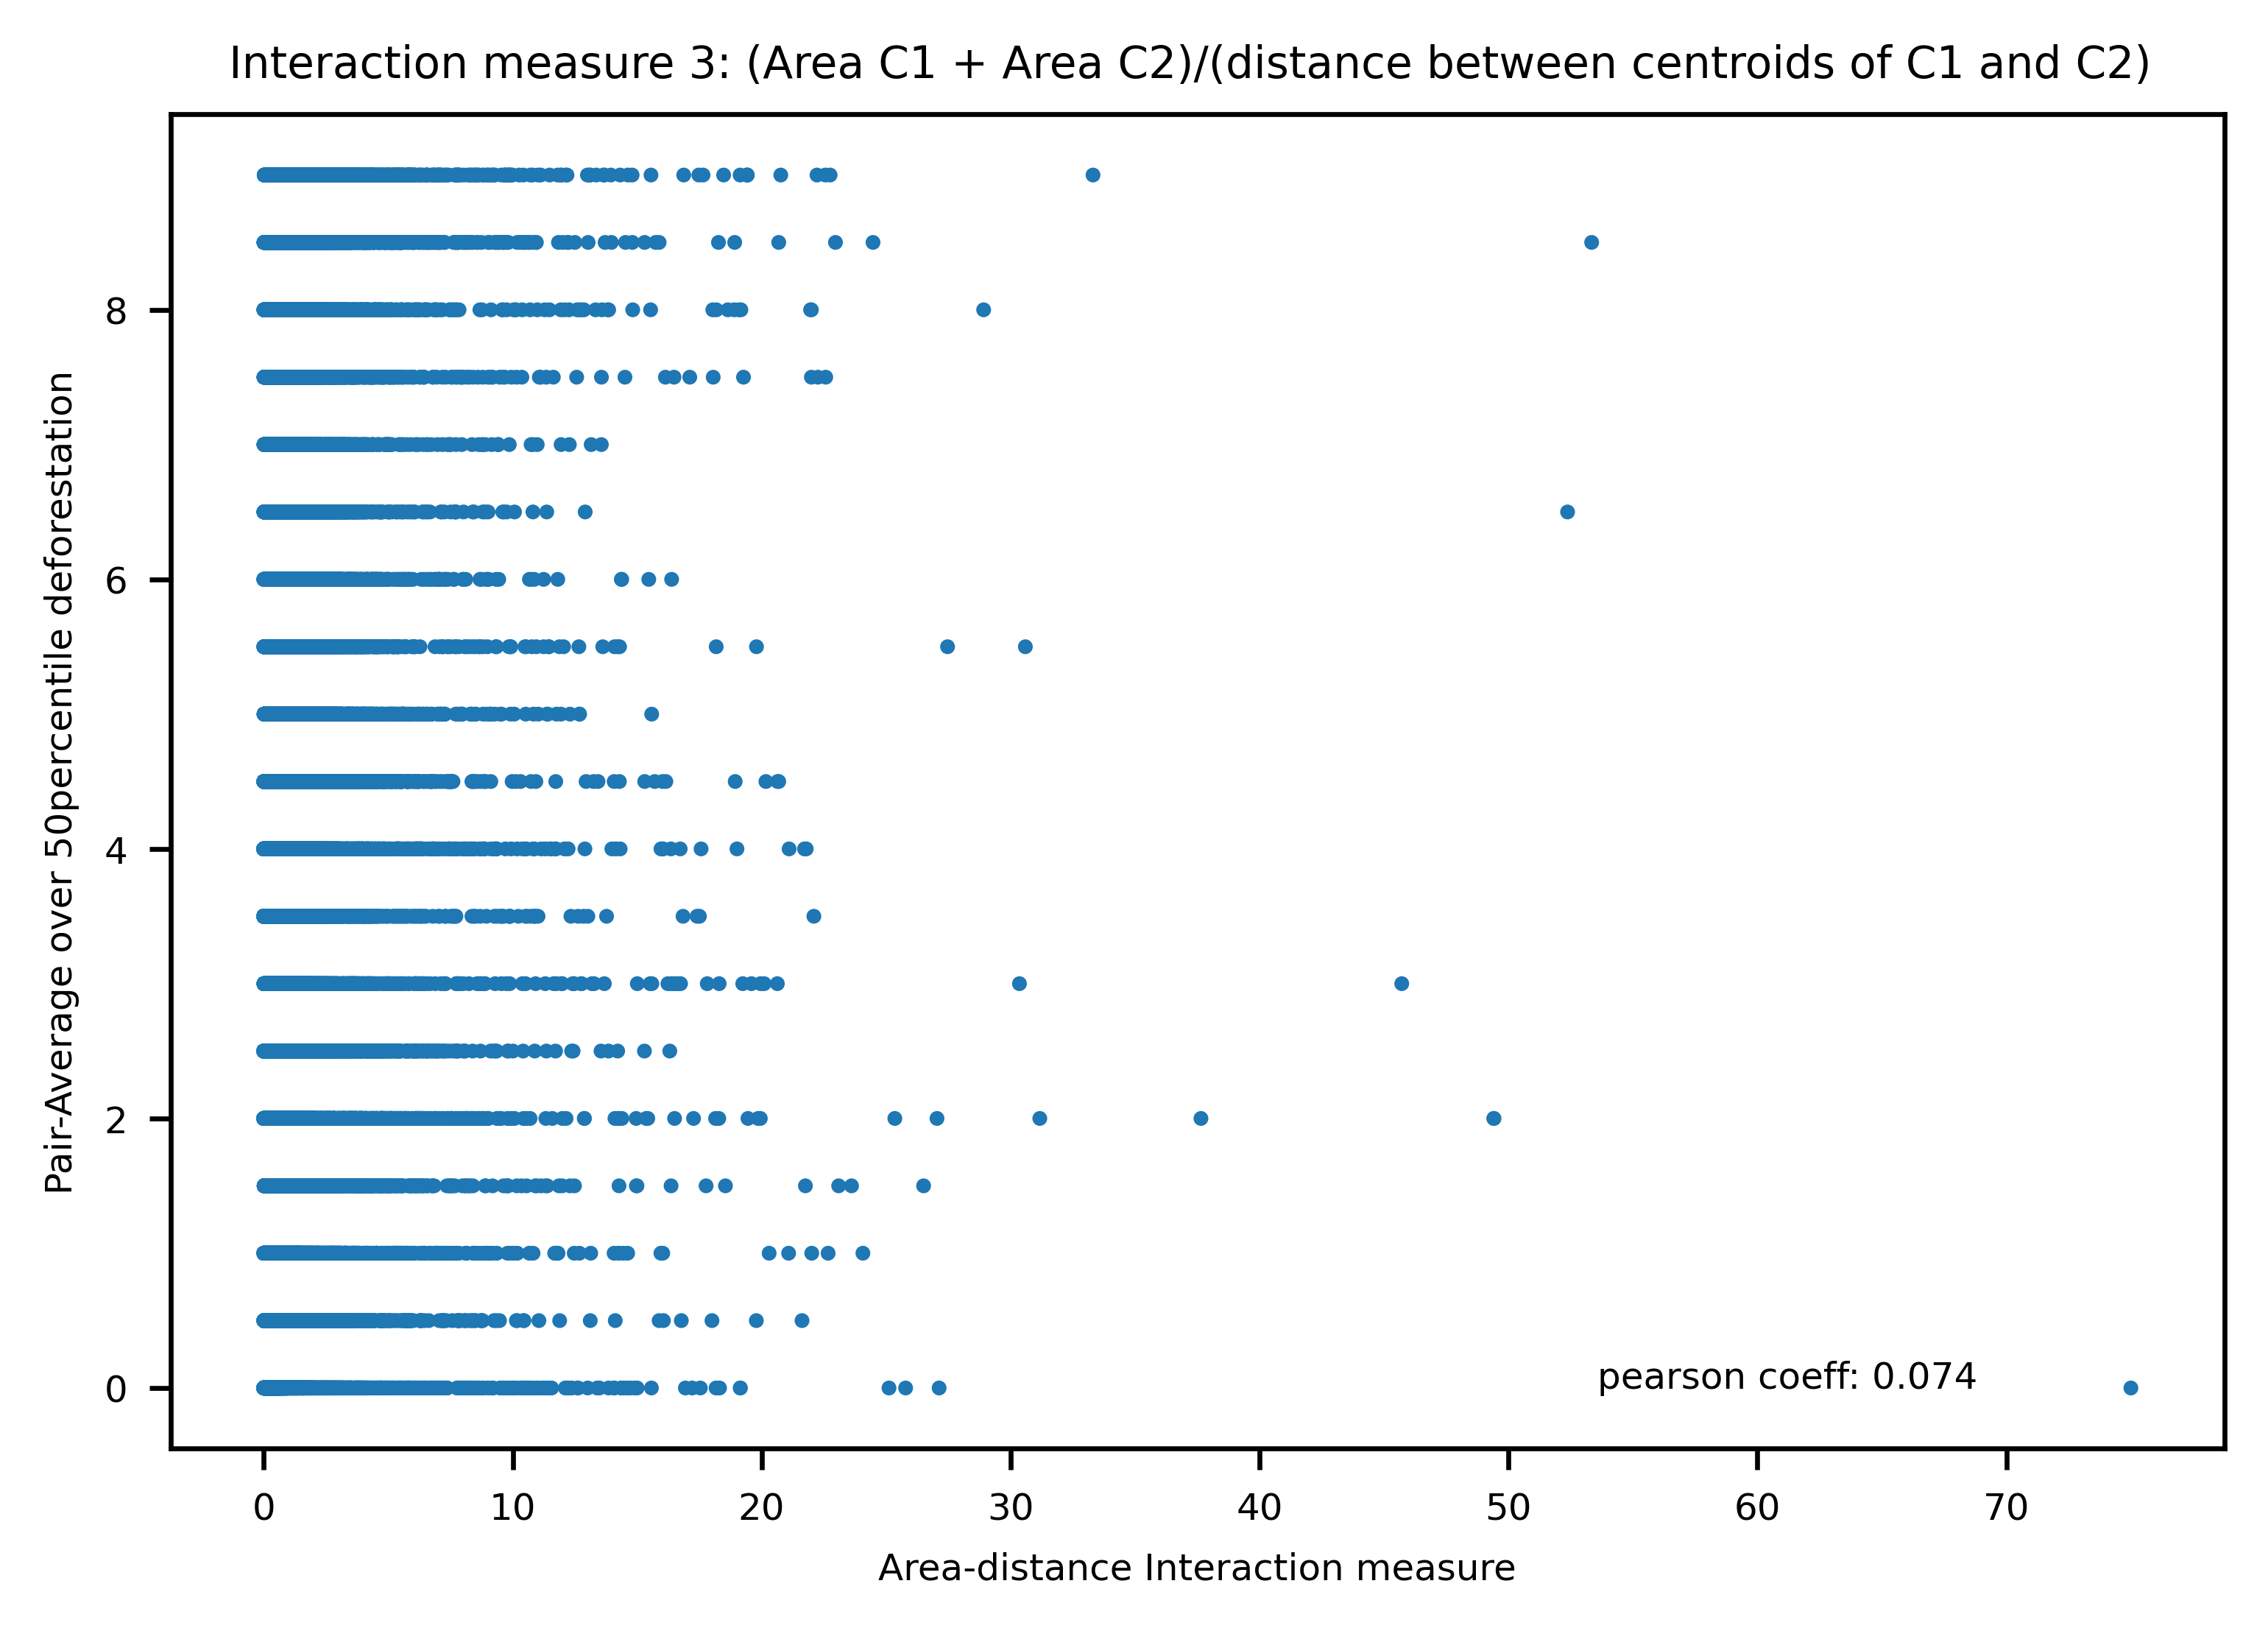

In [75]:
# 10/27
# plot with mask for over 1% deforestation and use pair average deforcountover50p on y-axis
from scipy import stats
high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)
x = area_dist_measure#[high_defor_only_mask]
y = pair_avg_deforcountover50p#[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2) ")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("Pair-Average over 50percentile deforestation")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)
# plt.show()

Text(53.57142857142857, 0, 'pearson coeff: -0.091')

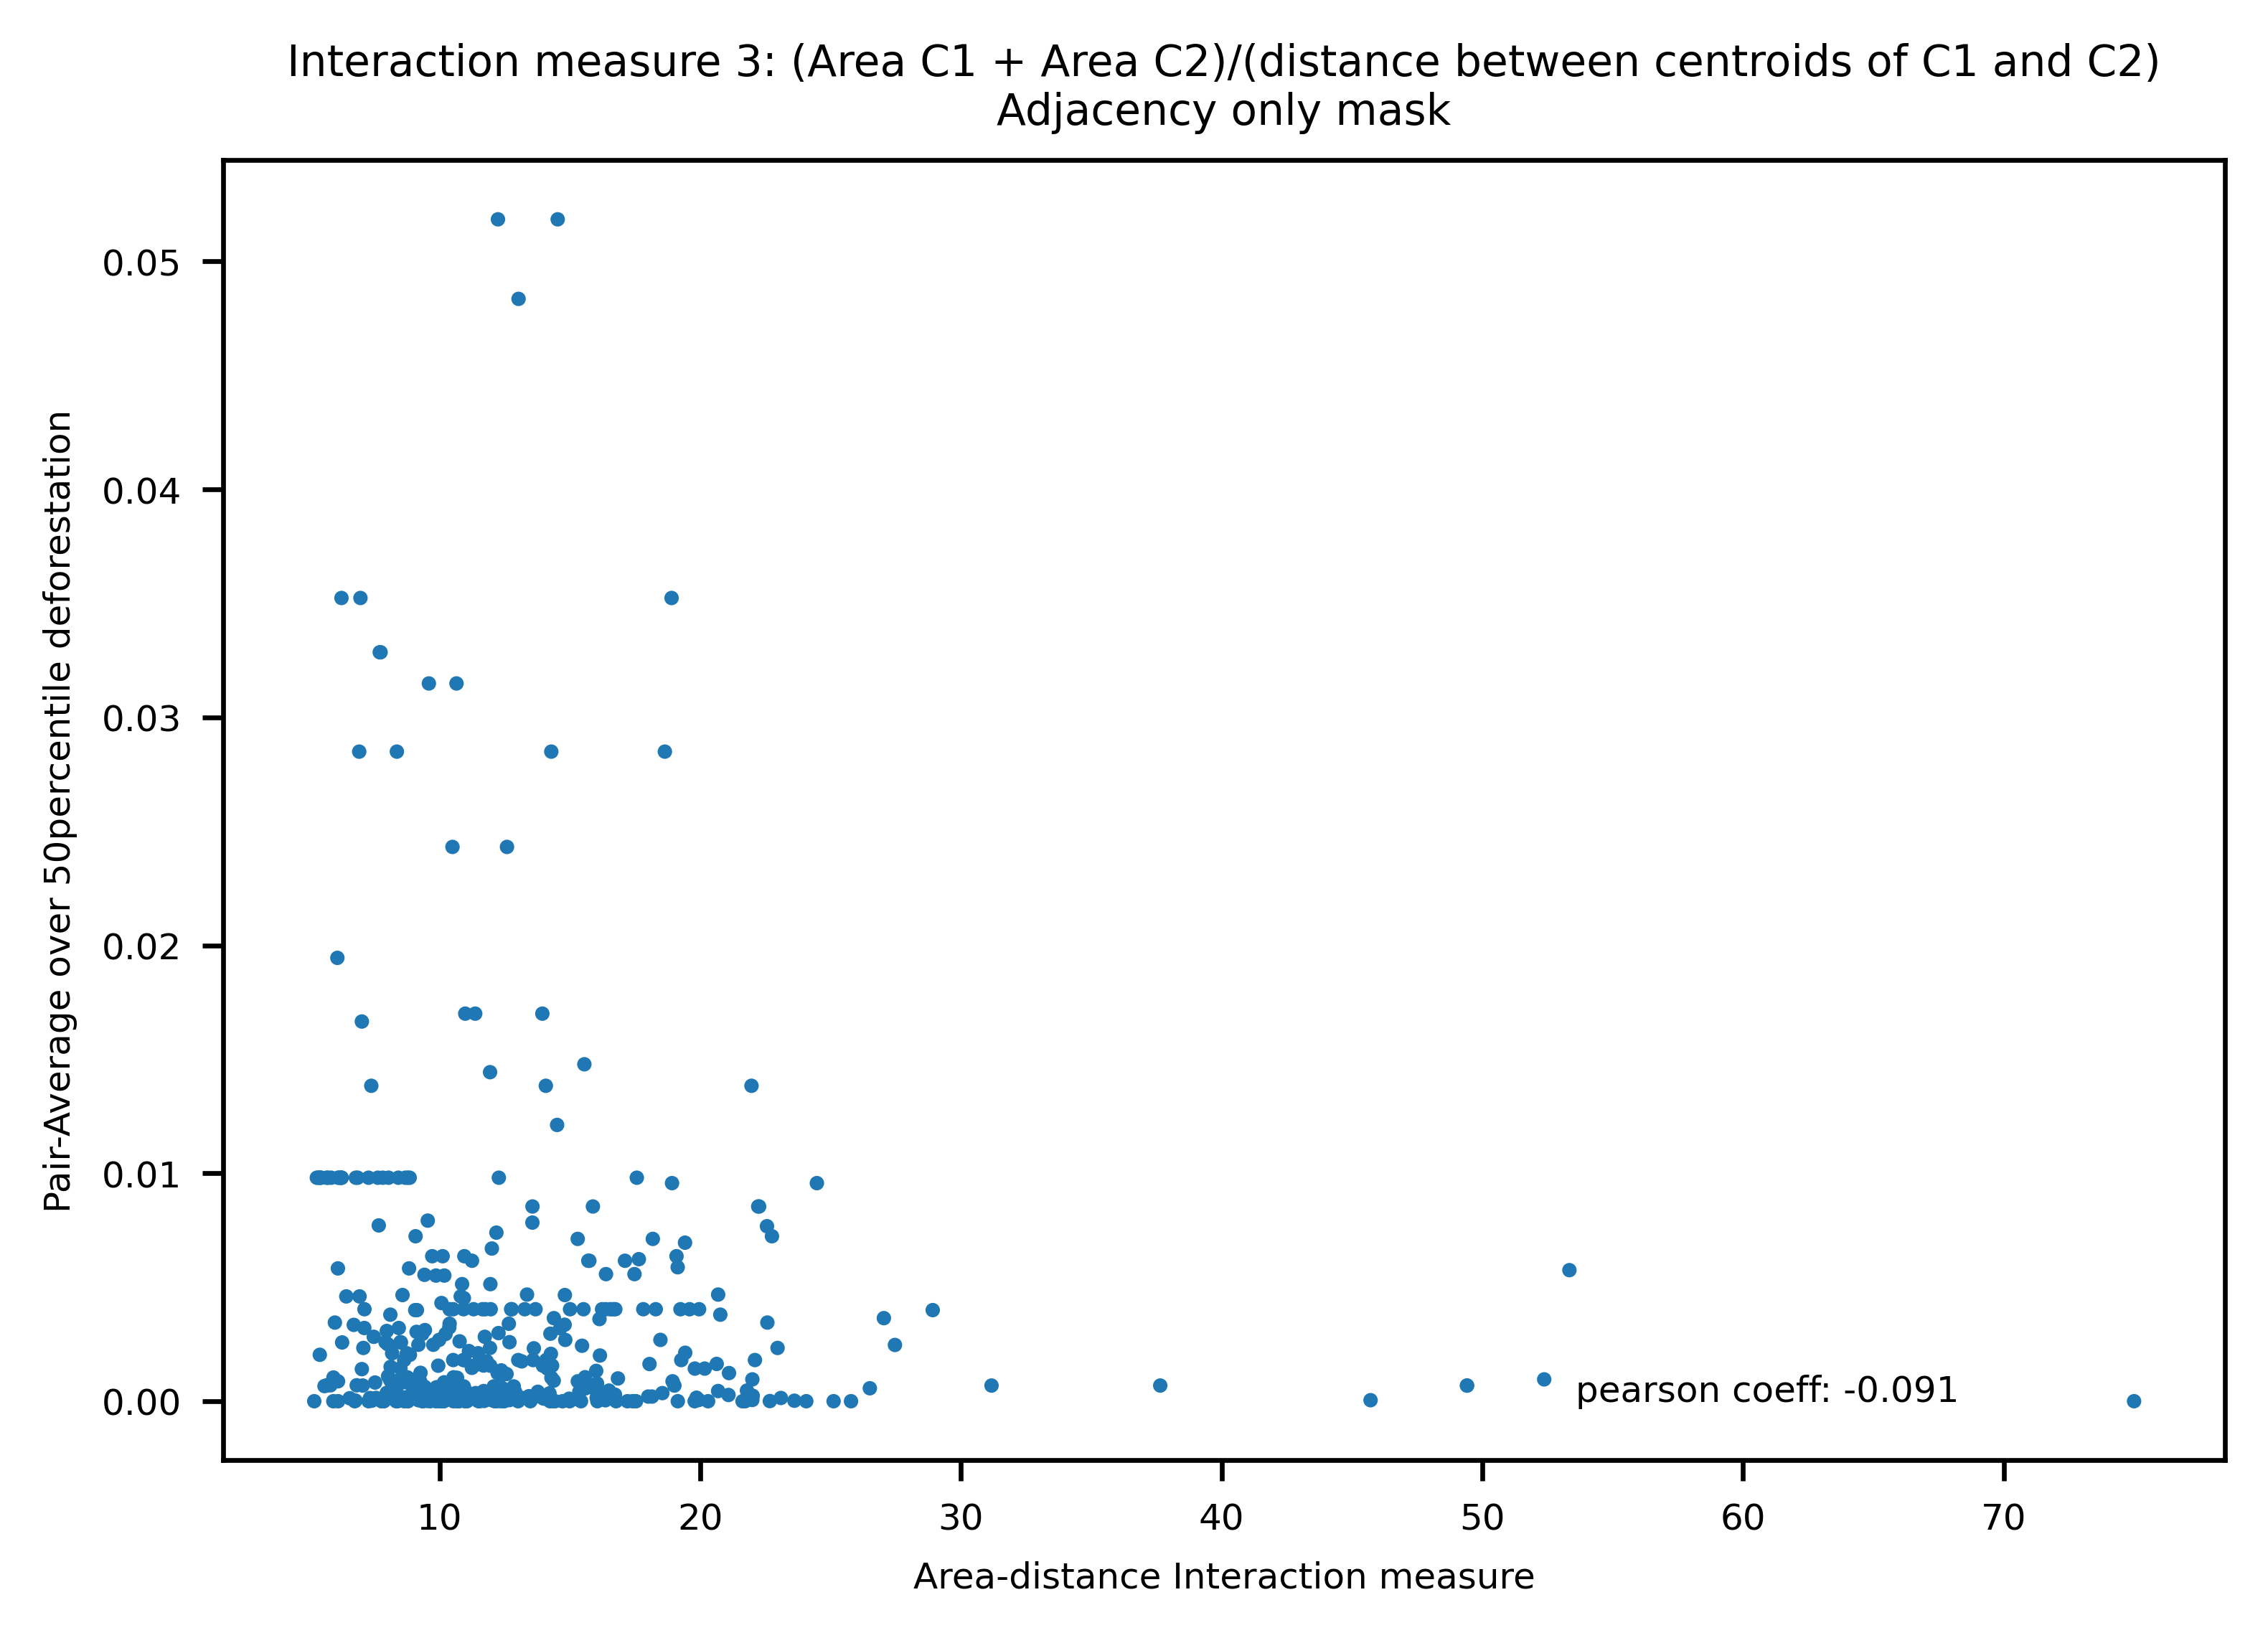

In [76]:
# 10/27
# use adjacency mask, pair_avg_defor_normed_over50p on y axis
from scipy import stats
adj_only_mask = np.where(boundary_perim_measure > 0)
x = area_dist_measure[adj_only_mask]
y = pair_avg_defor_normed_over50p[adj_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2)\nAdjacency only mask")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("Pair-Average over 50percentile deforestation")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)
# plt.show()

Text(23.79264070615077, 3, 'pearson coeff: 0.202')

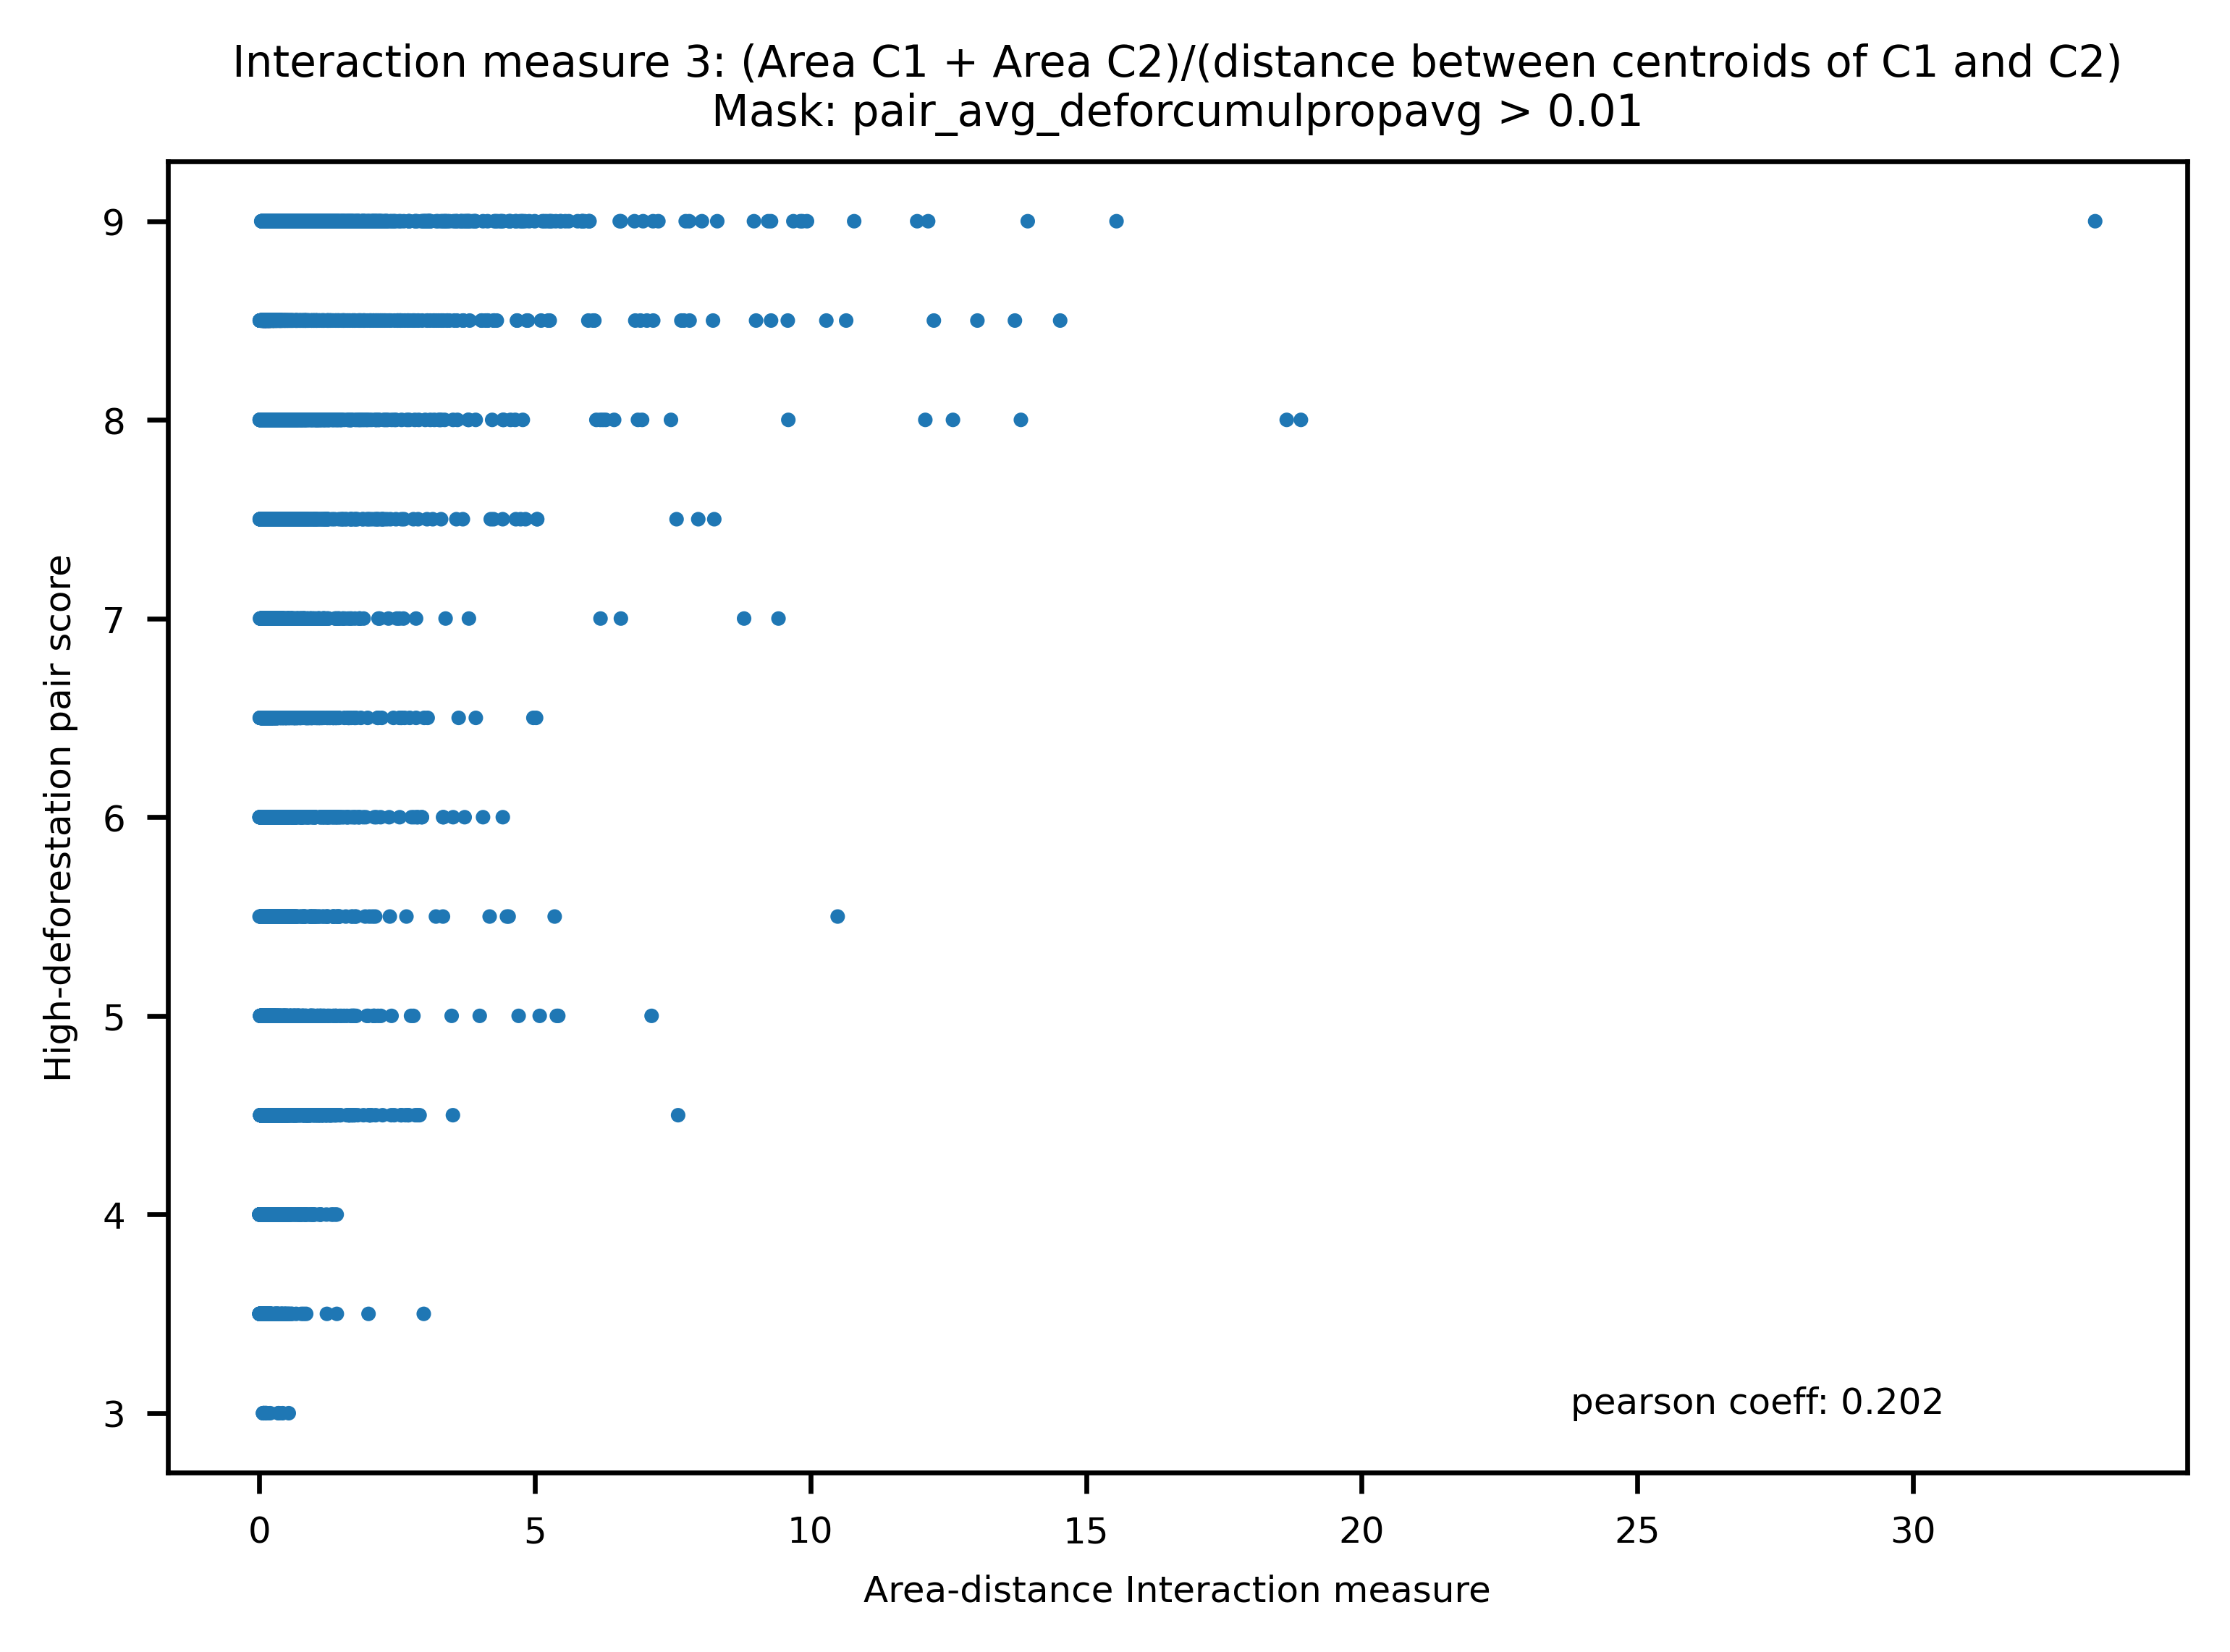

In [82]:
# 10/27
# *** promising!!! *** 
# higher interaction implies higher probability of higher overall deforestation
# same as above but use mask for high deforestation 
from scipy import stats
high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)   
x = area_dist_measure[high_defor_only_mask]
y = pair_avg_deforcountover50p[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2)\nMask: pair_avg_deforcumulpropavg > 0.01")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("High-deforestation pair score")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=3)
# plt.show()

Text(23.79264070615077, 0.4, 'pearson coeff: 0.19')

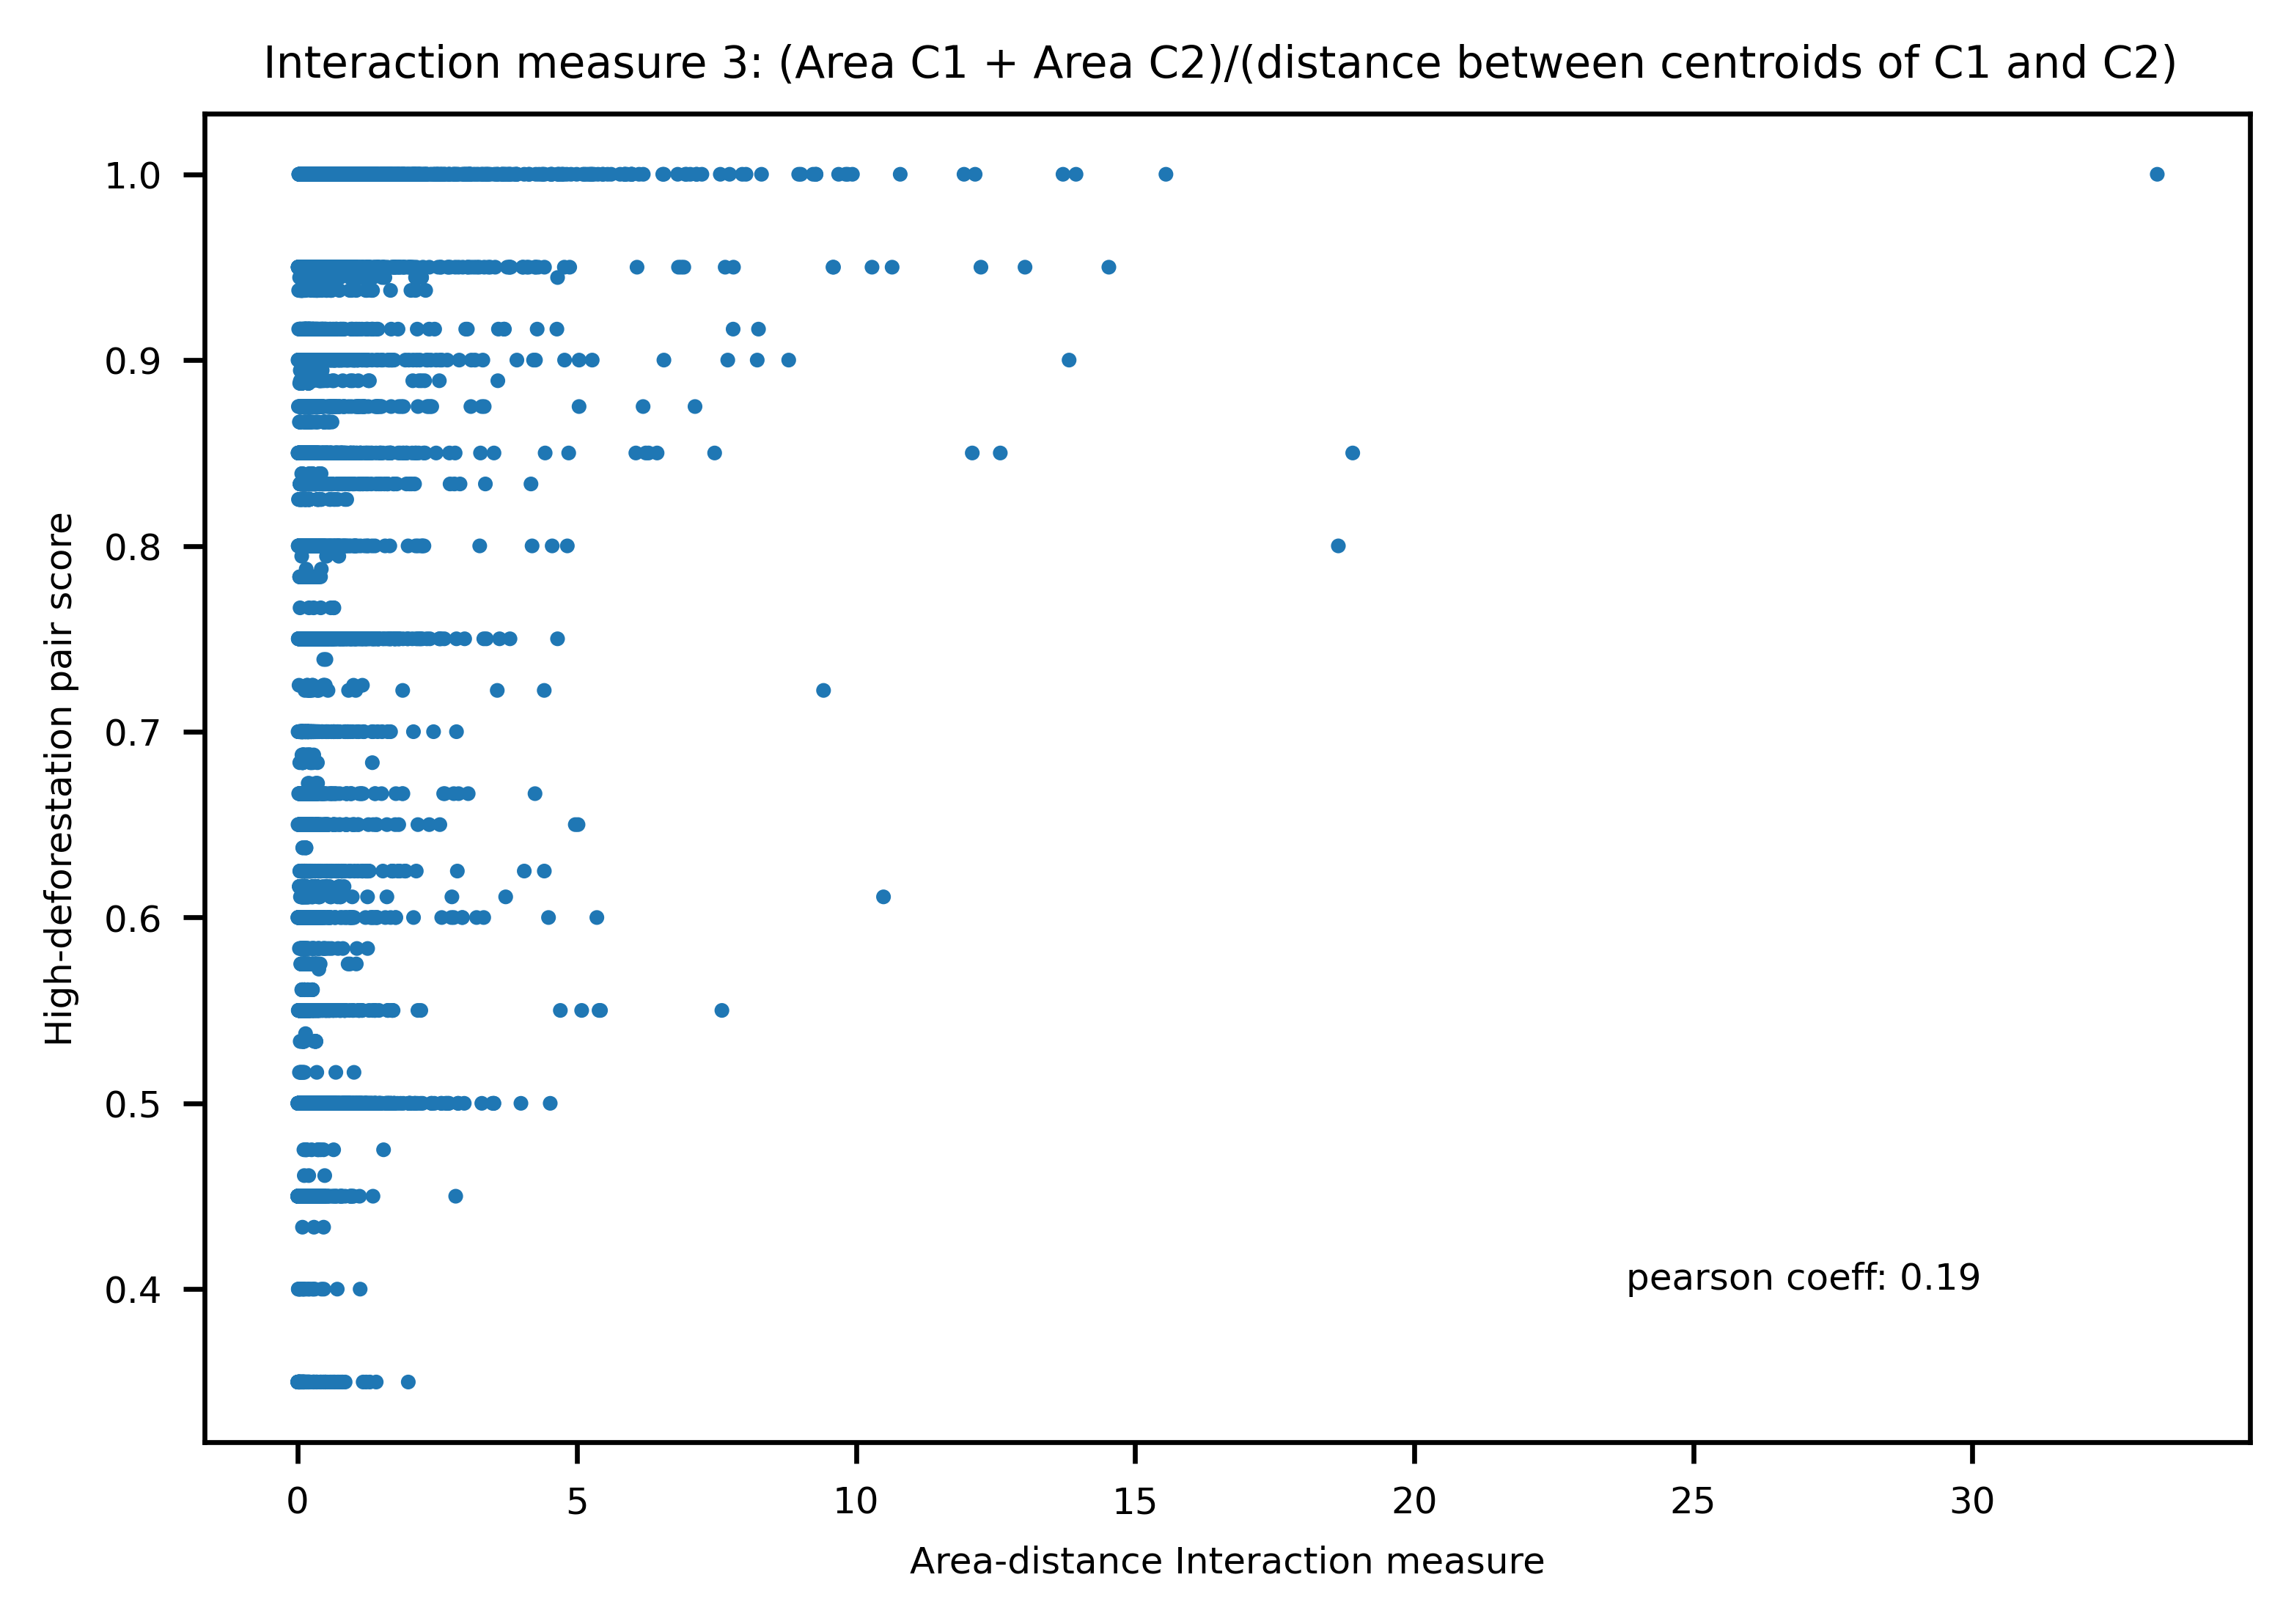

In [85]:
# 12/1
# same as above but y-axis using normalized over50-percentile calculations
from scipy import stats
high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)   
x = area_dist_measure[high_defor_only_mask]
y = pair_avg_defor_normed_over50p[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2) ")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("High-deforestation pair score")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=.4)
# plt.show()

0.18973432716950947 1.5120103570724847e-89


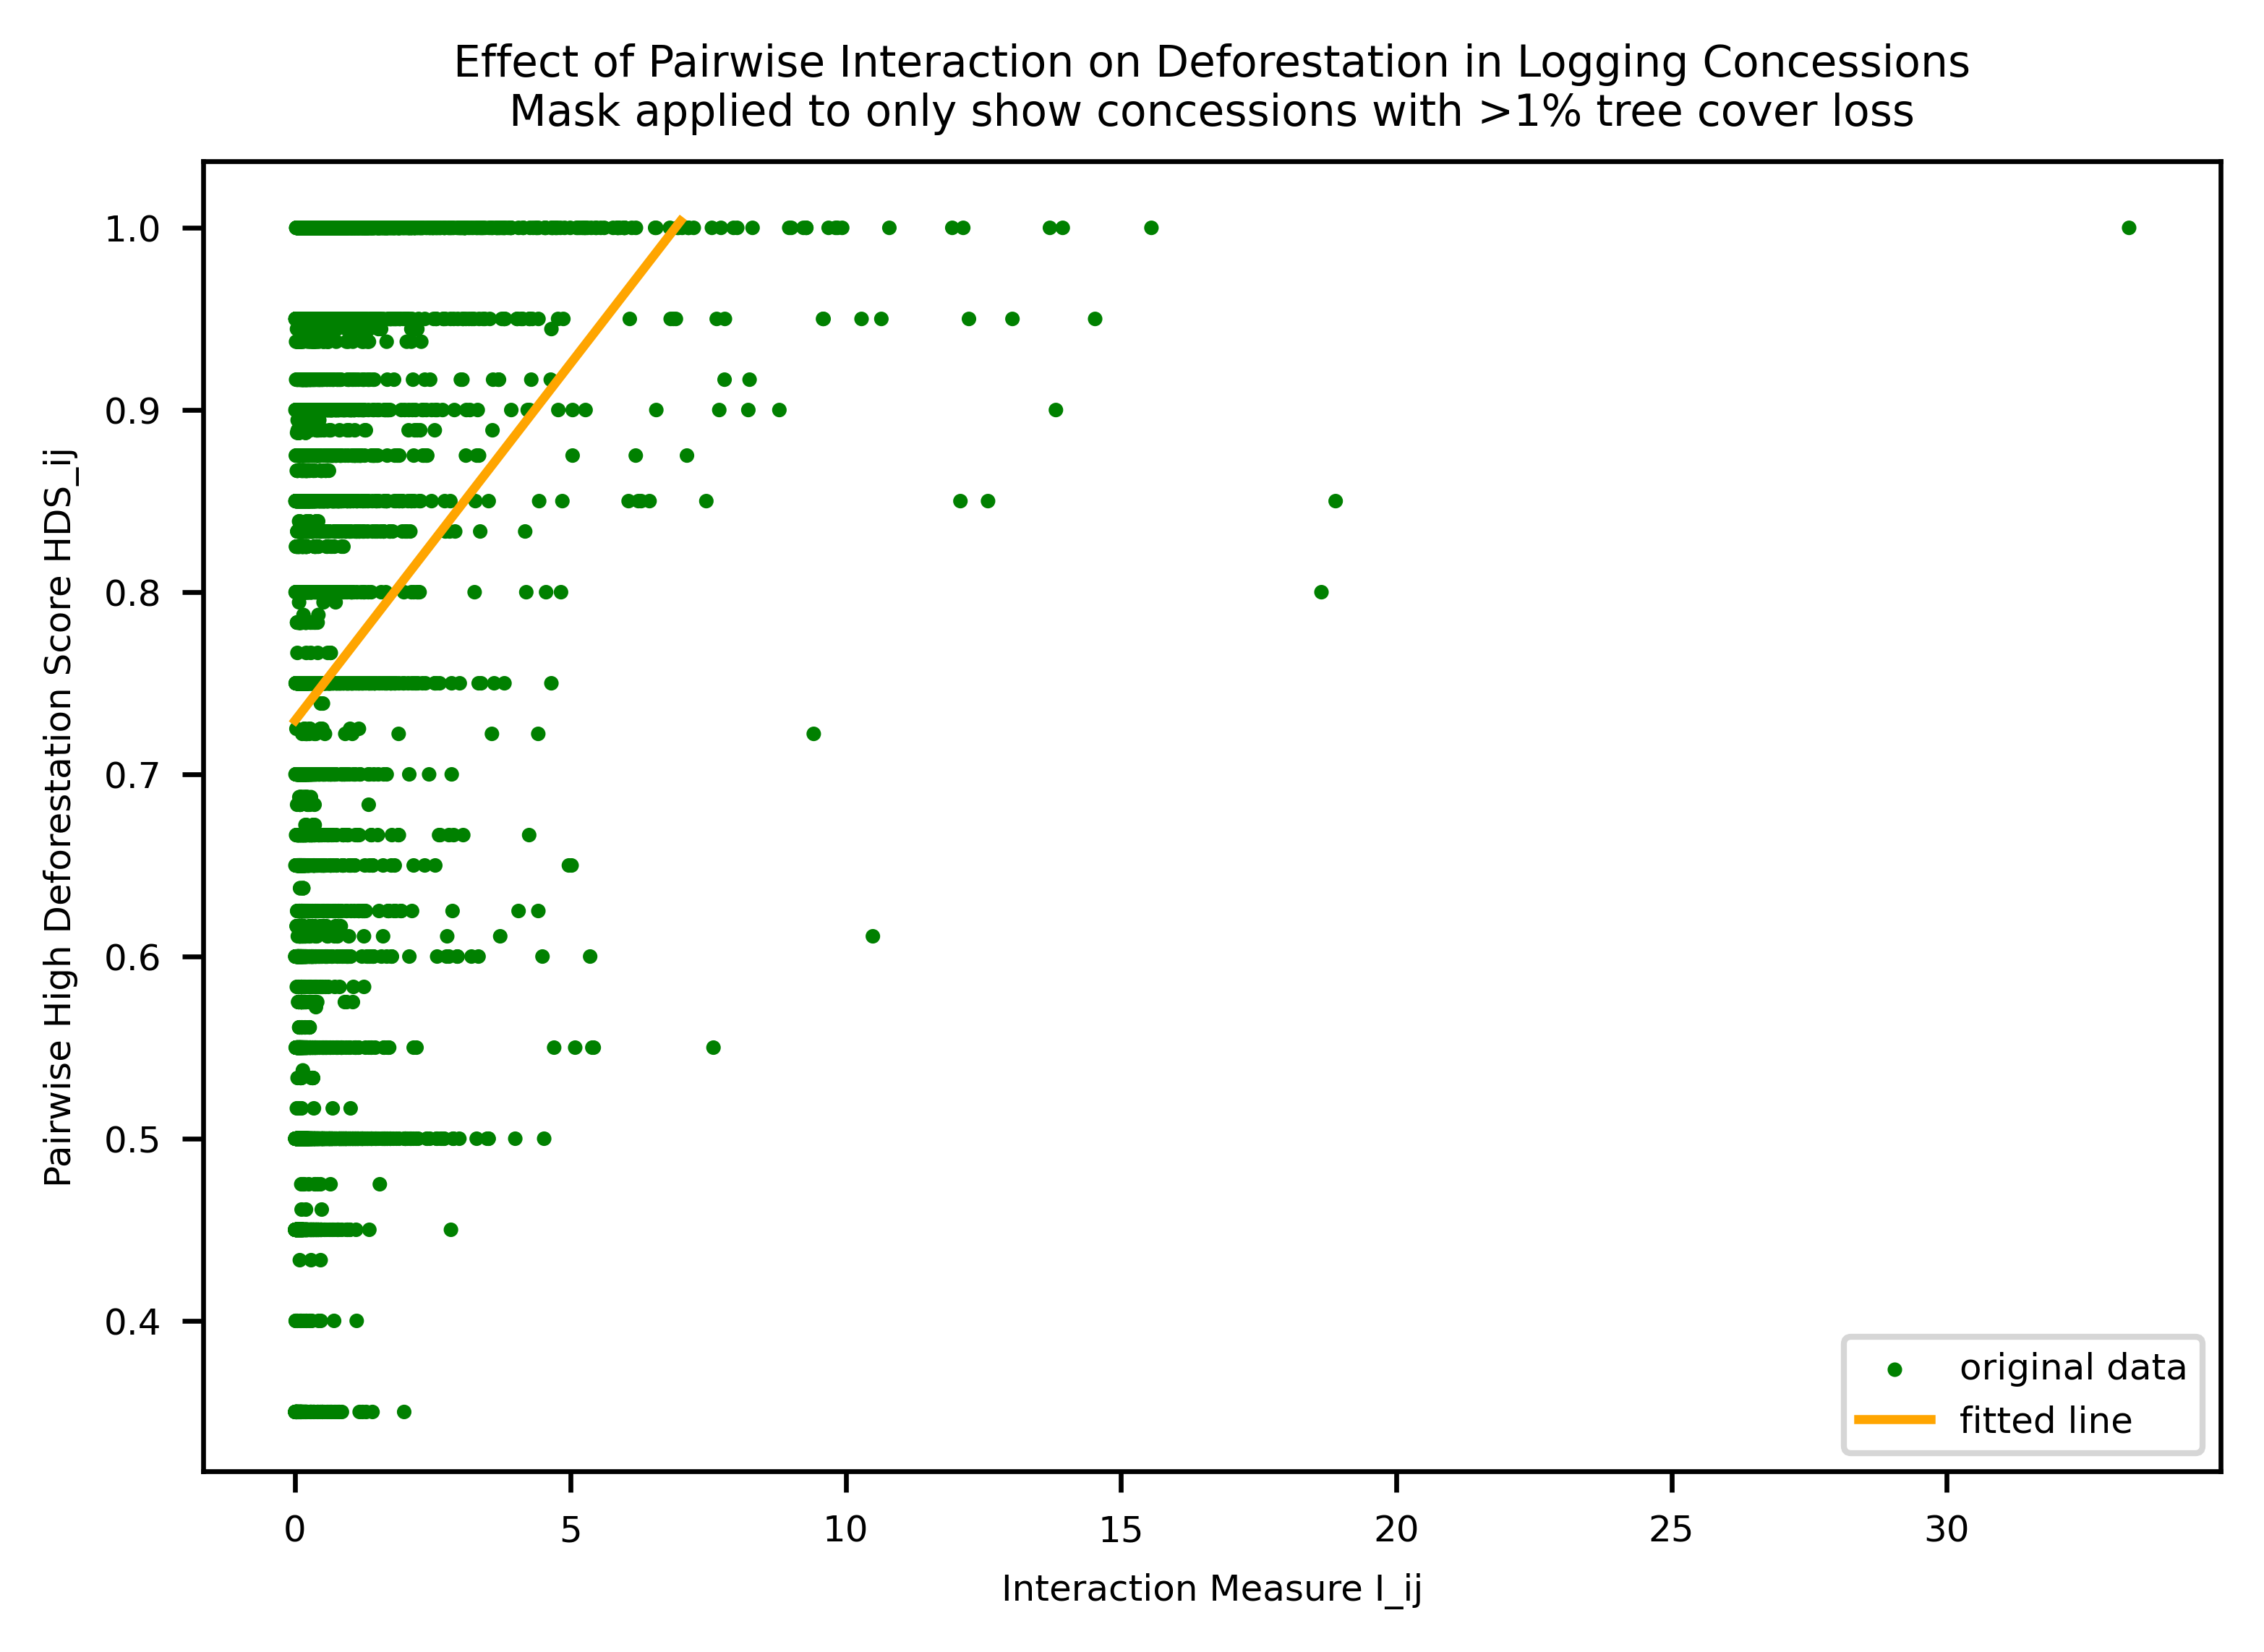

In [98]:
# plot regression line on above model
slope, intercept, r, p, se = stats.linregress(x, y)
print(r, p)
plt.scatter(x=x, y=y, label='original data', s=[2]*len(x), c="green")
plt.plot(np.array([0,7]), intercept + slope*np.array([0, 7]), 'orange', label='fitted line')
plt.legend()
plt.title("Effect of Pairwise Interaction on Deforestation in Logging Concessions\nMask applied to only show concessions with >1% tree cover loss")
plt.xlabel("Interaction Measure I_ij")
plt.ylabel("Pairwise High Deforestation Score HDS_ij")
# plt.text(s="r: " + str(round(r,3)), x=30, y=.5)
plt.show()

In [86]:
import statsmodels.api as sm
# run in depth regression results on same above model 
def run_OLS(X, Y):
    X = sm.add_constant(X) #

    model = sm.OLS(Y, X).fit()

    print("RSS: ", round(model.ssr, 3))
    return model.summary() 

run_OLS(X = area_dist_measure[high_defor_only_mask], Y = pair_avg_defor_normed_over50p[high_defor_only_mask])

RSS:  465.799


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     410.1
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           1.51e-89
Time:                        22:15:18   Log-Likelihood:                 1770.9
No. Observations:               10983   AIC:                            -3538.
Df Residuals:                   10981   BIC:                            -3523.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7296      0.002    334.980      0.000       0.725       0.734
x1             0.0392      0.002     20.250      0.000       0.035       0.043
==============================================================================
Omnibus:                    82165.976   Durbin-Watson:                   0.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              991.014
Skew:                          -0.149   Prob(JB):                    6.37e-216
Kurtosis:                       1.559   Cond. No.                         1.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(23.79264070615077, 0.01, 'pearson coeff: -0.166')

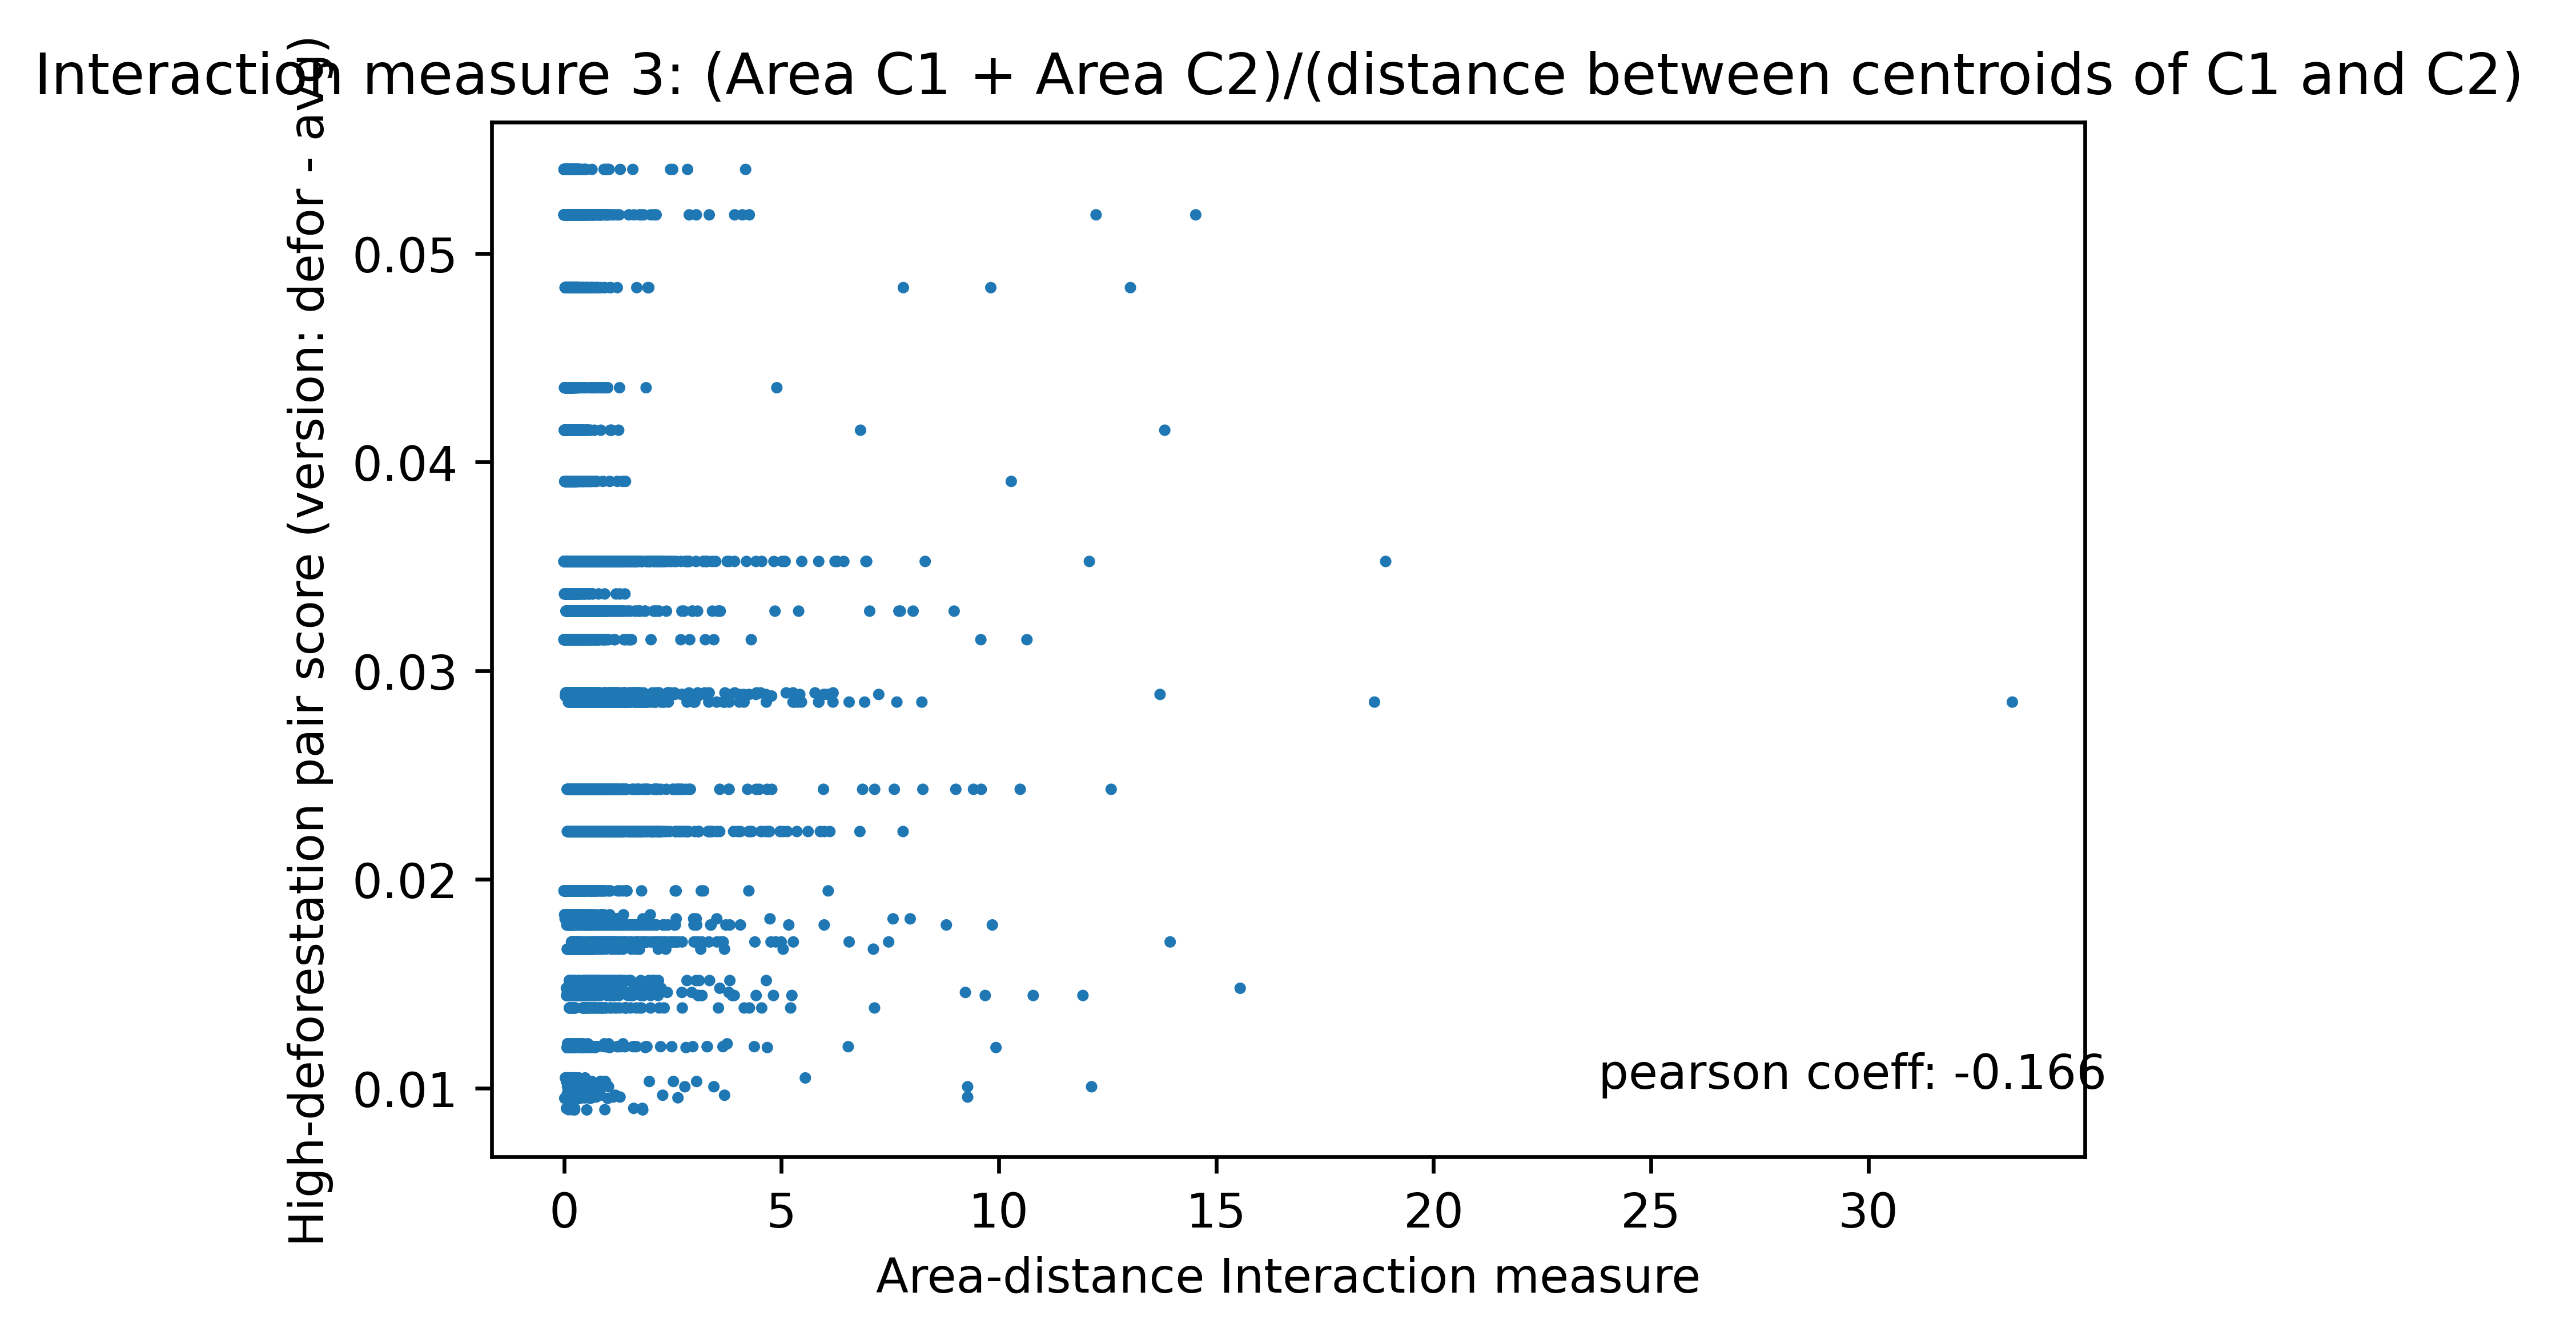

In [55]:
# new
# same as above but y-axis using normalized over50-percentile calculations and high deforestation mask
from scipy import stats
high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)   
x = area_dist_measure[high_defor_only_mask]
y = pair_avg_defor_normed_over50p[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2) ")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("High-deforestation pair score (version: defor - avg)")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0.01)
# plt.show()

Text(53.57142857142857, 0.4, 'pearson coeff: 0.066')

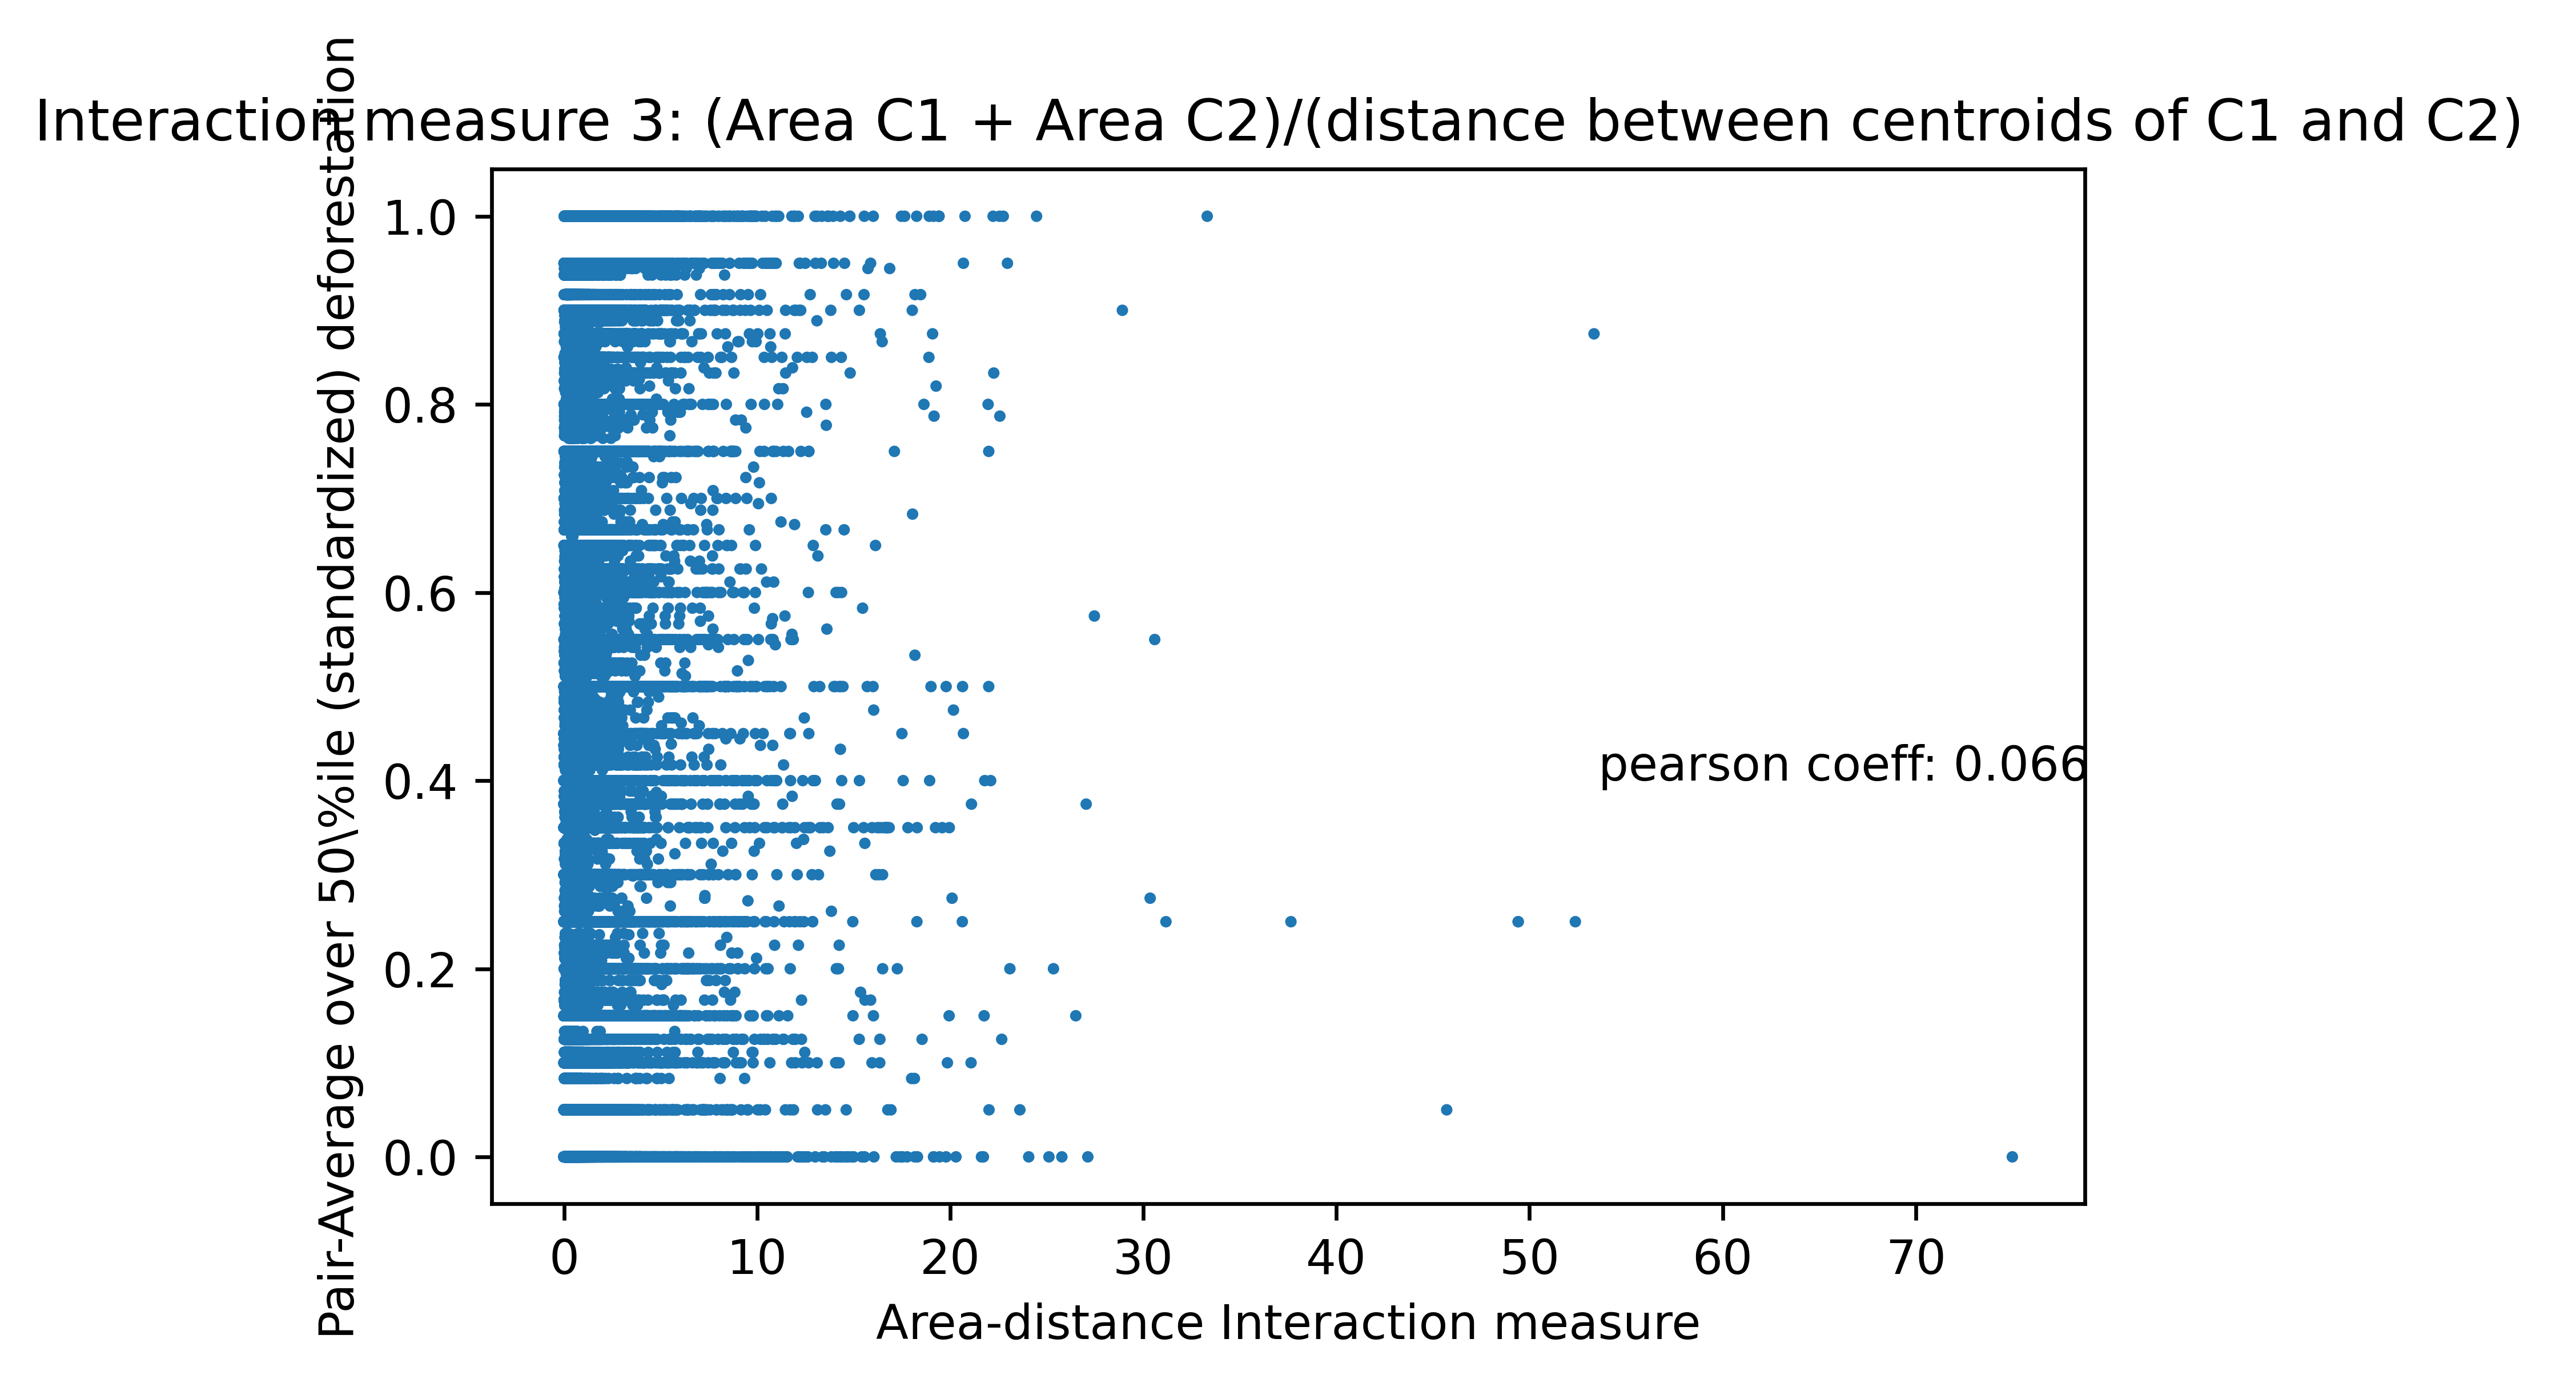

In [55]:
# 12/1
# same as above but no mask
from scipy import stats
high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)   
x = area_dist_measure
y = pair_avg_defor_normed_over50p
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2) ")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("Pair-Average over 50\%ile (standardized) deforestation")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=.4)
# plt.show()

Text(53.57142857142857, 0.01, 'pearson coeff: -0.024')

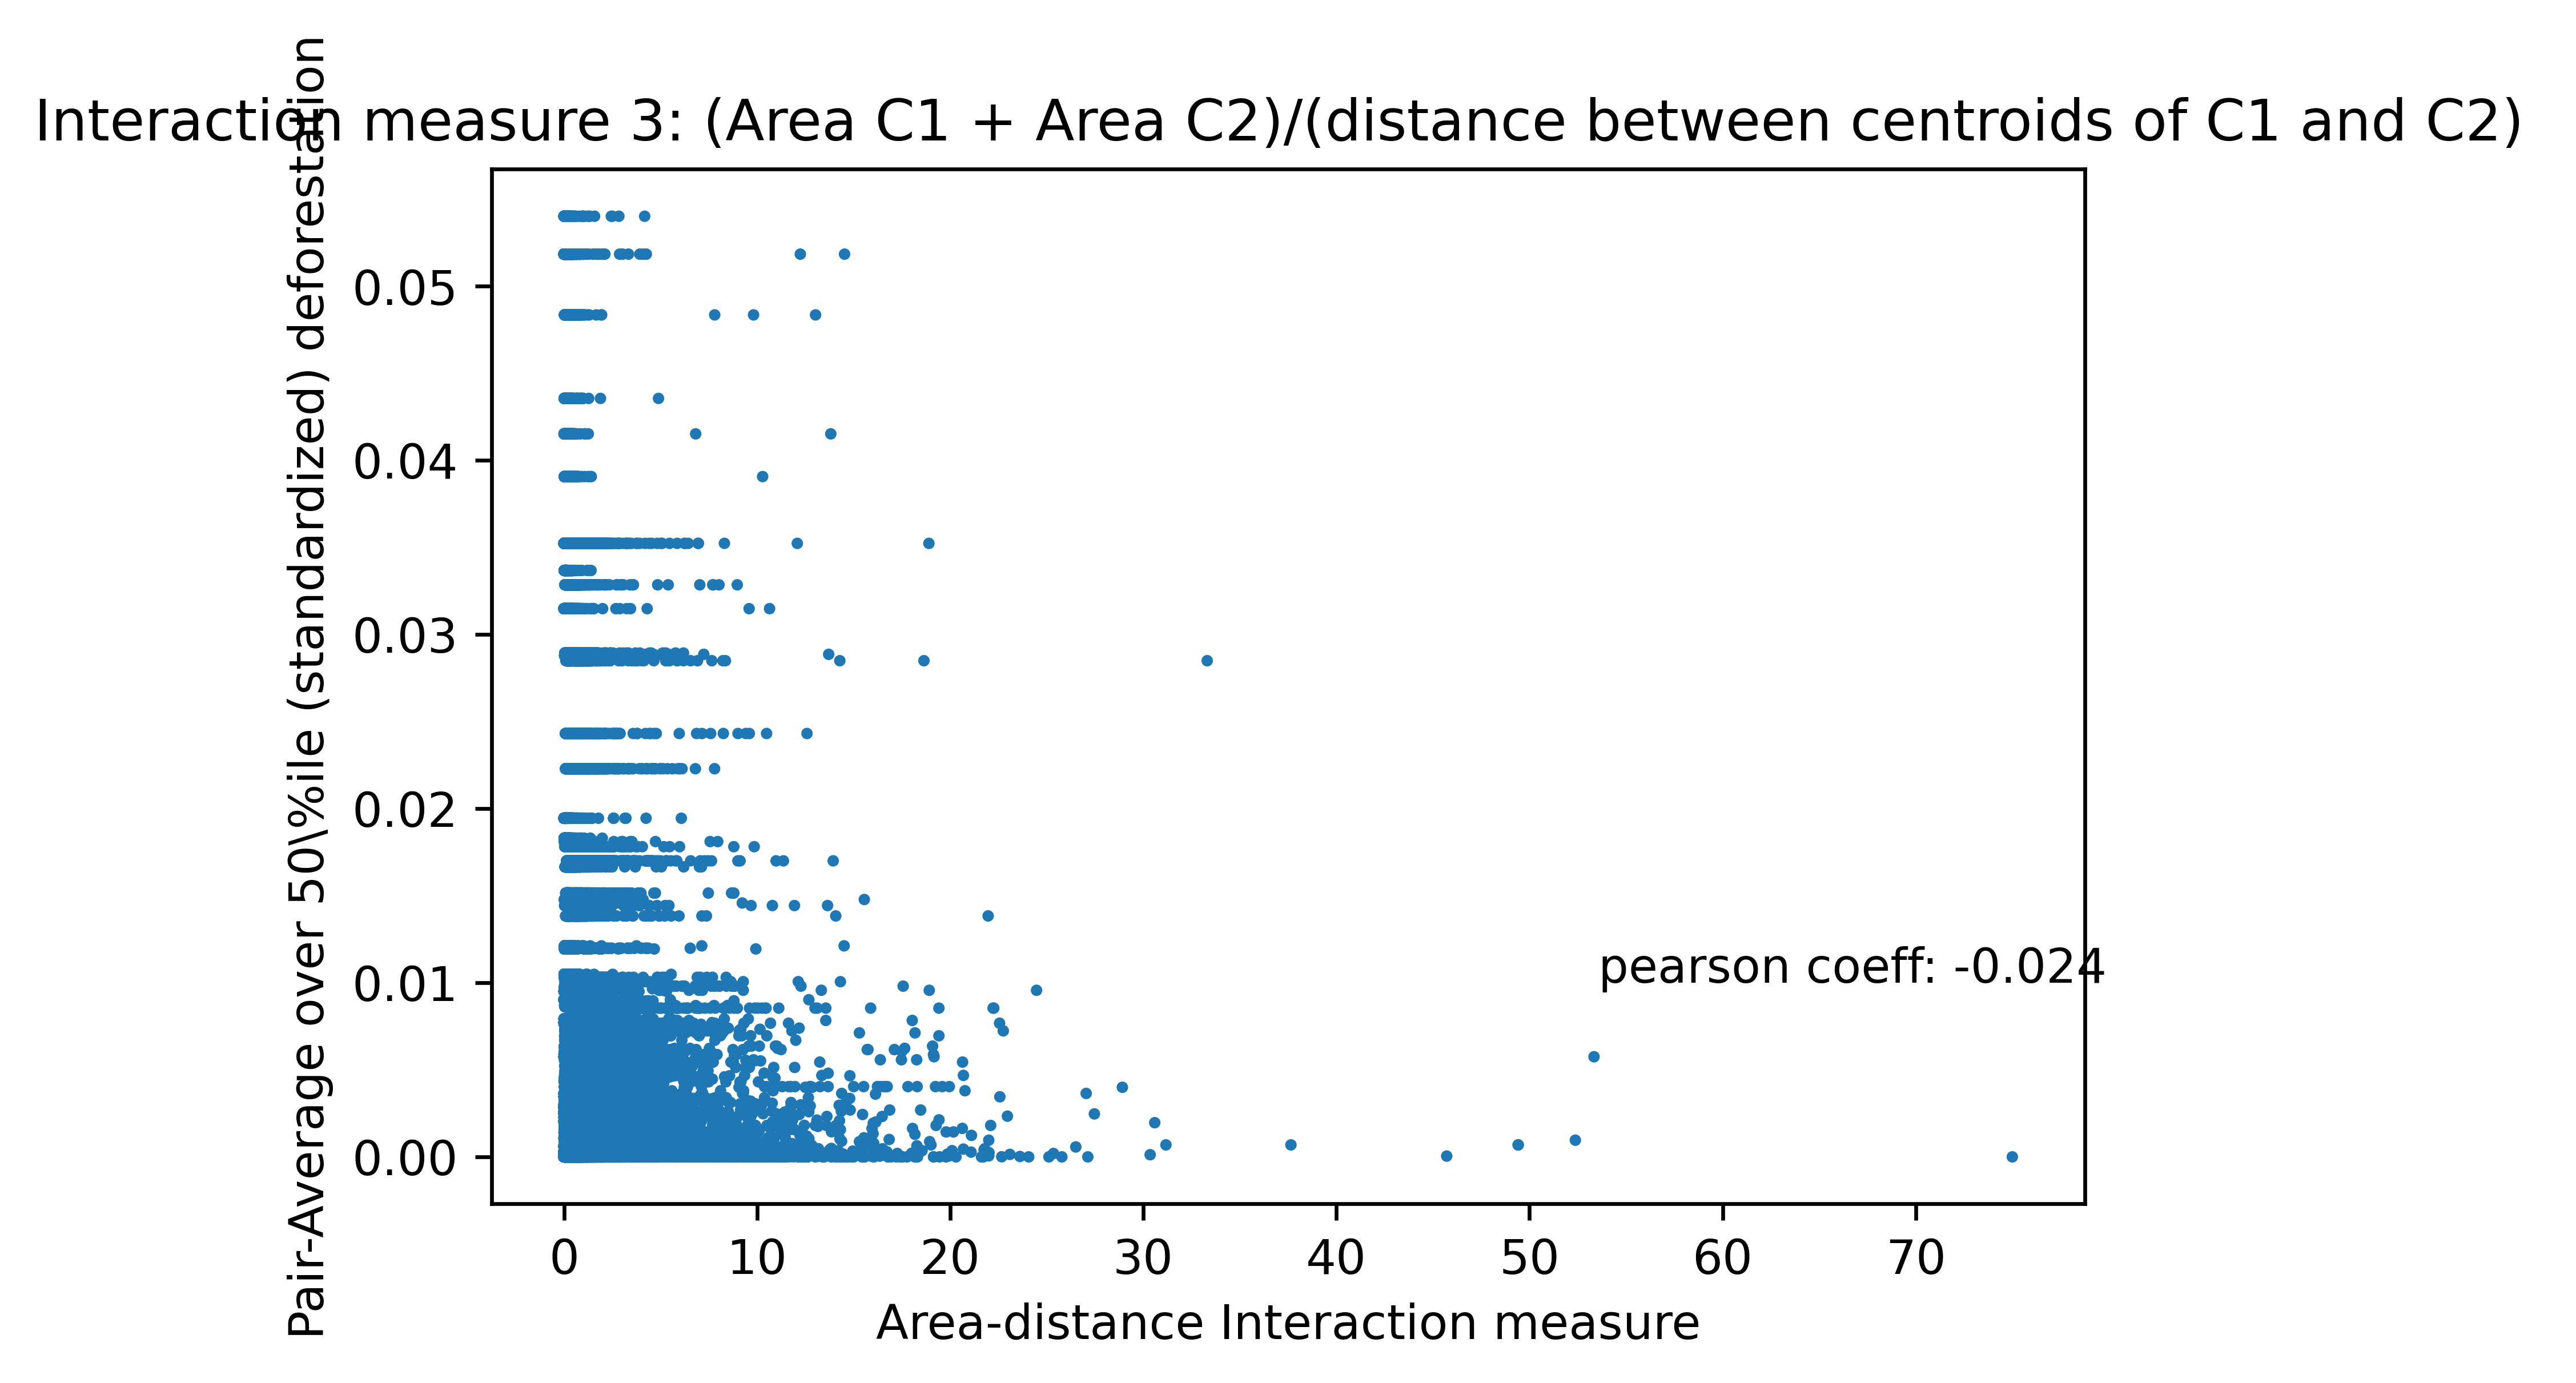

In [57]:
# new
# same as above but y-axis using normalized over50-percentile calculations
from scipy import stats
high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)   
x = area_dist_measure
y = pair_avg_defor_normed_over50p
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2) ")
plt.xlabel("Area-distance Interaction measure")
plt.ylabel("Pair-Average over 50\%ile (standardized) deforestation")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=.01)
# plt.show()

### Deeper analysis at interaction measure 3


Text(6.708633451252047, 3, 'pearson coeff: 0.162')

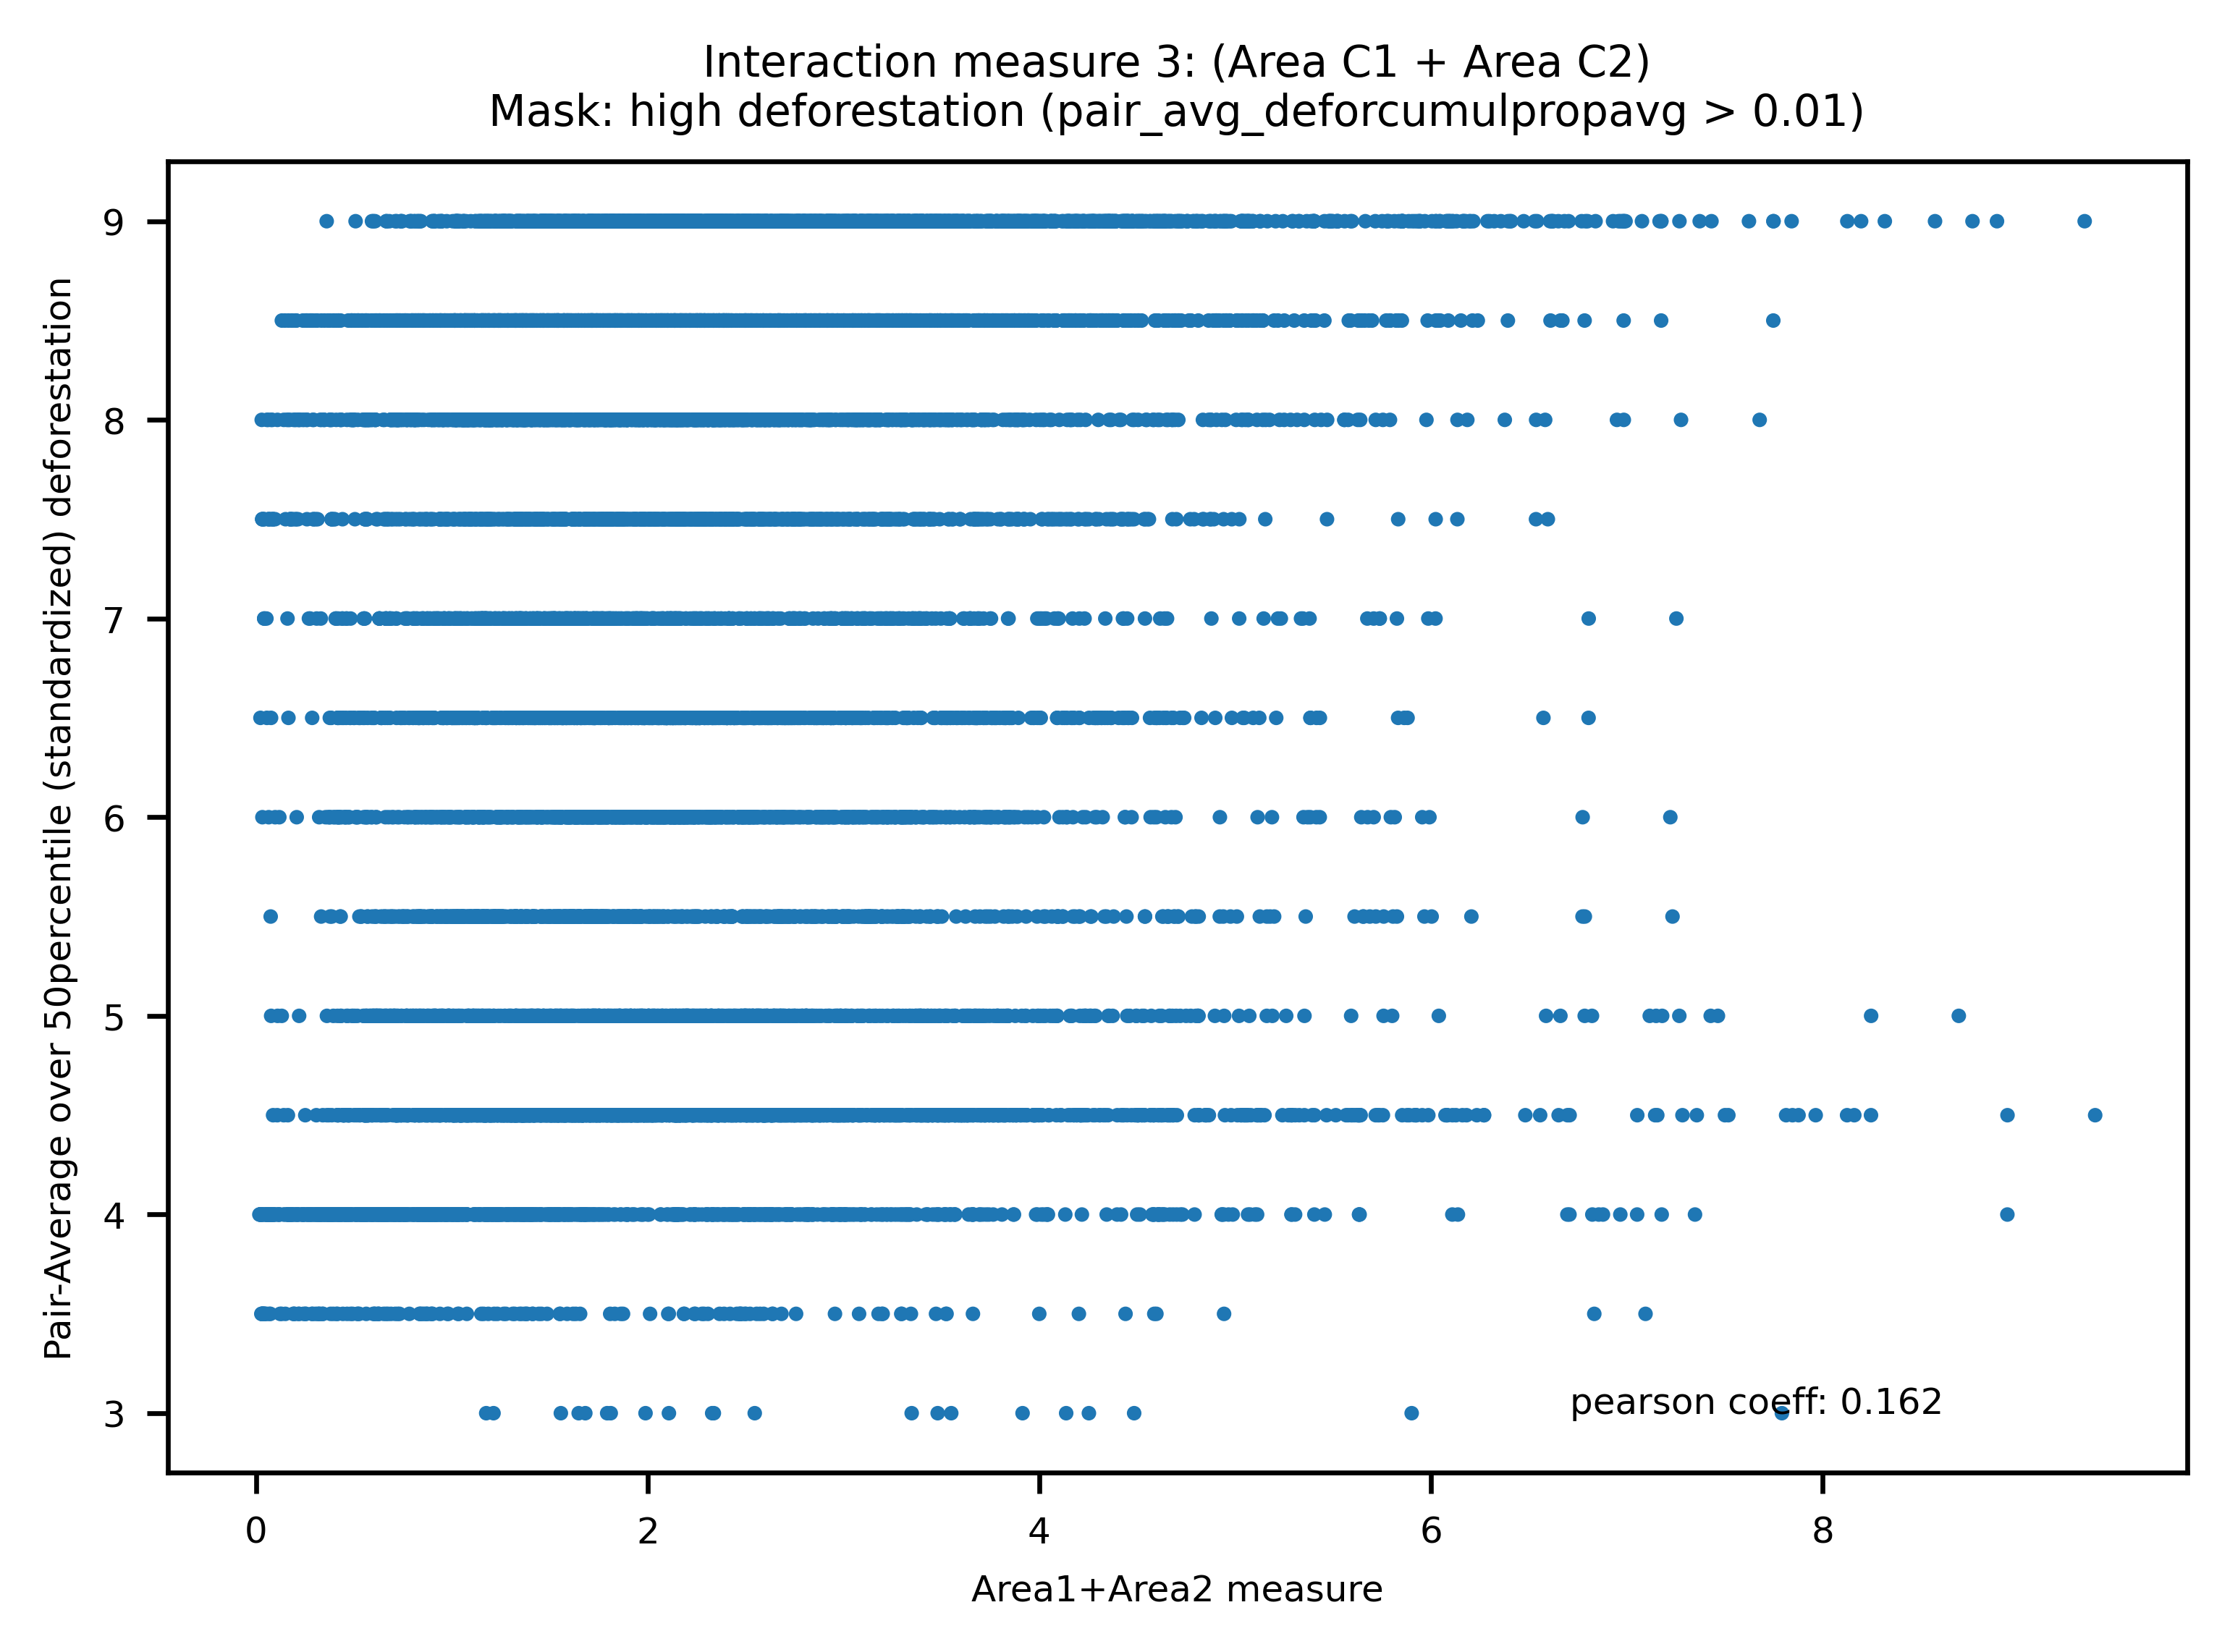

In [50]:
# 11/8
# isolate for impact of area only:
#high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)   
x = area_only_measure[high_defor_only_mask]
y = pair_avg_deforcountover50p[high_defor_only_mask]#pair_avg_defor_normed_over50p[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)\nMask: high deforestation (pair_avg_deforcumulpropavg > 0.01)")
plt.xlabel("Area1+Area2 measure")
plt.ylabel("Pair-Average over 50percentile (standardized) deforestation")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=3)
# plt.show()
# 

Text(10.955916306492984, 3, 'pearson coeff: 0.14')

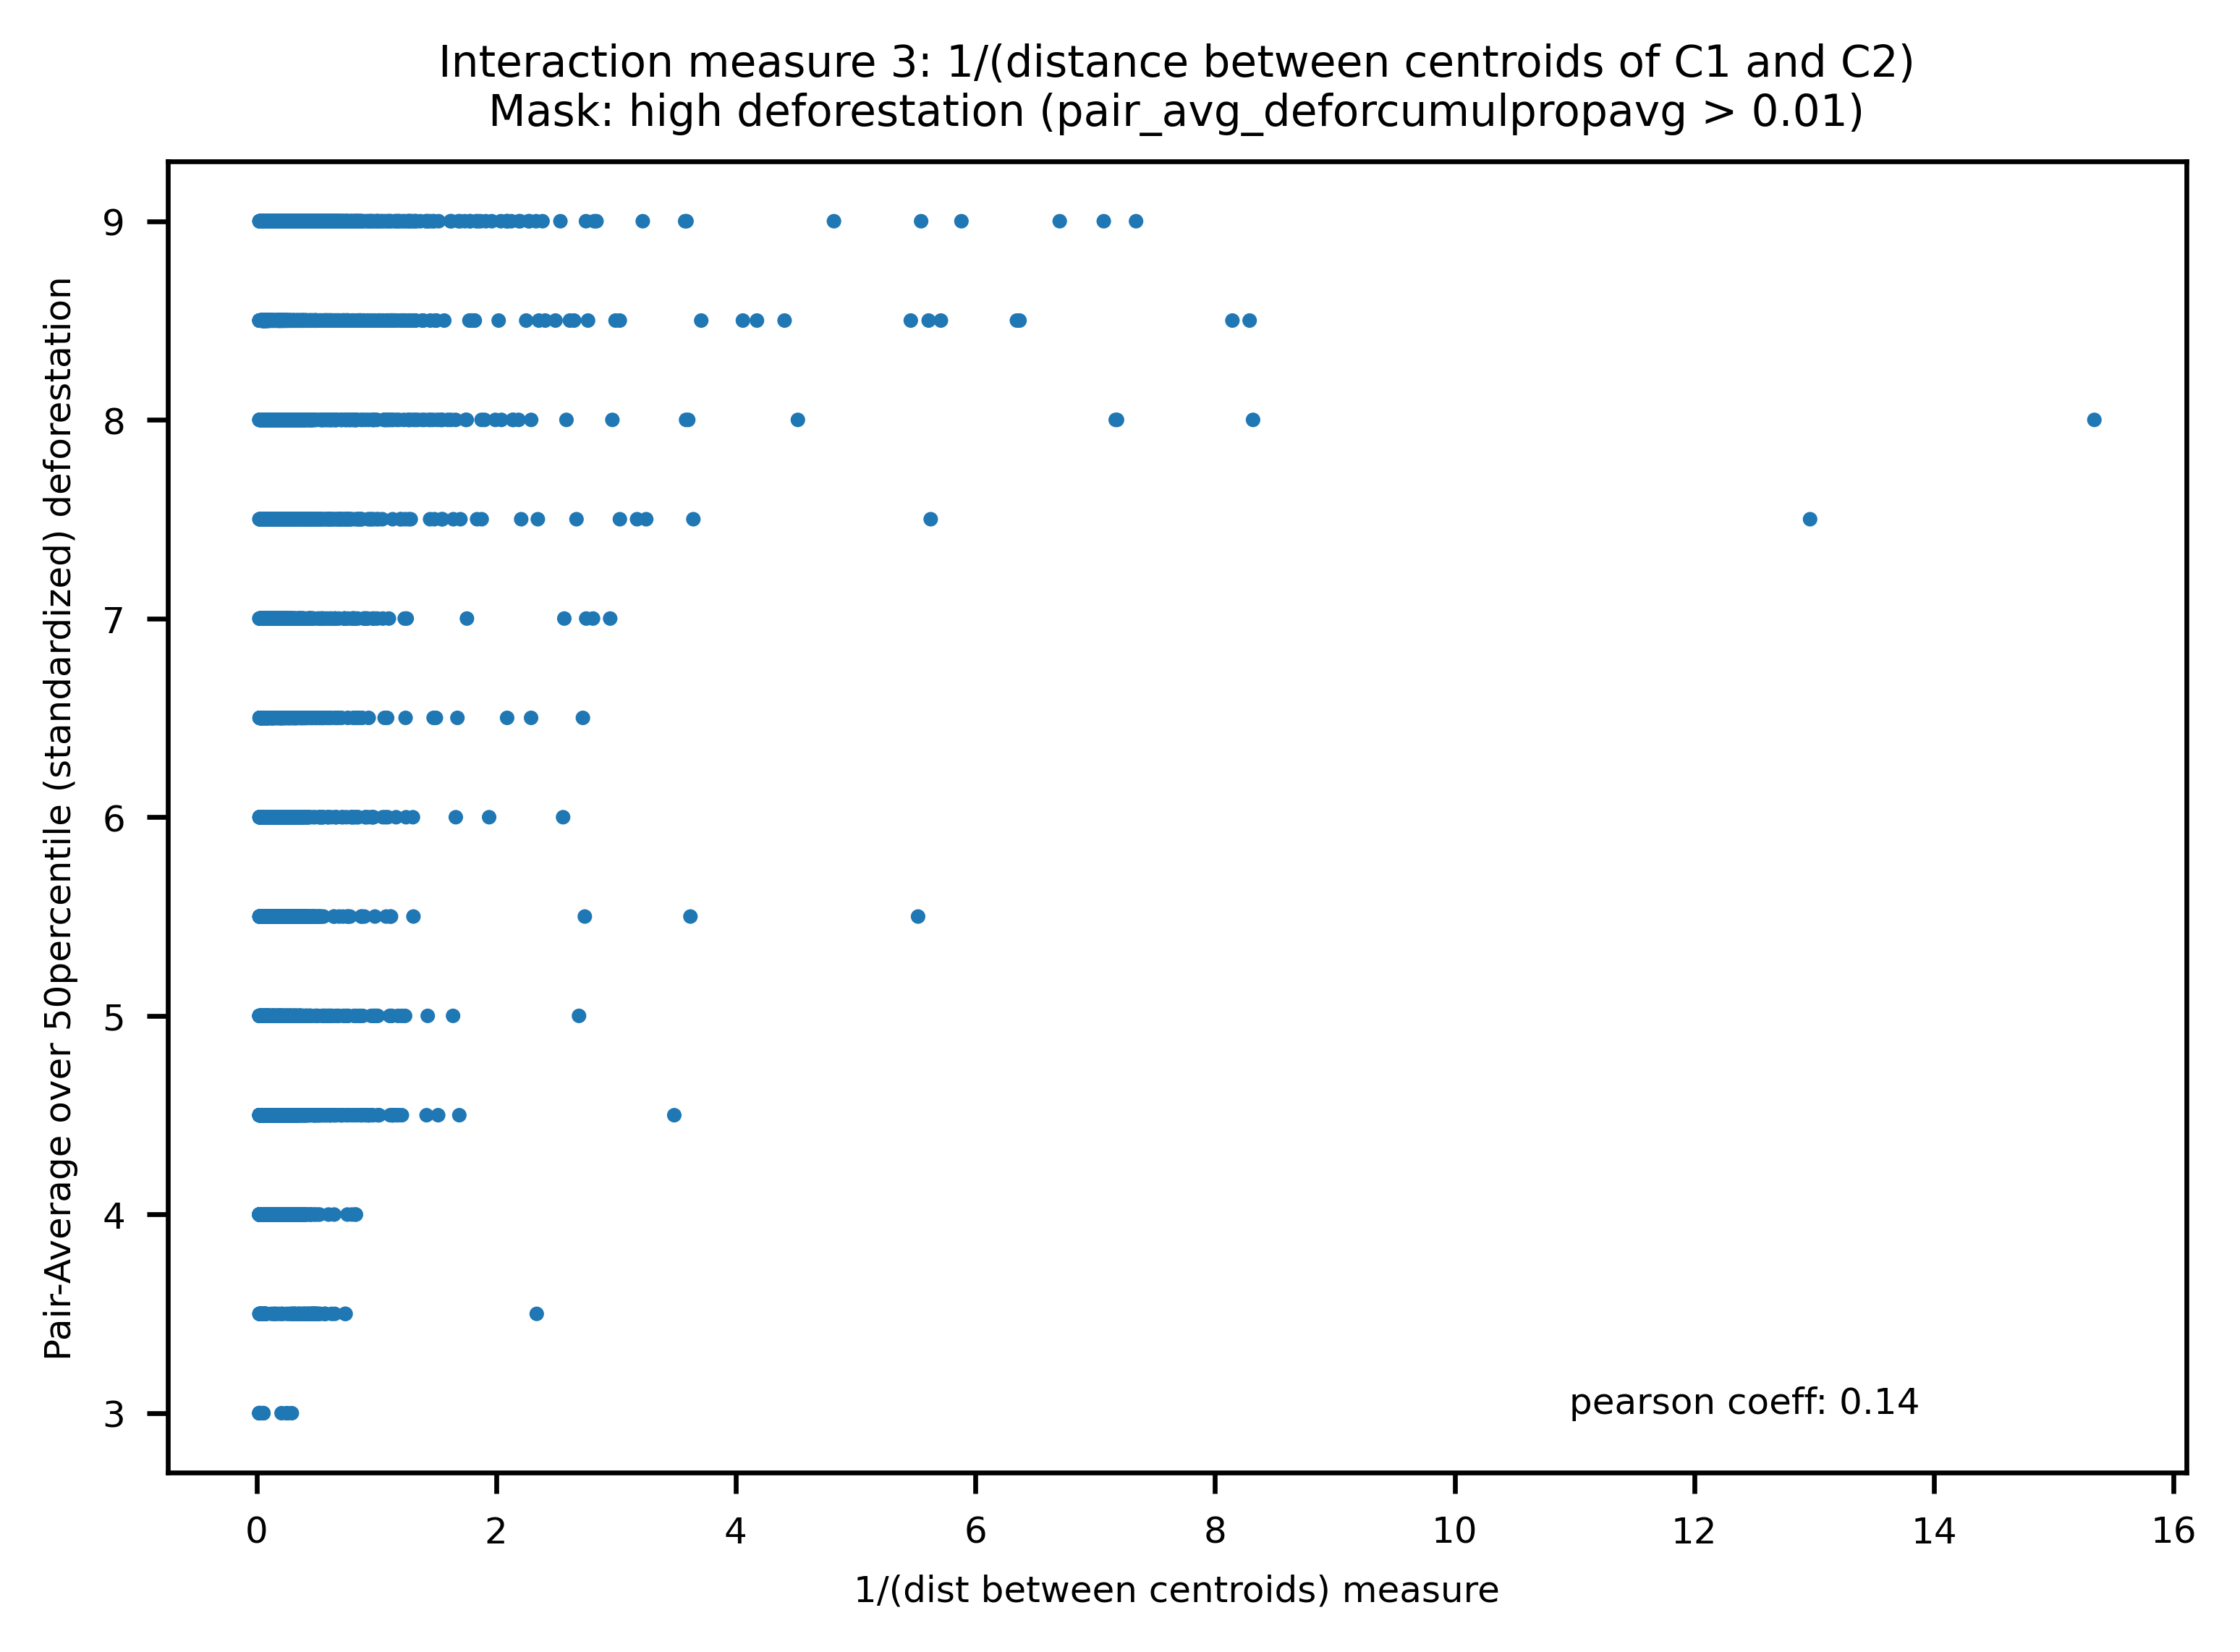

In [51]:
# 11/8
# isolate for impact of dist between centroids only: x = areas_sum_arr
# we see that closer distance implies higher probability of higher overall deforestation
#high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)   
x = centroid_dist_only_measure[high_defor_only_mask]
y = pair_avg_deforcountover50p[high_defor_only_mask]#pair_avg_defor_normed_over50p[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: 1/(distance between centroids of C1 and C2)\nMask: high deforestation (pair_avg_deforcumulpropavg > 0.01)")
plt.xlabel("1/(dist between centroids) measure")
plt.ylabel("Pair-Average over 50percentile (standardized) deforestation")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=3)
# plt.show()

### interaction measure 3A
score = (area C11+area C2)/(dist between centroids of C1, C2)^2
- is dimensionless , same as measure 3 but with denominator squares

Text(168.24056343663952, 3, 'pearson coeff: 0.07')

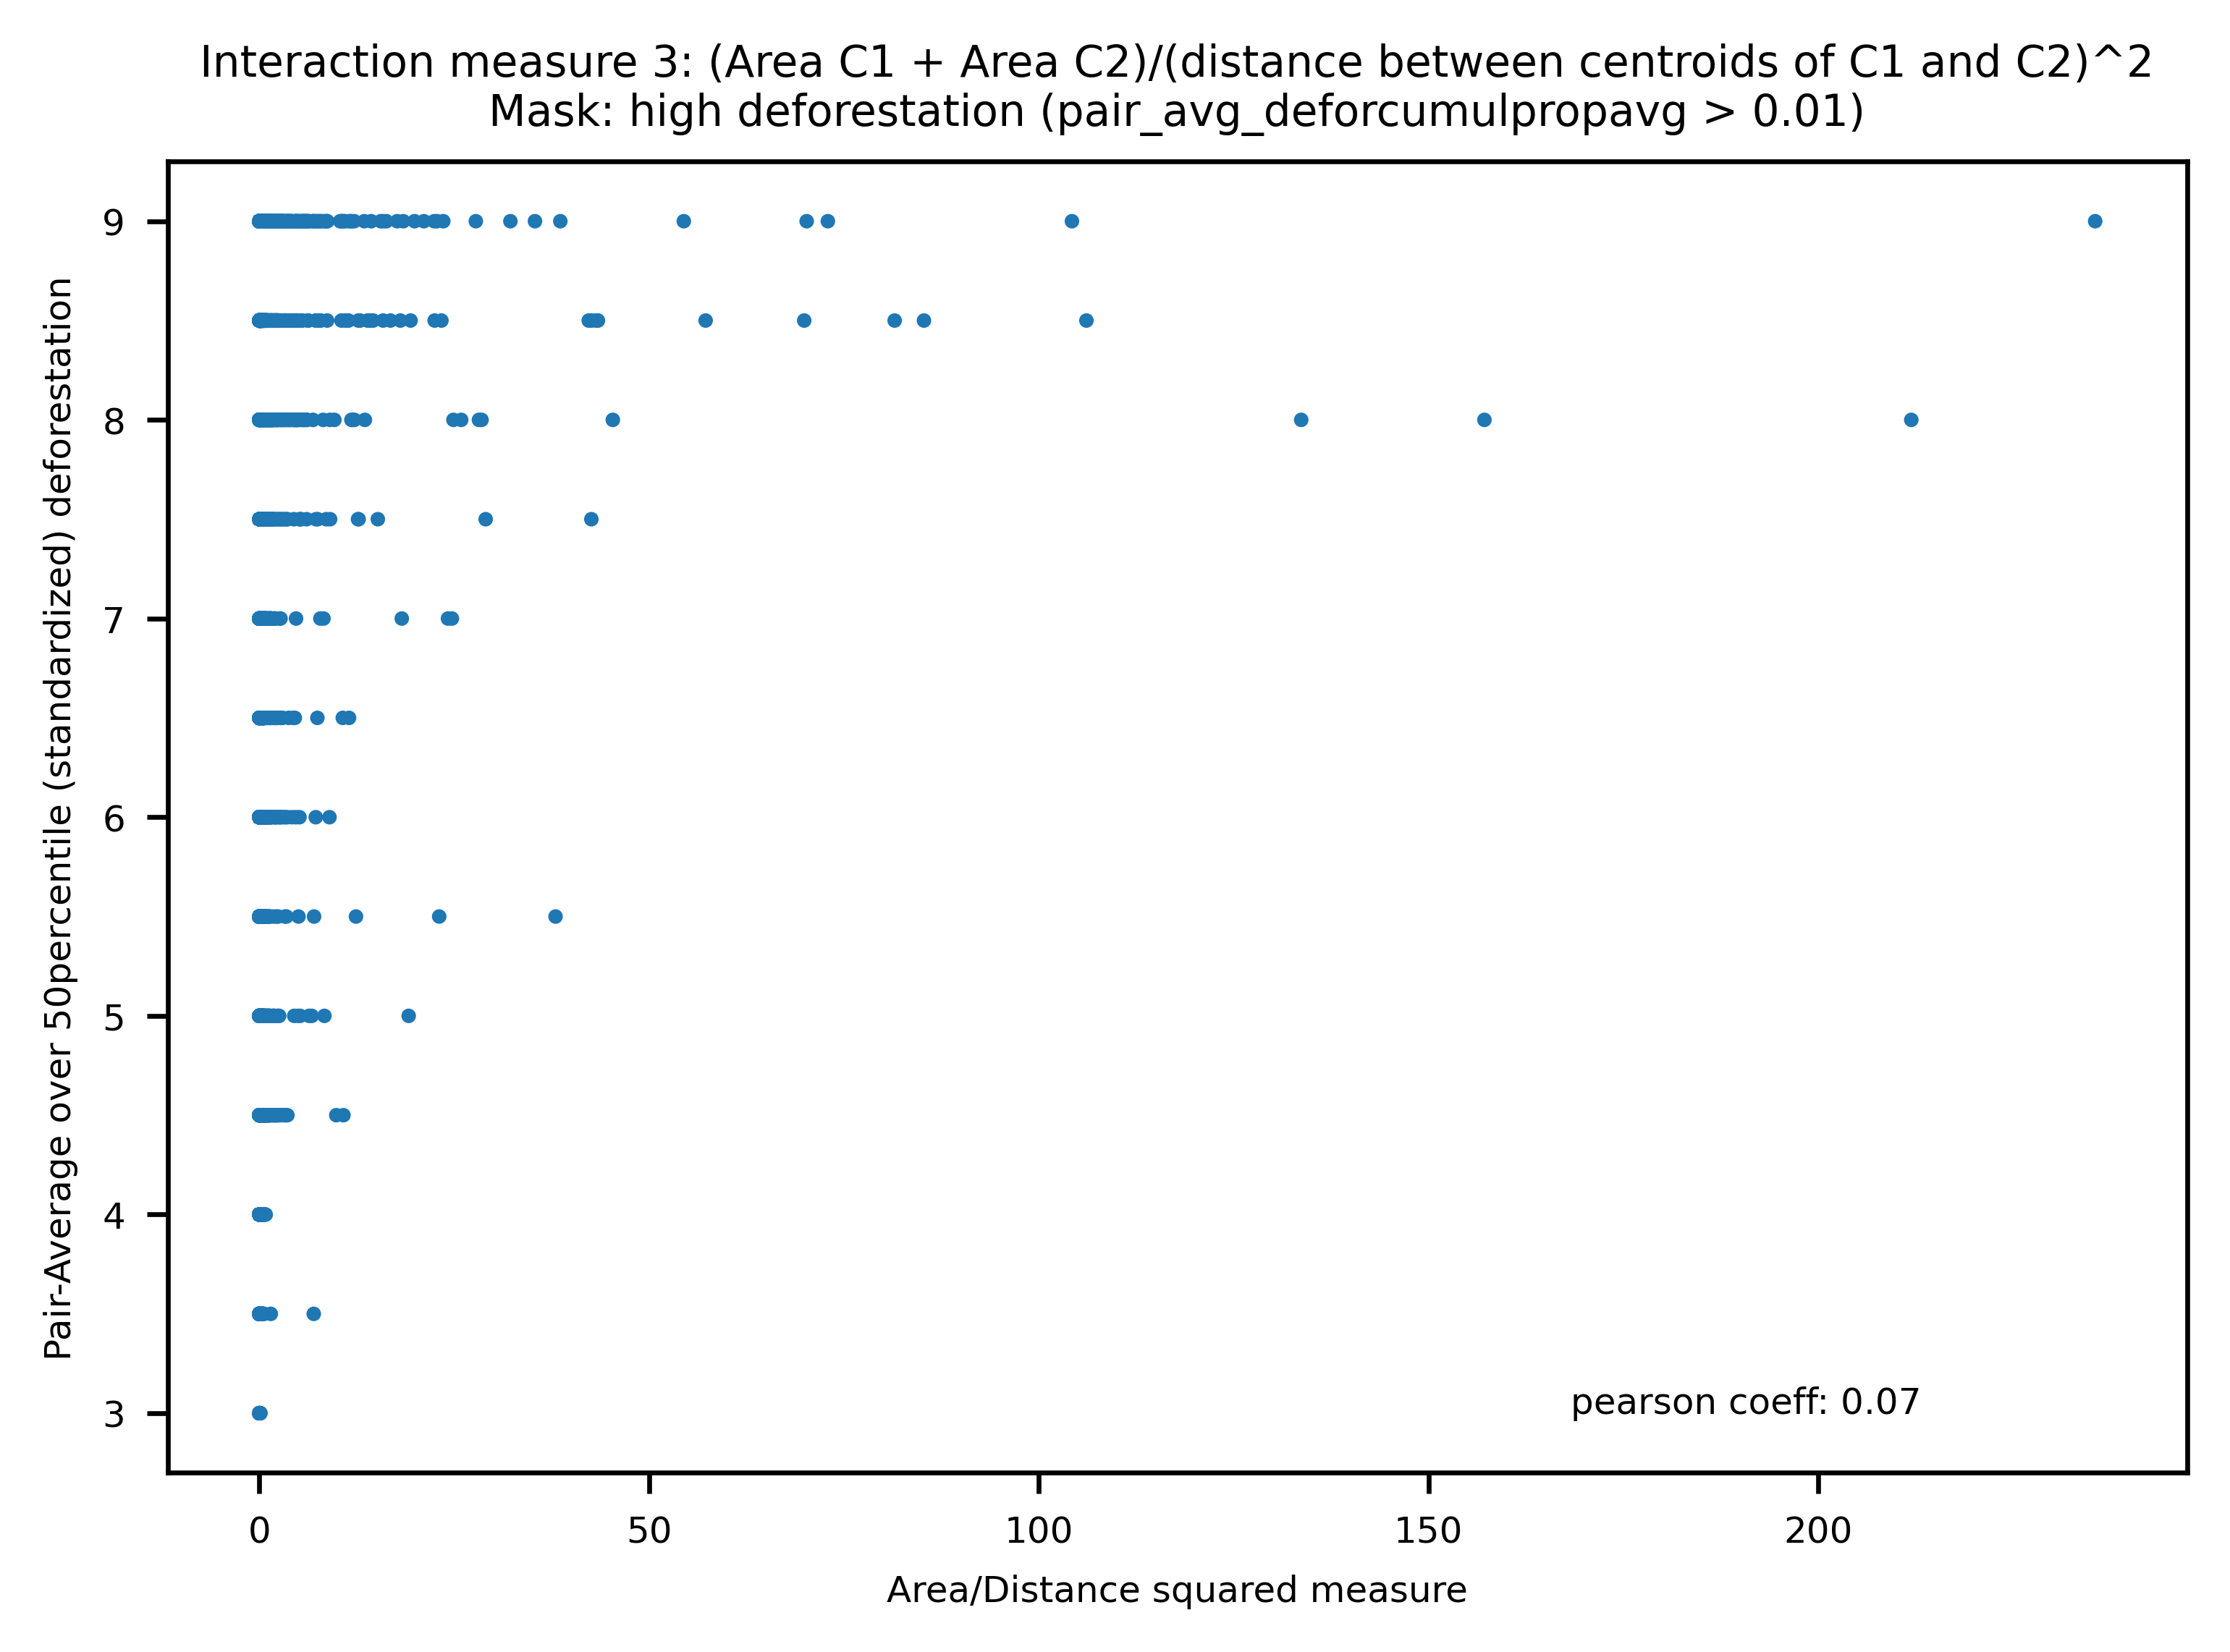

In [52]:
# 11/8
# dimensionless: (area1+area2)/(dist between centroids)^2
# we still see (as in cell 32, using dist/area measure): 
#       higher interaction implies higher probability of higher overall deforestation
# though the correlation is not as pronounced, likely due to the the additional 1/dist measure 
# effect of squashing down values
#high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)   
x = area_dist_squared_measure[high_defor_only_mask]
y = pair_avg_deforcountover50p[high_defor_only_mask]#pair_avg_defor_normed_over50p[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2)^2\nMask: high deforestation (pair_avg_deforcumulpropavg > 0.01)")
plt.xlabel("Area/Distance squared measure")
plt.ylabel("Pair-Average over 50percentile (standardized) deforestation")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=3)
# plt.show()

Text(168.24056343663952, 0.35, 'pearson coeff: 0.067')

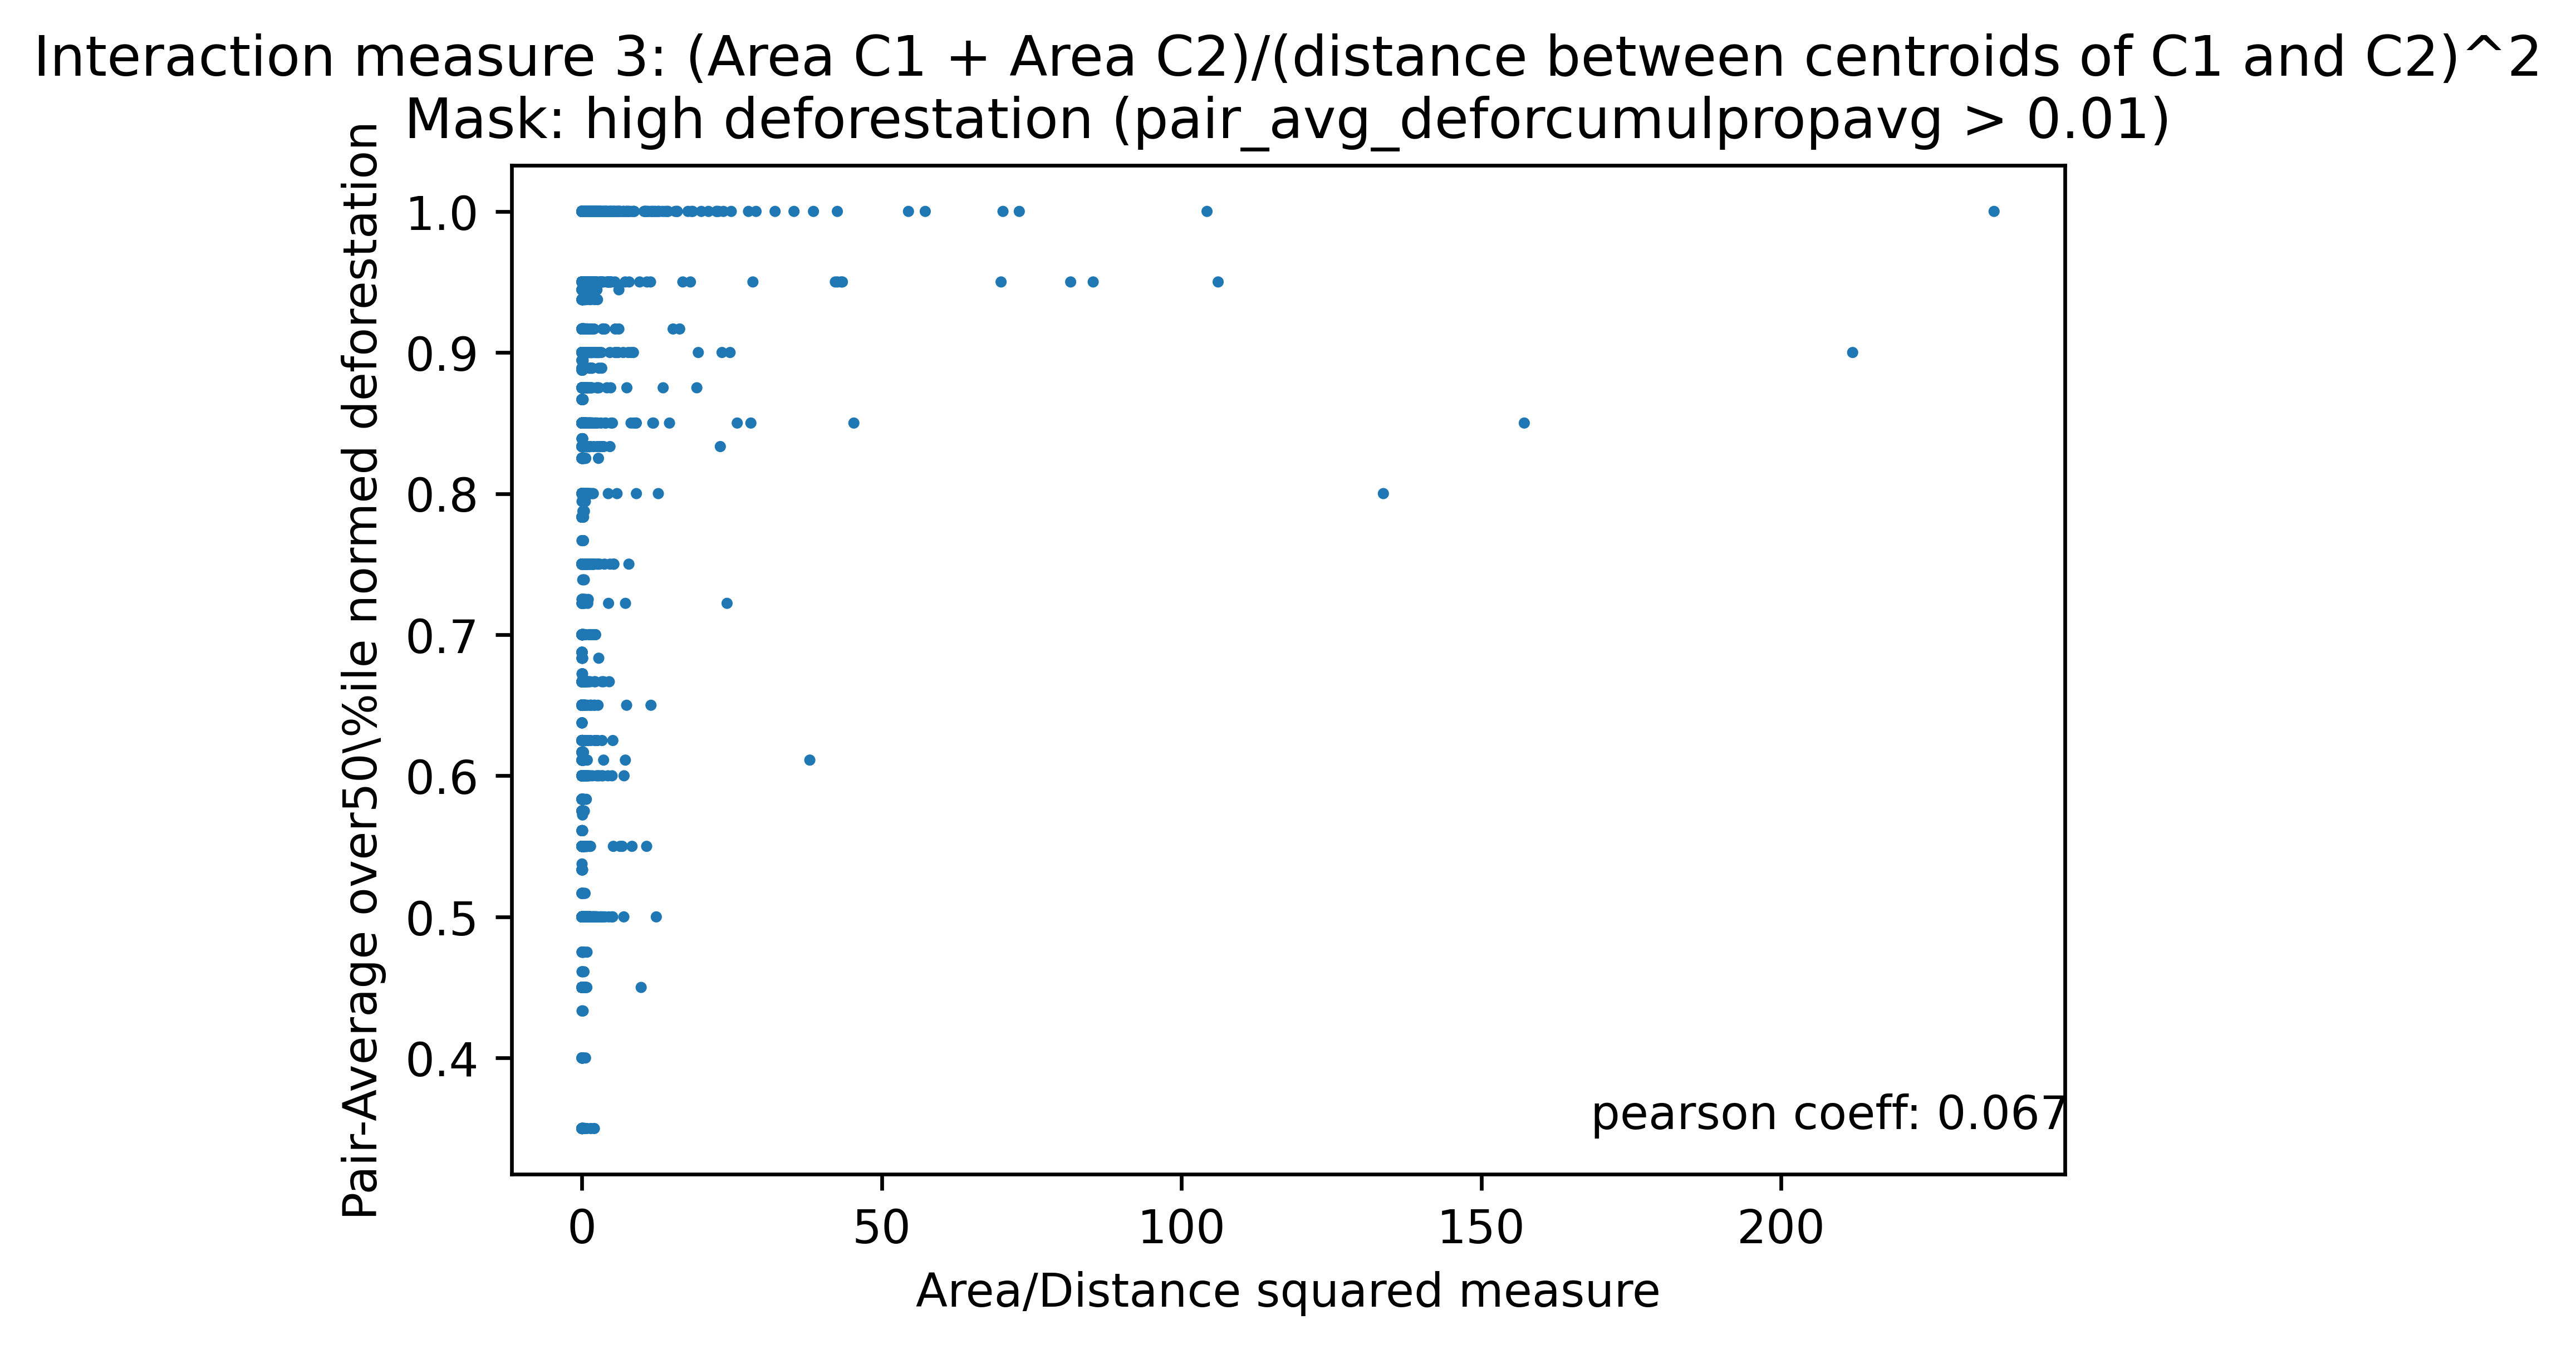

In [51]:
# 12/1
# dimensionless: (area1+area2)/(dist between centroids)^2
# we still see (as in cell 32, using dist/area measure): 
#       higher interaction implies higher probability of higher overall deforestation
# though the correlation is not as pronounced, likely due to the the additional 1/dist measure 
# effect of squashing down values
#high_defor_only_mask = np.where(pair_avg_deforcumulpropavg > 0.01)   
x = area_dist_squared_measure[high_defor_only_mask]
y = pair_avg_defor_normed_over50p[high_defor_only_mask]#pair_avg_defor_normed_over50p[high_defor_only_mask]
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2)^2\nMask: high deforestation (pair_avg_deforcumulpropavg > 0.01)")
plt.xlabel("Area/Distance squared measure")
plt.ylabel("Pair-Average over50\%ile normed deforestation")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=.35)
# plt.show()

Text(4644.795358187721, 0.05, 'pearson coeff: -0.013')

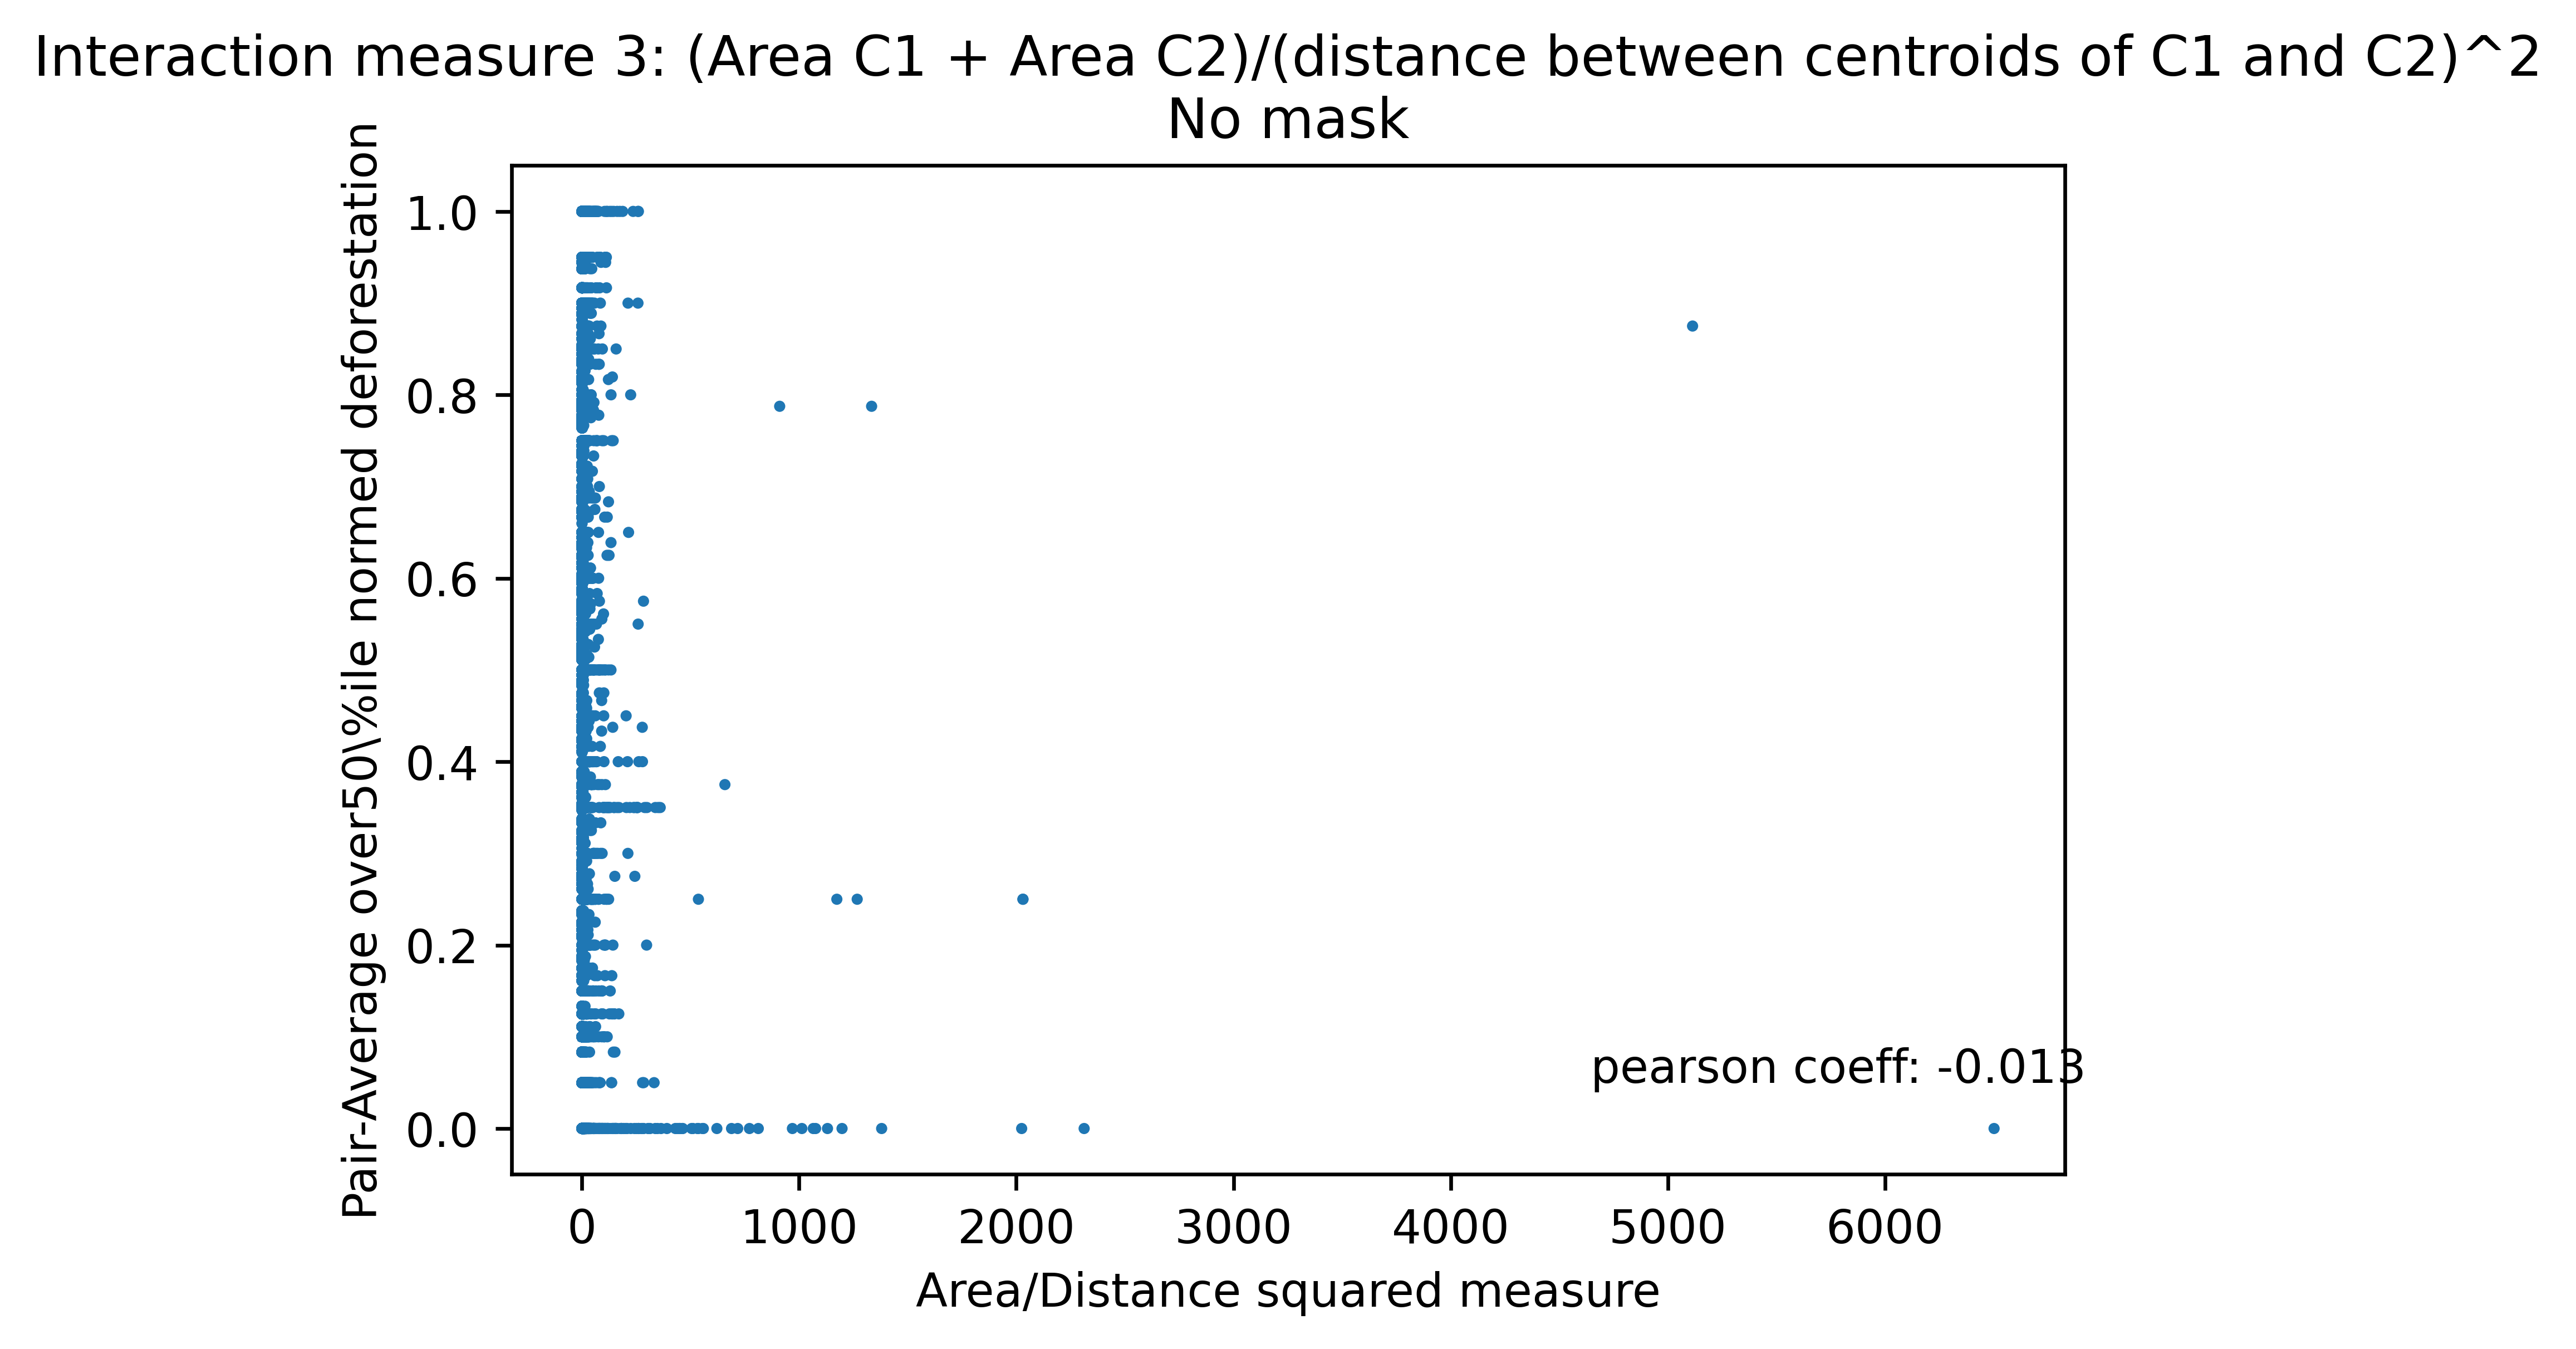

In [54]:
# 12/1
# no mask
# # dimensionless: (area1+area2)/(dist between centroids)^2
# we still see (as in cell 32, using dist/area measure): 
#       higher interaction implies higher probability of higher overall deforestation
# though the correlation is not as pronounced, likely due to the the additional 1/dist measure 
# squashing down values
x = area_dist_squared_measure
y = pair_avg_defor_normed_over50p
plt.scatter(x=x, y=y, s=[2]*len(x))
plt.title("Interaction measure 3: (Area C1 + Area C2)/(distance between centroids of C1 and C2)^2\nNo mask")
plt.xlabel("Area/Distance squared measure")
plt.ylabel("Pair-Average over50\%ile normed deforestation")
plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=.05)
# plt.show()

a function for plotting code

In [ ]:
def make_plot(x_var, y_var, year=None):
    # x_var = "neighbor"+year
    # y_var = "defor"+year
    x = np.array(features_by_lc_dropped[x_var])
    y = np.array(features_by_lc_dropped[y_var])

    # mask = [~is_outlier(y)]
    # plt.scatter(features_by_lc_dropped["degree"][~mask], features_by_lc_dropped["defor2000"][~mask] )

    # mask = ~is_outlier(y)
    # filtered_x, filtered_y = x[mask], y[mask]
    # plt.scatter(filtered_x, filtered_y, s=[2]*len(filtered_x))

    if year is not None:
        x, y = x[ids_by_year[year]], y[ids_by_year[year]]

    print(len(x), len(y))
    plt.scatter(x, y, s=[2]*len(x))

    # plt.hist2d(filtered_x, filtered_y)
    plt.title(x_var + " vs " + y_var)# + ", outliers removed")
    plt.xlabel(x_var)
    plt.ylabel(y_var)

    # plt.text(s="pearson coeff: " + str(round(stats.pearsonr(filtered_x, filtered_y)[0],3)), x=max(filtered_x*5/7), y=0)
    plt.text(s="pearson coeff: " + str(round(stats.pearsonr(x, y)[0],3)), x=max(x*5/7), y=0)

    plt.show()